In [50]:
!pip install numpy scikit-learn pandas matplotlib seaborn pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 43.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 49.9 MB/s eta 0:00:0000:0100:01
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190249 sha256=1c0c3bde8039a77eedc2c7bead3eb55809b135628c8448a0449bf60d422a999e
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [55]:
import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

In [72]:
import pandas as pd

df = pd.read_csv('DG_out.csv', sep=',')
df.head()

tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

     in_btc   out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0  0.000000 50.000000  50.000000     0.000000     50.000000             0   
1 50.000000 50.000000 100.000000    50.000000     25.000000             0   
2 10.000000 10.000000  20.000000    10.000000     10.000000             0   
3 40.000000 30.000000  70.000000    40.000000     30.000000             0   
4 30.000000 30.000000  60.000000    30.000000     15.000000             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0              0             0                     0              0  
1              0             0                     0              0  
2              0             0                     0              0  
3              0             0                     0              0  
4              0             0                     0              0

In [73]:
columns_to_drop = [
    'tx_hash', 'in_malicious', 'out_malicious', 
    'is_malicious', 'all_malicious'
]

df.drop(columns=columns_to_drop, axis=1, inplace=True)
print(df.describe())

             indegree       outdegree          in_btc         out_btc  \
count 30248134.000000 30248134.000000 30248134.000000 30248134.000000   
mean         2.148699        2.148699       54.841501       54.841501   
std          7.421447        4.512048     1303.302881     1301.473470   
min          0.000000        0.000000        0.000000        0.000000   
25%          1.000000        2.000000        0.100000        0.099500   
50%          1.000000        2.000000        0.932500        0.959000   
75%          2.000000        2.000000        8.591912        9.063657   
max       1932.000000     1322.000000   550000.000000   500020.700377   

            total_btc     mean_in_btc    mean_out_btc  out_and_tx_malicious  
count 30248134.000000 30248134.000000 30248134.000000       30248134.000000  
mean       109.683002       49.239797       28.770874              0.000004  
std       2602.526618      972.920965      712.556663              0.001890  
min          0.000000        0

In [74]:
df['out_and_tx_malicious'].value_counts()

out_and_tx_malicious
0    30248026
1         108
Name: count, dtype: int64

In [75]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree'] = np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc'] = np.log1p(scaled_df['out_btc'])
scaled_df['total_btc'] = np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc'] = np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc'] = np.log1p(scaled_df['mean_out_btc'])

In [76]:
# RobustScaler is less prone to outliers
rob_scaler = RobustScaler()

columns_to_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']

for column in columns_to_scale:
    scaled_df[column] = rob_scaler.fit_transform(scaled_df[column].values.reshape(-1, 1))

In [77]:
print(scaled_df.describe())

             indegree       outdegree          in_btc         out_btc  \
count 30248134.000000 30248134.000000 30248134.000000 30248134.000000   
mean         0.613270       -0.026267        0.311796        0.306947   
std          1.137854        0.268113        0.728987        0.716688   
min         -1.709511       -1.098612       -0.304217       -0.303709   
25%          0.000000        0.000000       -0.260206       -0.260867   
50%          0.000000        0.000000        0.000000        0.000000   
75%          1.000000        0.000000        0.739794        0.739133   
max         16.952584        6.089045        5.799225        5.623103   

            total_btc     mean_in_btc    mean_out_btc  out_and_tx_malicious  
count 30248134.000000 30248134.000000 30248134.000000       30248134.000000  
mean         0.230243        0.408052        0.395280              0.000004  
std          0.648090        0.830839        0.835617              0.001890  
min         -0.391205       -0

In [78]:
del df #free memory
gc.collect()

4352

In [84]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df['out_and_tx_malicious'] == 0]
original_train_fraud_df = original_train_df[original_train_df['out_and_tx_malicious'] == 1]
def get_training_sample(n):   
    normal_sample = original_train_normal_df.sample(n)  
    final_sample = pd.concat([normal_sample, original_train_fraud_df])   
    final_sample = shuffle(final_sample)   
    
    X_sample = final_sample.iloc[:, :-1].values
    y_sample = final_sample.iloc[:, -1].values
    
    return X_sample, y_sample

n_samples = 100
X_sample, y_sample = get_training_sample(n_samples)

print(X_sample.shape)
print(y_sample.shape)

(182, 7)
(182,)


In [85]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df['out_and_tx_malicious'] == 0]
original_test_fraud_df = original_test_df[original_test_df['out_and_tx_malicious'] == 1]

def get_test_sample(n):
    
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    
    X_sample = final_sample.iloc[:, :-1].values
    y_sample = final_sample.iloc[:, -1].values
    
    return X_sample, y_sample
    
n_samples = 100  
X_test_sample, y_test_sample = get_test_sample(n_samples)

print(X_test_sample.shape)
print(y_test_sample.shape)

(126, 7)
(126,)


In [87]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 10.1 MB/s eta 0:00:00


In [88]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, sampling_strategy):
    sm = SMOTE(sampling_strategy=sampling_strategy, n_jobs=-1)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    return X_resampled, y_resampled  

In [89]:
def evaluate(actual, predicted, probability, time_complexity):
    # Initialize the evaluation metrics dictionary
    eval_metric = {}
    eval_metric['time'] = time_complexity
    
    # Compute the confusion matrix
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    # Compute and store various accuracy metrics
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted), 7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted), 7)
    
    # Compute and store macro precision, recall, F1, and ROC AUC scores
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"), 7)
    eval_metric['macro_recall'] = round(recall_score(actual, predicted, average="macro"), 7)
    eval_metric['macro_f1'] = round(f1_score(actual, predicted, average="macro"), 7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"), 7)
    
    # Compute and store standard precision, recall, F1, and ROC AUC scores
    eval_metric['precision'] = round(precision_score(actual, predicted), 7)
    eval_metric['recall'] = round(recall_score(actual, predicted), 7)
    eval_metric['f1'] = round(f1_score(actual, predicted), 7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability), 7)
    
    # Compute and store the ROC curve metrics
    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    # Compute and store the precision-recall curve metrics
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    
    return eval_metric

In [97]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00


In [103]:
import os
import pickle

# Check if the directory exists, if not, create it
directory = './Models/PCA/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Iterate over models and save them
for k in models:
    with open(directory + 'k=' + str(k) + '.h5', 'wb') as file:
        pickle.dump(models.get(k), file)

In [105]:
from pyod.models.pca import PCA

iterations = 20
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
oversampling_fraction = 0.240
outliers_fraction = oversampling_fraction

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))

def fit_model(X_train):
    clf = PCA(n_components=3, 
              n_selected_components=1, 
              contamination=outliers_fraction, 
              copy=True, 
              whiten=False, 
              svd_solver='auto', 
              tol=0.5, 
              iterated_power='auto', 
              random_state=random_state, 
              weighted=True, 
              standardization=False)
    
    clf.fit(X_train)
    return clf

Training Parameters:

Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.24
Outliers Fraction: 0.24


In [104]:
training_evaluations = {}
test_evaluations = {}
model = {}

for i in range(0, iterations):
    sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
    print("Iteration "+ str(i+1)+ " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(X_train)
    end = time.time()
    save_model(clf, model_path+'i='+str(i+1)+'.h5')
    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    training_time = round(end - start, 4)
    model[i+1] = clf
    training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)
    
    print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    y_test_pred = clf.predict(original_Xtest)
    y_test_scores = clf.decision_function(original_Xtest)
    test_end = time.time()
    testing_time = round(test_end - test_start, 4)
    test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

    print("Iteration: (" + str((i+1)) + "/" + str(iterations) + ")    Training Time: "+str(training_time)+" seconds     Testing Time: "+ str(testing_time)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration 1 Trained
Iteration: (1/20)    Training Time: 1.8196 seconds     Testing Time: 0.4031 seconds
Iteration 2 in progress...
Iteration 2 Trained
Iteration: (2/20)    Training Time: 1.825 seconds     Testing Time: 0.4047 seconds
Iteration 3 in progress...
Iteration 3 Trained
Iteration: (3/20)    Training Time: 1.8109 seconds     Testing Time: 0.4201 seconds
Iteration 4 in progress...
Iteration 4 Trained
Iteration: (4/20)    Training Time: 1.7622 seconds     Testing Time: 0.4127 seconds
Iteration 5 in progress...
Iteration 5 Trained
Iteration: (5/20)    Training Time: 1.8294 seconds     Testing Time: 0.4249 seconds
Iteration 6 in progress...
Iteration 6 Trained
Iteration: (6/20)    Training Time: 1.7604 seconds     Testing Time: 0.4282 seconds
Iteration 7 in progress...
Iteration 7 Trained
Iteration: (7/20)    Training Time: 1.8092 seconds     Testing Time: 0.4241 seconds
Iteration 8 in progress...
Iteration 8 Trained
Iteration: (8/20)    Training Time: 1

In [106]:
columns = ['Iteration', 'Accuracy', 'Balanced-Accuracy', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time']

def evaluations_to_df(evaluations):
    return pd.DataFrame.from_records(
        [
            {
                'Iteration': str(it),
                'Accuracy': evaluations[it]['accuracy'],
                'Balanced-Accuracy': evaluations[it]['balanced_accuracy'],
                'Macro-Precision': evaluations[it]['macro_precision'],
                'Macro-Recall': evaluations[it]['macro_recall'],
                'Macro-F1': evaluations[it]['macro_f1'],
                'Macro-ROC': evaluations[it]['macro_roc'],
                'Precision': evaluations[it]['precision'],
                'Recall': evaluations[it]['recall'],
                'F1': evaluations[it]['f1'],
                'ROC': evaluations[it]['roc'],
                'Time': evaluations[it]['time']
            }
            for it in evaluations.keys()
        ],
        columns=columns
    )

training_eval_df = evaluations_to_df(training_evaluations)
test_eval_df = evaluations_to_df(test_evaluations)

print(training_eval_df.head())
print(test_eval_df.head())

  Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
0         1  0.851224           0.807311         0.762979      0.807311   
1         2  0.855863           0.814740         0.769337      0.814740   
2         3  0.855799           0.814637         0.769248      0.814637   
3         4  0.855856           0.814730         0.769328      0.814730   
4         5  0.855629           0.814366         0.769016      0.814366   

   Macro-F1  Macro-ROC  Precision   Recall       F1      ROC     Time  
0  0.780933   0.896303   0.593277 0.735664 0.656842 0.896303 1.819600  
1  0.787763   0.893529   0.602940 0.747646 0.667541 0.893529 1.825000  
2  0.787668   0.893342   0.602806 0.747479 0.667392 0.893342 1.810900  
3  0.787753   0.893455   0.602926 0.747629 0.667526 0.893455 1.762200  
4  0.787418   0.893054   0.602453 0.747042 0.667001 0.893054 1.829400  
  Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
0         1  0.878900           0.862527  

In [107]:
training_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
7          8  0.855897           0.814795         0.769383      0.814795   
1          2  0.855863           0.814740         0.769337      0.814740   
3          4  0.855856           0.814730         0.769328      0.814730   
15        16  0.855835           0.814697         0.769299      0.814697   
2          3  0.855799           0.814637         0.769248      0.814637   
9         10  0.855669           0.814430         0.769071      0.814430   
4          5  0.855629           0.814366         0.769016      0.814366   
18        19  0.855554           0.814245         0.768913      0.814245   
5          6  0.855382           0.813970         0.768677      0.813970   
12        13  0.851577           0.807876         0.763463      0.807876   
14        15  0.851528           0.807797         0.763395      0.807797   
13        14  0.851452           0.807677         0.763292      0.807677   
16        17  0.851386           0.807571         0.763201      0.807571   
19        20  0.851378           0.807557         0.763189      0.807557   
8          9  0.851327           0.807476         0.763120      0.807476   
10        11  0.851274           0.807390         0.763047      0.807390   
11        12  0.851260           0.807368         0.763028      0.807368   
0          1  0.851224           0.807311         0.762979      0.807311   
6          7  0.851102           0.807115         0.762811      0.807115   
17        18  0.851001           0.806954         0.762673      0.806954   

    Macro-F1  Macro-ROC  Precision   Recall       F1      ROC     Time  
7   0.787813   0.893156   0.603011 0.747734 0.667619 0.893156 1.864900  
1   0.787763   0.893529   0.602940 0.747646 0.667541 0.893529 1.825000  
3   0.787753   0.893455   0.602926 0.747629 0.667526 0.893455 1.762200  
15  0.787723   0.893094   0.602883 0.747576 0.667478 0.893094 1.905500  
2   0.787668   0.893342   0.602806 0.747479 0.667392 0.893342 1.810900  
9   0.787477   0.893049   0.602536 0.747145 0.667094 0.893049 1.837900  
4   0.787418   0.893054   0.602453 0.747042 0.667001 0.893054 1.829400  
18  0.787308   0.892952   0.602296 0.746847 0.666828 0.892952 1.814400  
5   0.787054   0.892856   0.601937 0.746403 0.666431 0.892856 1.760400  
12  0.781452   0.896715   0.594011 0.736575 0.657656 0.896715 1.826600  
14  0.781380   0.896269   0.593908 0.736447 0.657542 0.896269 1.789300  
13  0.781269   0.896448   0.593752 0.736253 0.657368 0.896448 1.844000  
16  0.781172   0.896512   0.593614 0.736082 0.657216 0.896512 1.767000  
19  0.781159   0.896794   0.593596 0.736060 0.657196 0.896794 1.881700  
8   0.781084   0.896408   0.593491 0.735929 0.657079 0.896408 1.864000  
10  0.781006   0.896504   0.593379 0.735791 0.656956 0.896504 1.850800  
11  0.780985   0.896345   0.593350 0.735755 0.656924 0.896345 1.908800  
0   0.780933   0.896303   0.593277 0.735664 0.656842 0.896303 1.819600  
6   0.780752   0.896237   0.593021 0.735347 0.656559 0.896237 1.809200  
17  0.780604   0.896228   0.592812 0.735087 0.656327 0.896228 1.839800

In [108]:
training_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
19        20  0.851378           0.807557         0.763189      0.807557   
12        13  0.851577           0.807876         0.763463      0.807876   
16        17  0.851386           0.807571         0.763201      0.807571   
10        11  0.851274           0.807390         0.763047      0.807390   
13        14  0.851452           0.807677         0.763292      0.807677   
8          9  0.851327           0.807476         0.763120      0.807476   
11        12  0.851260           0.807368         0.763028      0.807368   
0          1  0.851224           0.807311         0.762979      0.807311   
14        15  0.851528           0.807797         0.763395      0.807797   
6          7  0.851102           0.807115         0.762811      0.807115   
17        18  0.851001           0.806954         0.762673      0.806954   
1          2  0.855863           0.814740         0.769337      0.814740   
3          4  0.855856           0.814730         0.769328      0.814730   
2          3  0.855799           0.814637         0.769248      0.814637   
7          8  0.855897           0.814795         0.769383      0.814795   
15        16  0.855835           0.814697         0.769299      0.814697   
4          5  0.855629           0.814366         0.769016      0.814366   
9         10  0.855669           0.814430         0.769071      0.814430   
18        19  0.855554           0.814245         0.768913      0.814245   
5          6  0.855382           0.813970         0.768677      0.813970   

    Macro-F1  Macro-ROC  Precision   Recall       F1      ROC     Time  
19  0.781159   0.896794   0.593596 0.736060 0.657196 0.896794 1.881700  
12  0.781452   0.896715   0.594011 0.736575 0.657656 0.896715 1.826600  
16  0.781172   0.896512   0.593614 0.736082 0.657216 0.896512 1.767000  
10  0.781006   0.896504   0.593379 0.735791 0.656956 0.896504 1.850800  
13  0.781269   0.896448   0.593752 0.736253 0.657368 0.896448 1.844000  
8   0.781084   0.896408   0.593491 0.735929 0.657079 0.896408 1.864000  
11  0.780985   0.896345   0.593350 0.735755 0.656924 0.896345 1.908800  
0   0.780933   0.896303   0.593277 0.735664 0.656842 0.896303 1.819600  
14  0.781380   0.896269   0.593908 0.736447 0.657542 0.896269 1.789300  
6   0.780752   0.896237   0.593021 0.735347 0.656559 0.896237 1.809200  
17  0.780604   0.896228   0.592812 0.735087 0.656327 0.896228 1.839800  
1   0.787763   0.893529   0.602940 0.747646 0.667541 0.893529 1.825000  
3   0.787753   0.893455   0.602926 0.747629 0.667526 0.893455 1.762200  
2   0.787668   0.893342   0.602806 0.747479 0.667392 0.893342 1.810900  
7   0.787813   0.893156   0.603011 0.747734 0.667619 0.893156 1.864900  
15  0.787723   0.893094   0.602883 0.747576 0.667478 0.893094 1.905500  
4   0.787418   0.893054   0.602453 0.747042 0.667001 0.893054 1.829400  
9   0.787477   0.893049   0.602536 0.747145 0.667094 0.893049 1.837900  
18  0.787308   0.892952   0.602296 0.746847 0.666828 0.892952 1.814400  
5   0.787054   0.892856   0.601937 0.746403 0.666431 0.892856 1.760400

In [109]:
test_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
1          2  0.881943           0.883279         0.500016      0.883279   
2          3  0.881933           0.883274         0.500016      0.883274   
3          4  0.881881           0.883248         0.500016      0.883248   
15        16  0.881867           0.883241         0.500016      0.883241   
5          6  0.881828           0.883222         0.500016      0.883222   
9         10  0.881682           0.883149         0.500016      0.883149   
18        19  0.881642           0.883128         0.500016      0.883128   
4          5  0.881609           0.883112         0.500016      0.883112   
7          8  0.881592           0.883104         0.500016      0.883104   
10        11  0.879319           0.862736         0.500015      0.862736   
13        14  0.879221           0.862687         0.500015      0.862687   
12        13  0.879195           0.862674         0.500015      0.862674   
6          7  0.879137           0.862646         0.500015      0.862646   
14        15  0.879119           0.862636         0.500015      0.862636   
11        12  0.879113           0.862634         0.500015      0.862634   
8          9  0.879085           0.862619         0.500015      0.862619   
16        17  0.879078           0.862616         0.500015      0.862616   
17        18  0.879049           0.862602         0.500015      0.862602   
19        20  0.878967           0.862561         0.500015      0.862561   
0          1  0.878900           0.862527         0.500015      0.862527   

    Macro-F1  Macro-ROC  Precision   Recall       F1      ROC     Time  
1   0.468666   0.910720   0.000032 0.884615 0.000064 0.910720 0.404700  
2   0.468664   0.910089   0.000032 0.884615 0.000064 0.910089 0.420100  
3   0.468649   0.910008   0.000032 0.884615 0.000064 0.910008 0.412700  
15  0.468645   0.909853   0.000032 0.884615 0.000064 0.909853 0.431900  
5   0.468634   0.909753   0.000032 0.884615 0.000064 0.909753 0.428200  
9   0.468593   0.910113   0.000032 0.884615 0.000064 0.910113 0.422700  
18  0.468581   0.910448   0.000032 0.884615 0.000064 0.910448 0.425200  
4   0.468572   0.909980   0.000032 0.884615 0.000064 0.909980 0.424900  
7   0.468567   0.910218   0.000032 0.884615 0.000064 0.910218 0.424100  
10  0.467922   0.917228   0.000030 0.846154 0.000060 0.917228 0.429900  
13  0.467894   0.917252   0.000030 0.846154 0.000060 0.917252 0.429800  
12  0.467887   0.917251   0.000030 0.846154 0.000060 0.917251 0.428900  
6   0.467871   0.917238   0.000030 0.846154 0.000060 0.917238 0.424100  
14  0.467866   0.917296   0.000030 0.846154 0.000060 0.917296 0.435200  
11  0.467864   0.917185   0.000030 0.846154 0.000060 0.917185 0.432300  
8   0.467856   0.917260   0.000030 0.846154 0.000060 0.917260 0.425500  
16  0.467854   0.917251   0.000030 0.846154 0.000060 0.917251 0.424400  
17  0.467846   0.917132   0.000030 0.846154 0.000060 0.917132 0.423400  
19  0.467823   0.917169   0.000030 0.846154 0.000060 0.917169 0.428600  
0   0.467804   0.917168   0.000030 0.846154 0.000060 0.917168 0.403100

In [110]:
test_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
14        15  0.879119           0.862636         0.500015      0.862636   
8          9  0.879085           0.862619         0.500015      0.862619   
13        14  0.879221           0.862687         0.500015      0.862687   
16        17  0.879078           0.862616         0.500015      0.862616   
12        13  0.879195           0.862674         0.500015      0.862674   
6          7  0.879137           0.862646         0.500015      0.862646   
10        11  0.879319           0.862736         0.500015      0.862736   
11        12  0.879113           0.862634         0.500015      0.862634   
19        20  0.878967           0.862561         0.500015      0.862561   
0          1  0.878900           0.862527         0.500015      0.862527   
17        18  0.879049           0.862602         0.500015      0.862602   
1          2  0.881943           0.883279         0.500016      0.883279   
18        19  0.881642           0.883128         0.500016      0.883128   
7          8  0.881592           0.883104         0.500016      0.883104   
9         10  0.881682           0.883149         0.500016      0.883149   
2          3  0.881933           0.883274         0.500016      0.883274   
3          4  0.881881           0.883248         0.500016      0.883248   
4          5  0.881609           0.883112         0.500016      0.883112   
15        16  0.881867           0.883241         0.500016      0.883241   
5          6  0.881828           0.883222         0.500016      0.883222   

    Macro-F1  Macro-ROC  Precision   Recall       F1      ROC     Time  
14  0.467866   0.917296   0.000030 0.846154 0.000060 0.917296 0.435200  
8   0.467856   0.917260   0.000030 0.846154 0.000060 0.917260 0.425500  
13  0.467894   0.917252   0.000030 0.846154 0.000060 0.917252 0.429800  
16  0.467854   0.917251   0.000030 0.846154 0.000060 0.917251 0.424400  
12  0.467887   0.917251   0.000030 0.846154 0.000060 0.917251 0.428900  
6   0.467871   0.917238   0.000030 0.846154 0.000060 0.917238 0.424100  
10  0.467922   0.917228   0.000030 0.846154 0.000060 0.917228 0.429900  
11  0.467864   0.917185   0.000030 0.846154 0.000060 0.917185 0.432300  
19  0.467823   0.917169   0.000030 0.846154 0.000060 0.917169 0.428600  
0   0.467804   0.917168   0.000030 0.846154 0.000060 0.917168 0.403100  
17  0.467846   0.917132   0.000030 0.846154 0.000060 0.917132 0.423400  
1   0.468666   0.910720   0.000032 0.884615 0.000064 0.910720 0.404700  
18  0.468581   0.910448   0.000032 0.884615 0.000064 0.910448 0.425200  
7   0.468567   0.910218   0.000032 0.884615 0.000064 0.910218 0.424100  
9   0.468593   0.910113   0.000032 0.884615 0.000064 0.910113 0.422700  
2   0.468664   0.910089   0.000032 0.884615 0.000064 0.910089 0.420100  
3   0.468649   0.910008   0.000032 0.884615 0.000064 0.910008 0.412700  
4   0.468572   0.909980   0.000032 0.884615 0.000064 0.909980 0.424900  
15  0.468645   0.909853   0.000032 0.884615 0.000064 0.909853 0.431900  
5   0.468634   0.909753   0.000032 0.884615 0.000064 0.909753 0.428200

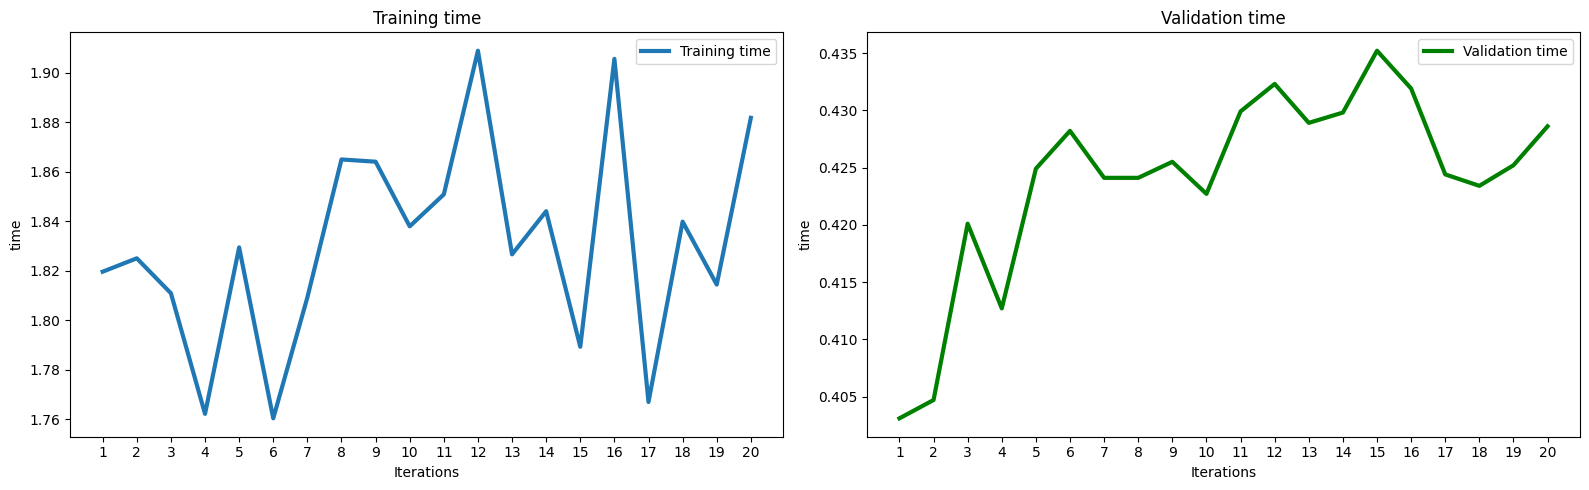

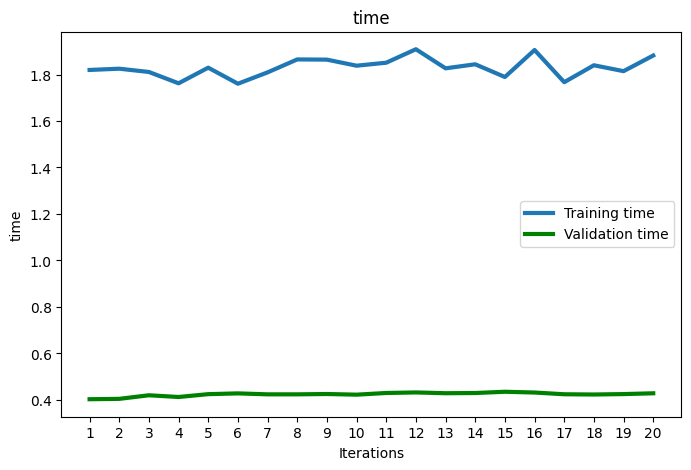

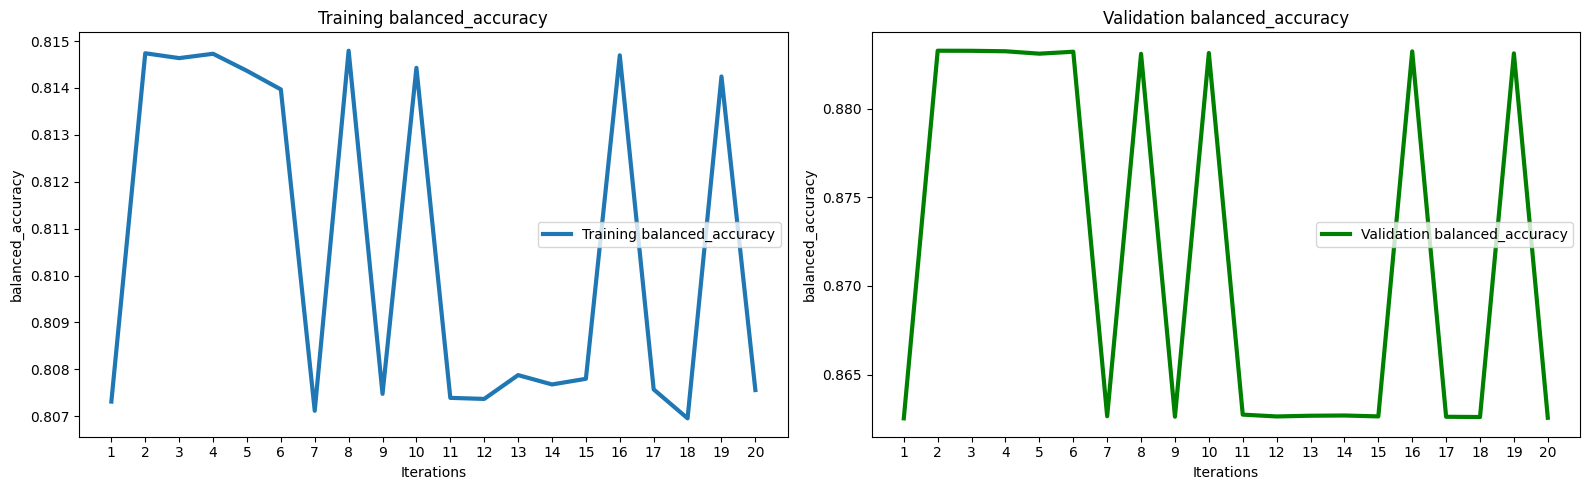

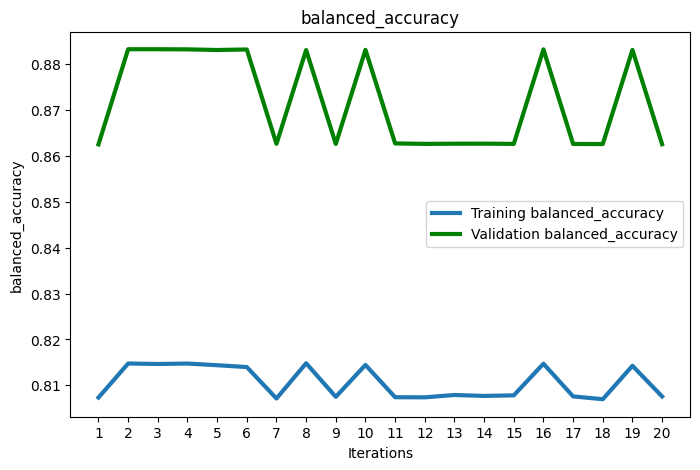

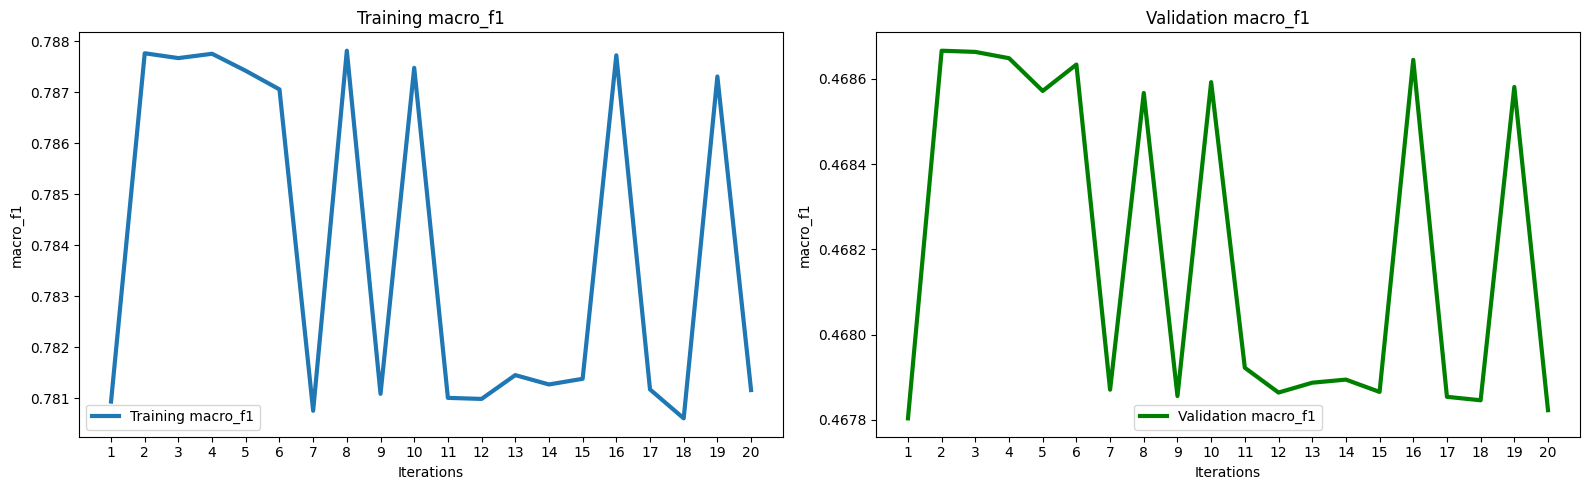

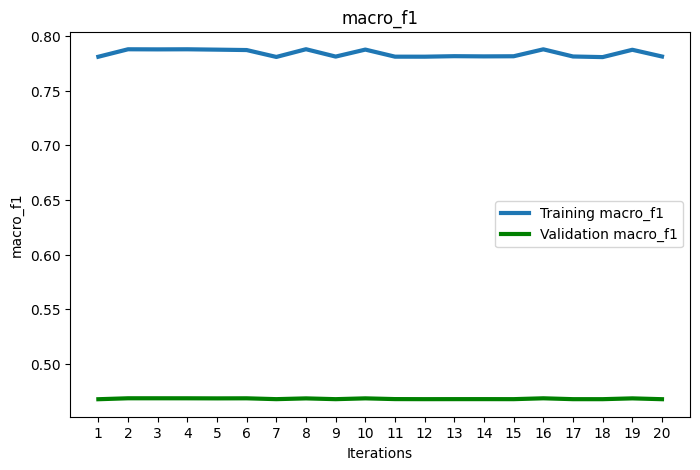

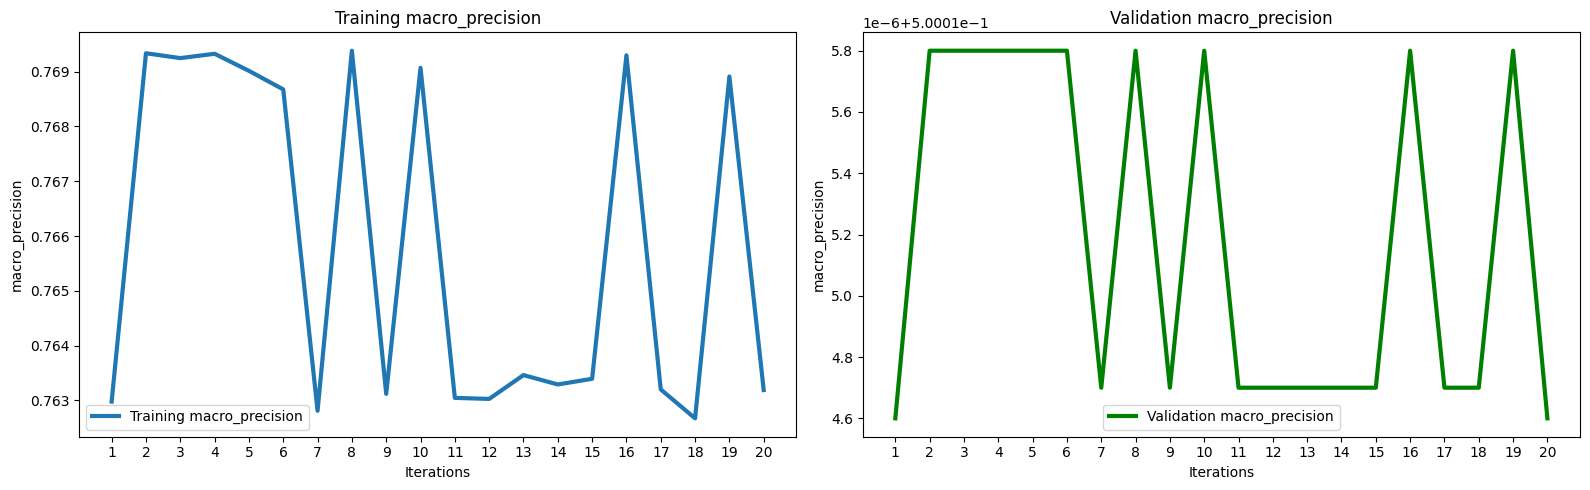

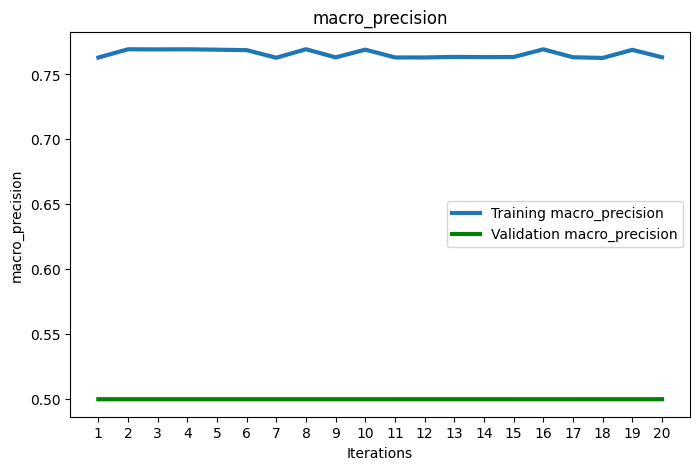

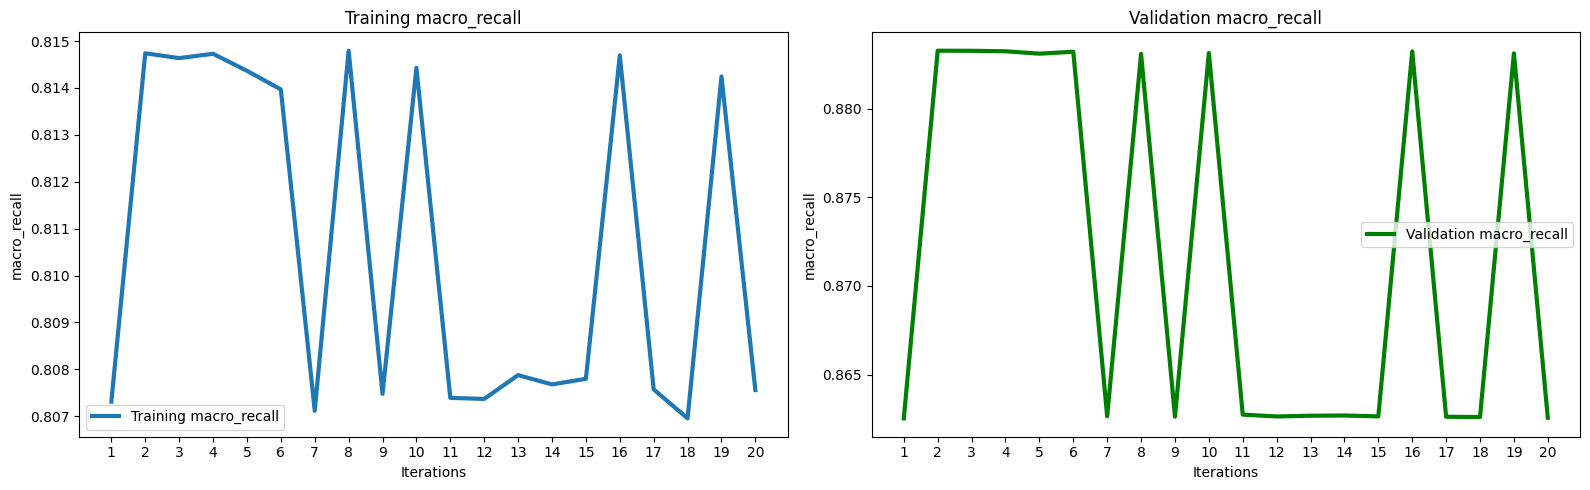

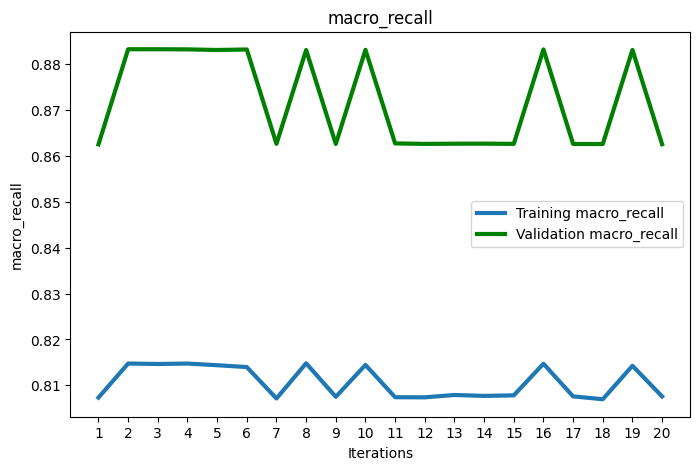

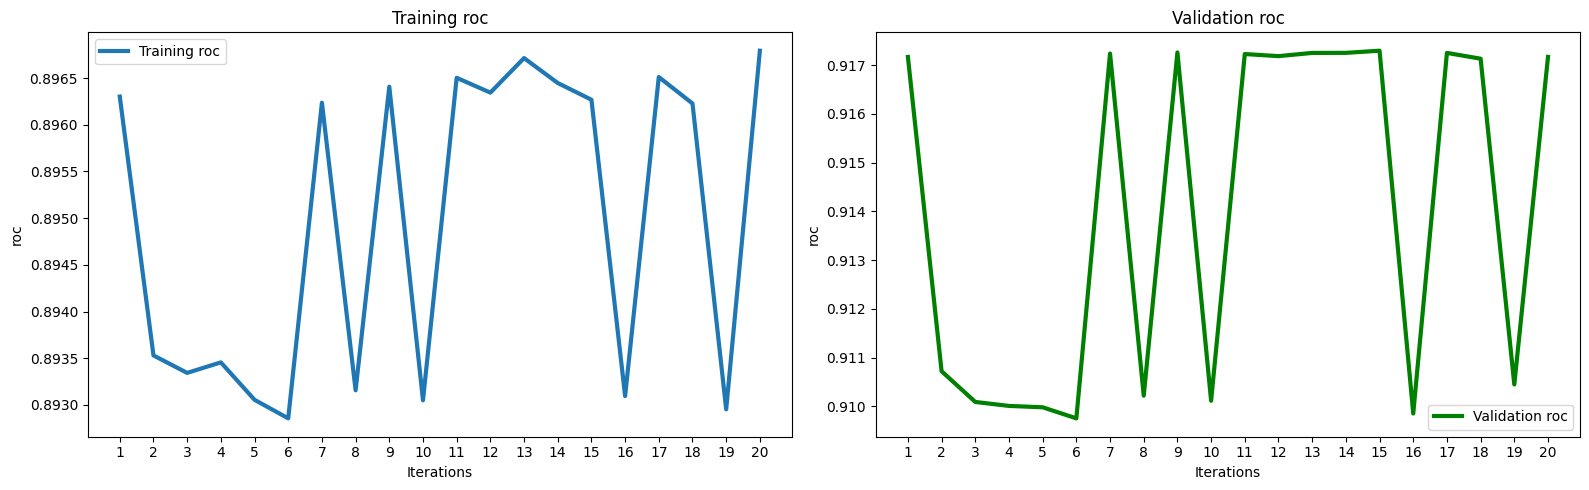

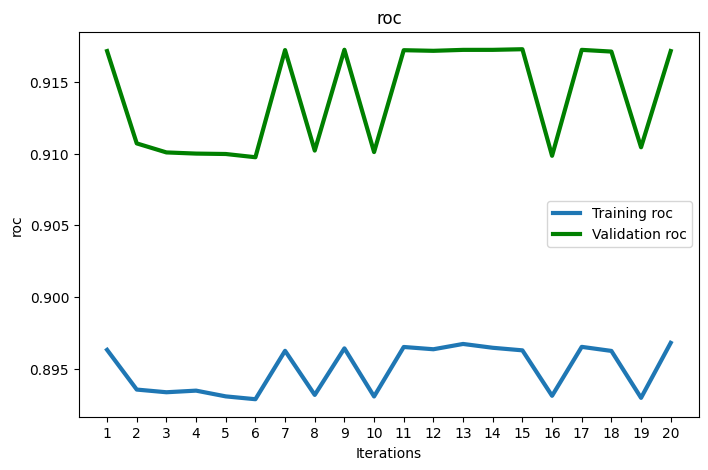

In [111]:
metrics = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
iterations = list(training_evaluations.keys())

for metric in metrics:
    # Create subplots for Training and Validation
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot Training Metric
    training_results = [training_evaluations[i][metric] for i in iterations]
    ax1.plot(iterations, training_results, label="Training " + metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training ' + metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)
    ax1.legend()

    # Plot Validation Metric
    validation_results = [test_evaluations[i][metric] for i in iterations]
    ax2.plot(iterations, validation_results, label="Validation " + metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation ' + metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Combined Plot for Training and Validation
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, training_results, label="Training " + metric, linewidth=3)
    plt.plot(iterations, validation_results, label="Validation " + metric, linewidth=3, color='g')
    plt.xticks(iterations)
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

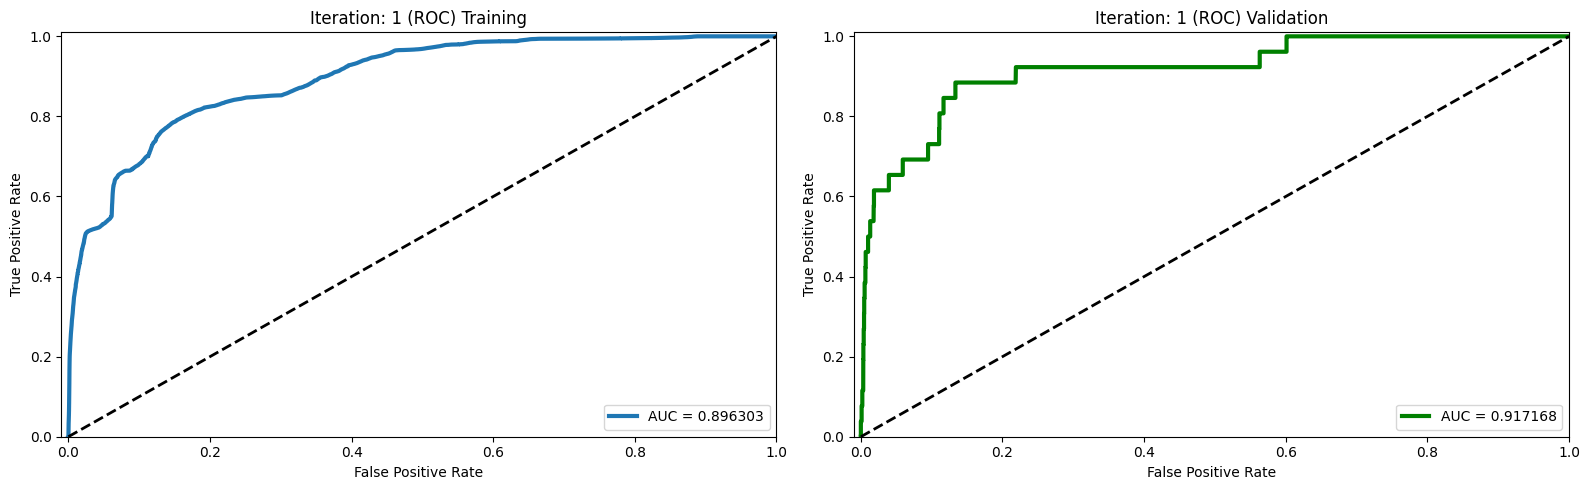

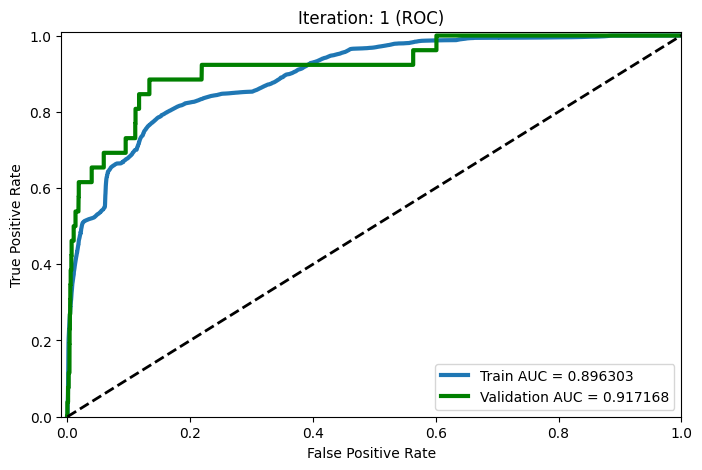

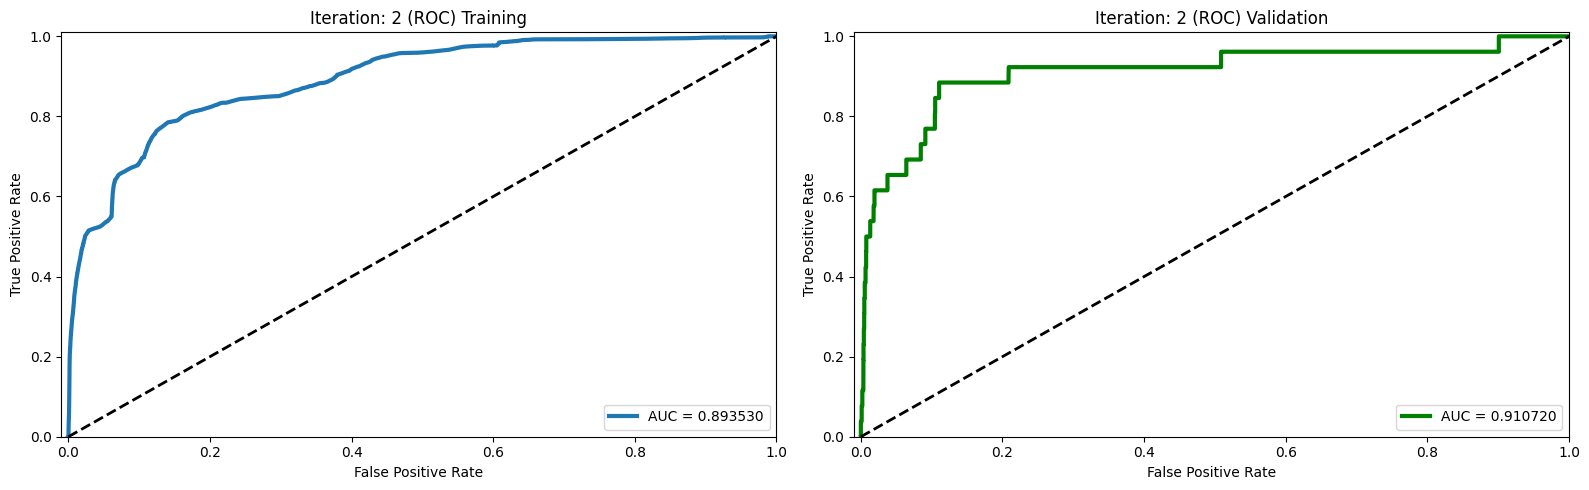

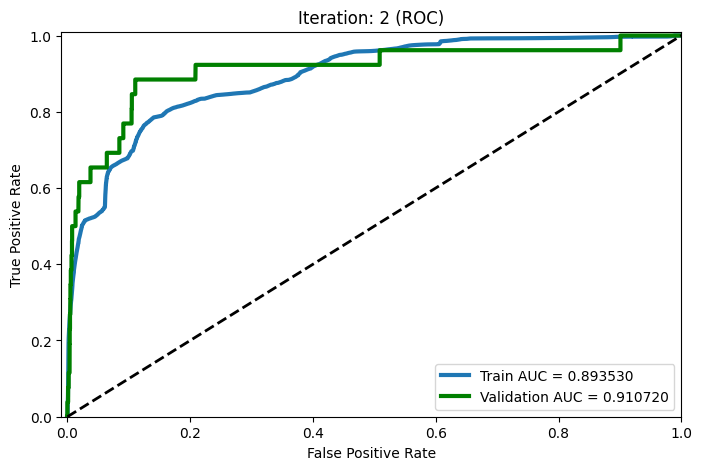

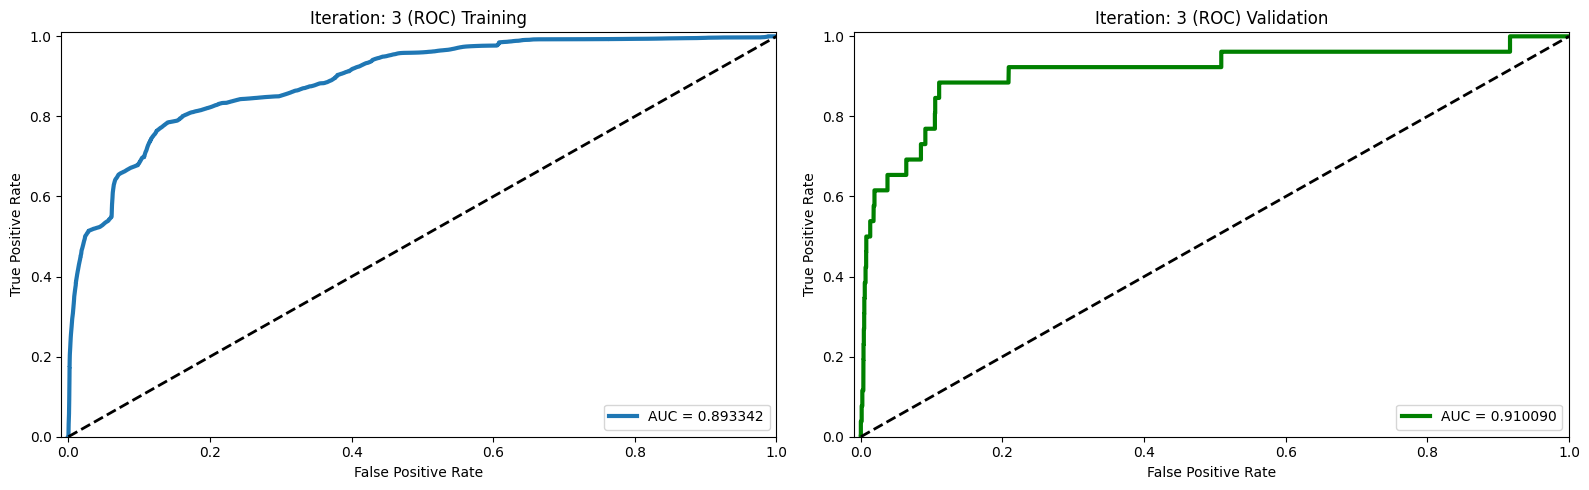

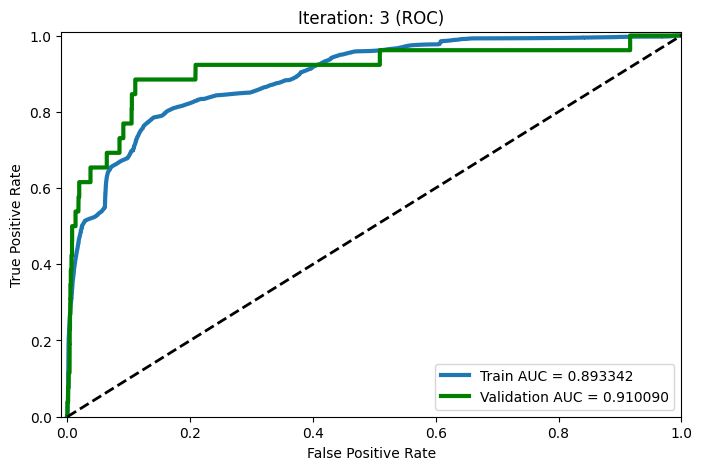

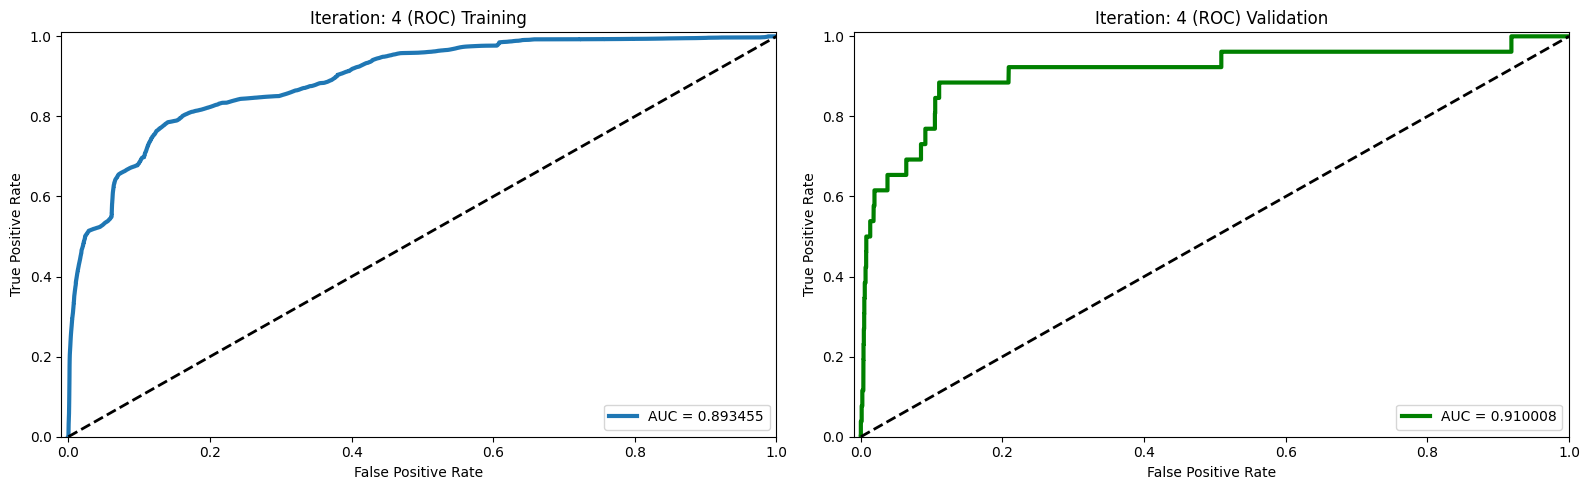

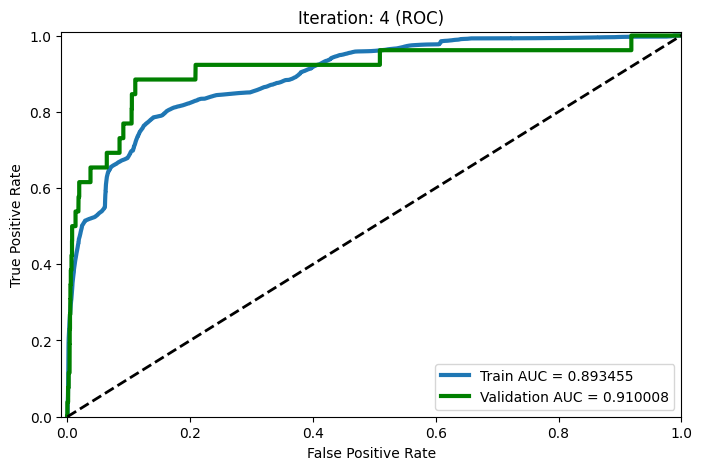

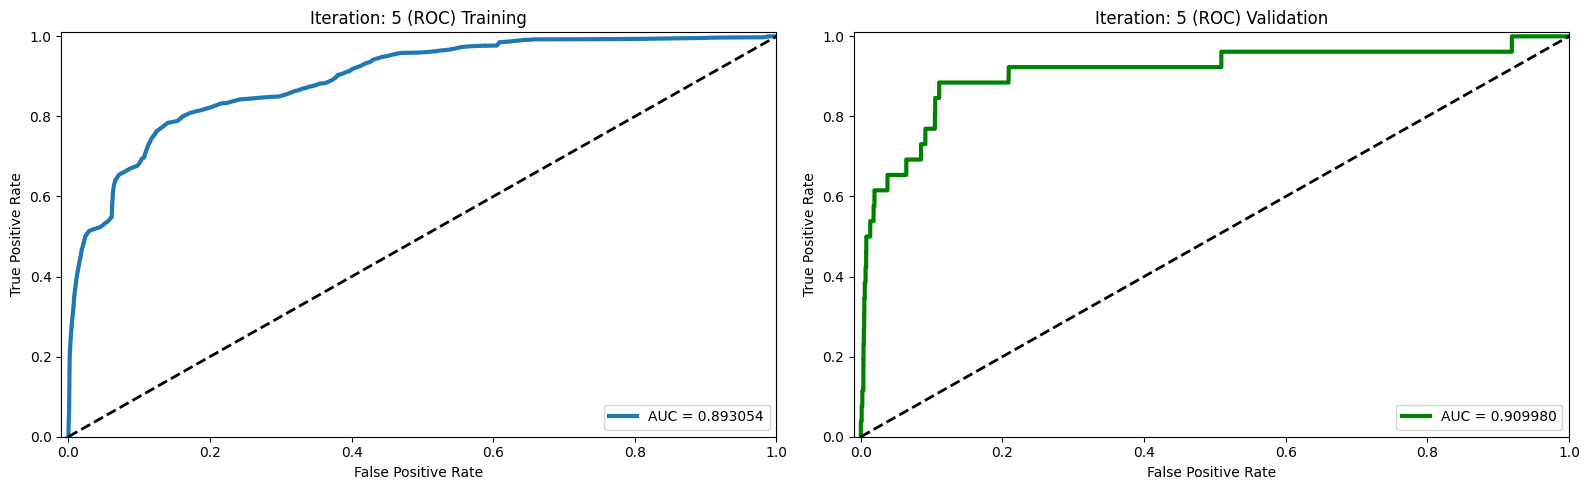

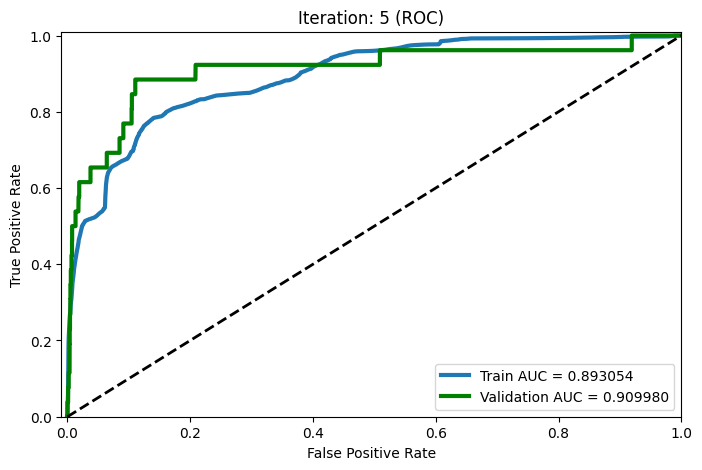

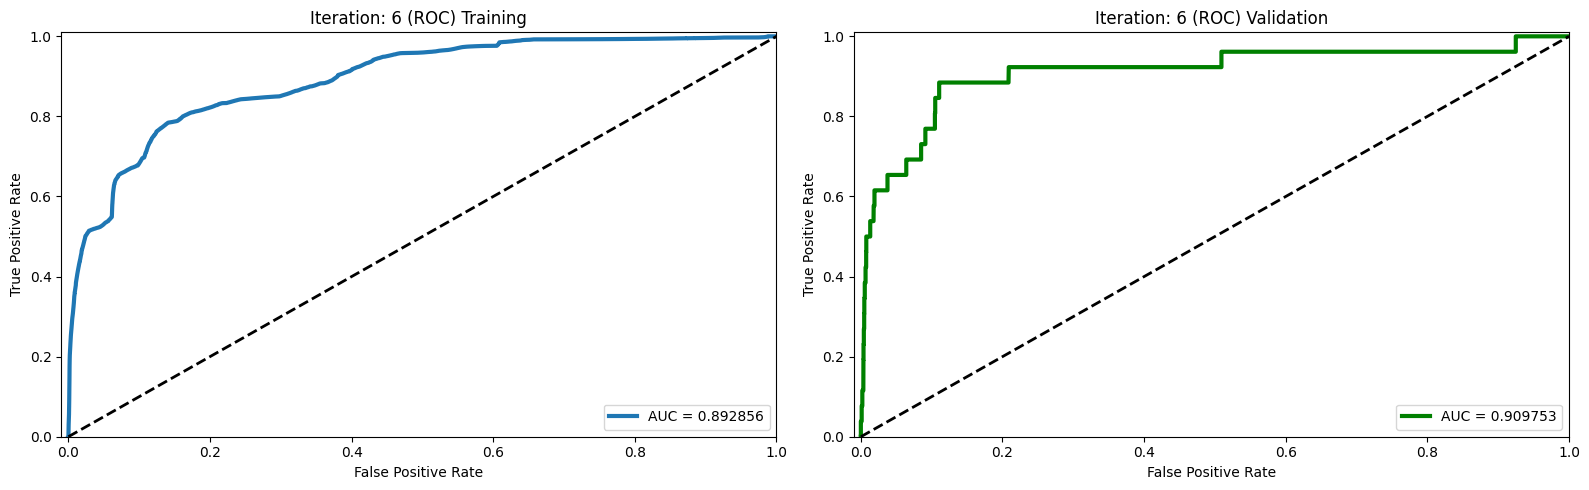

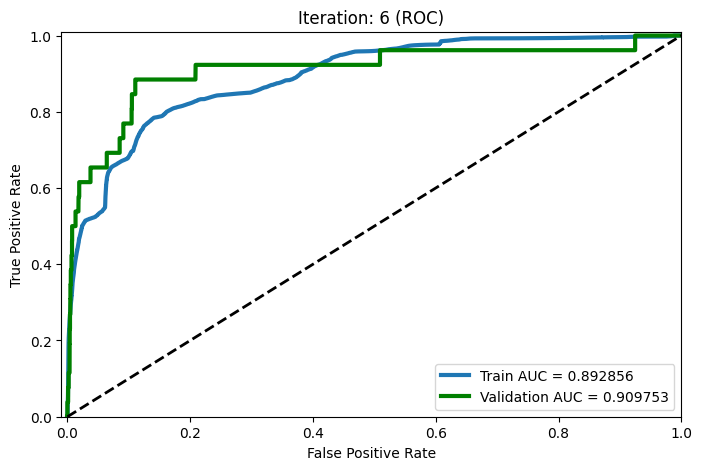

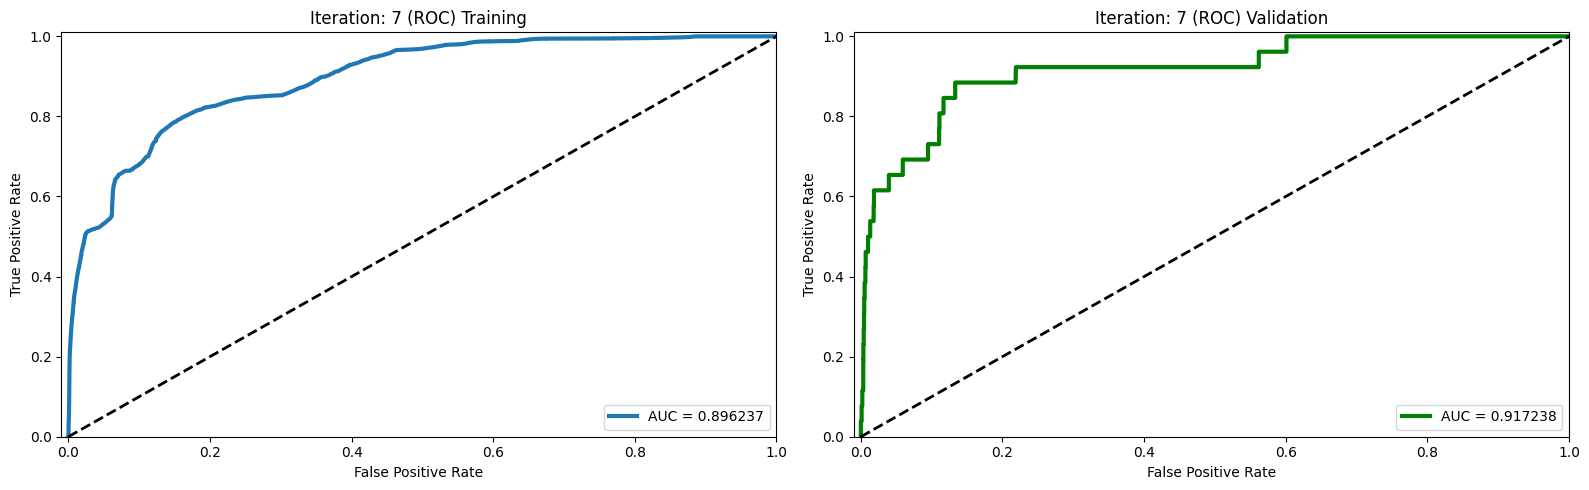

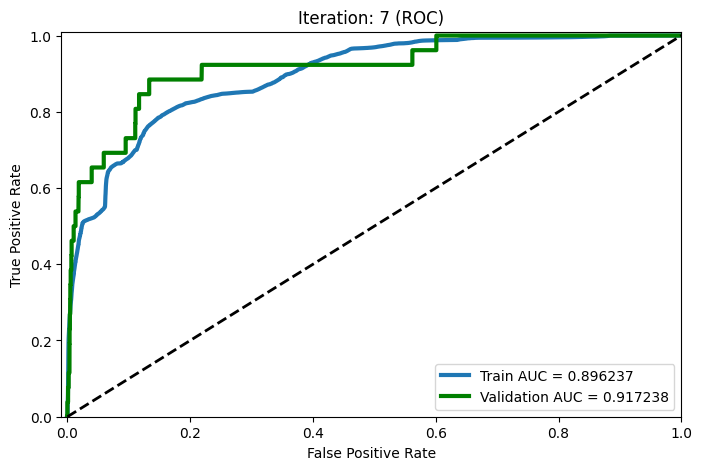

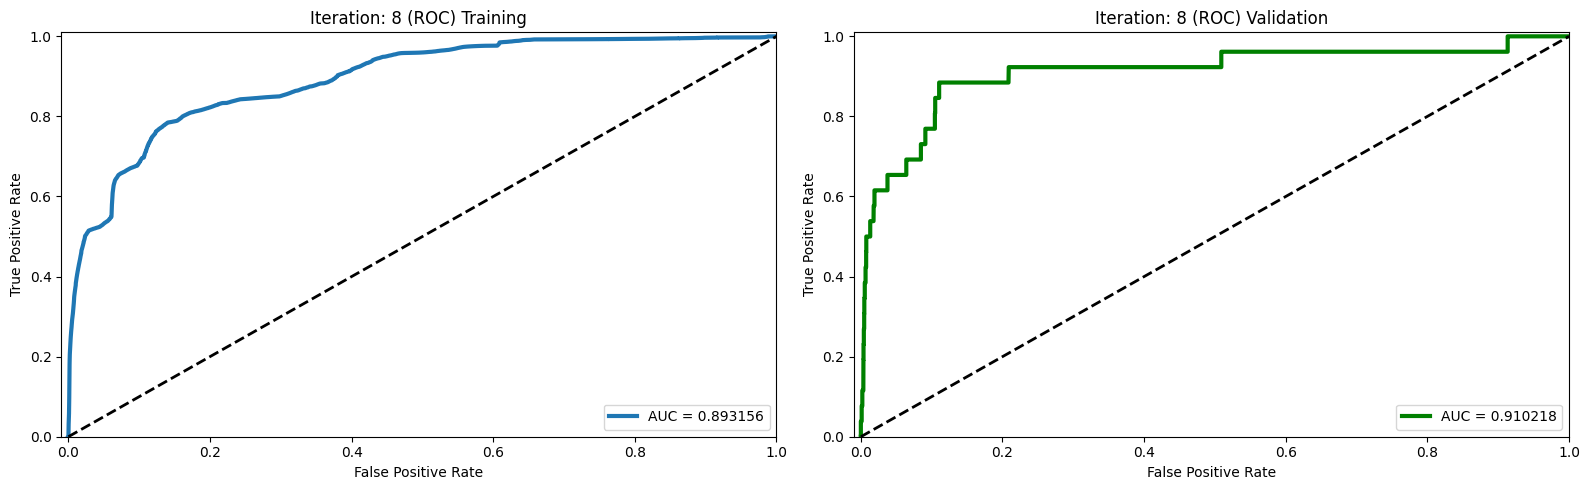

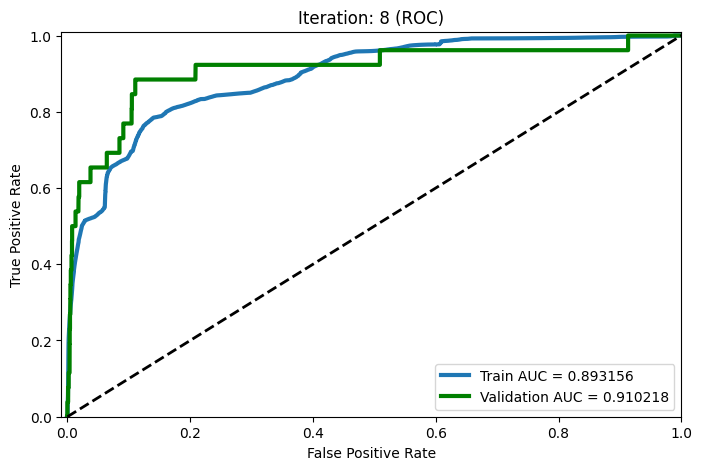

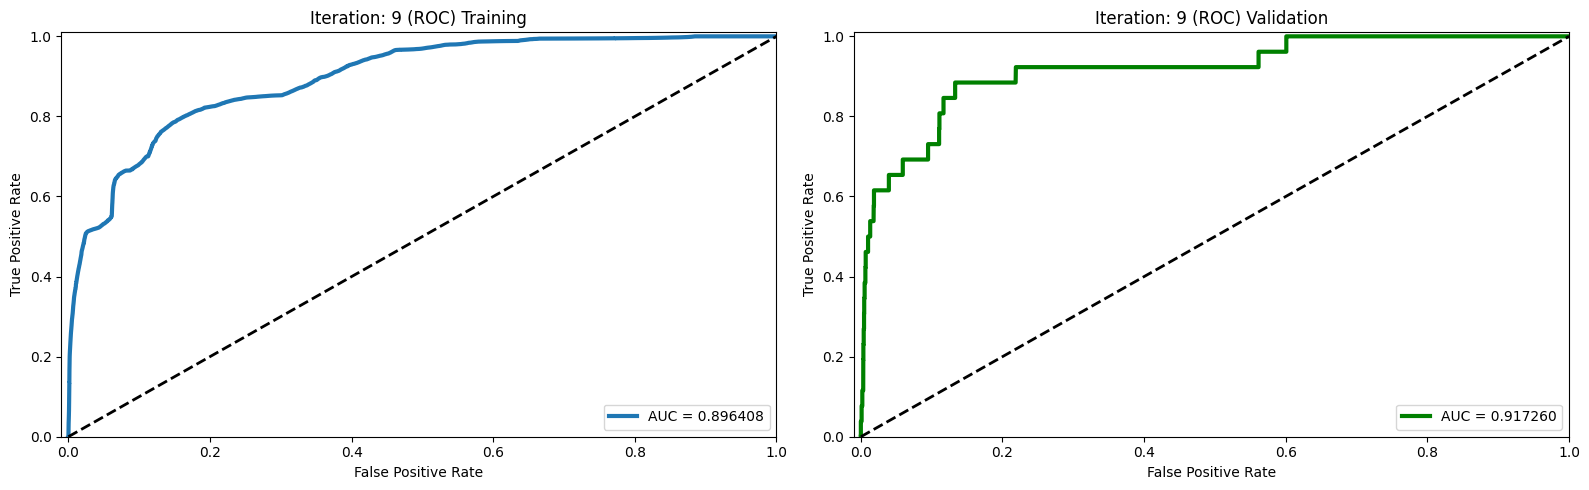

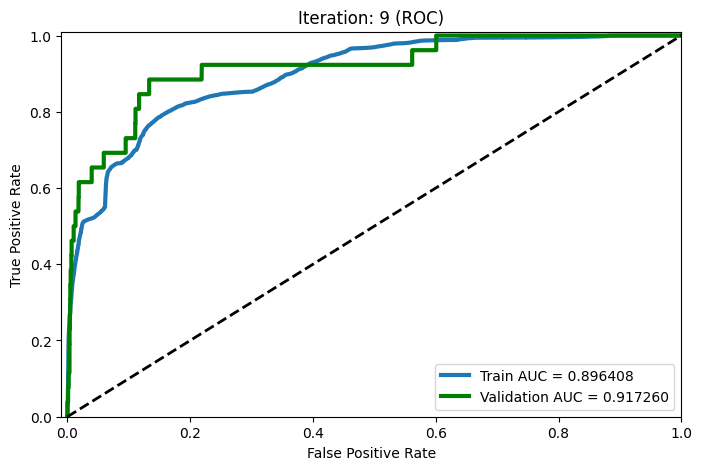

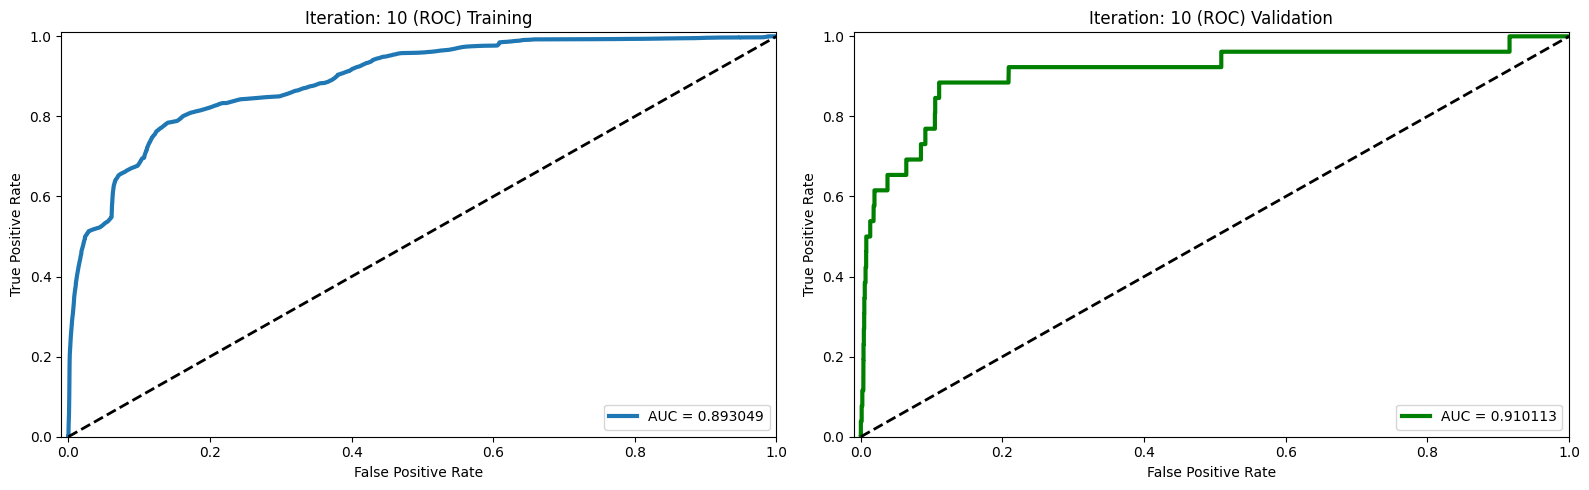

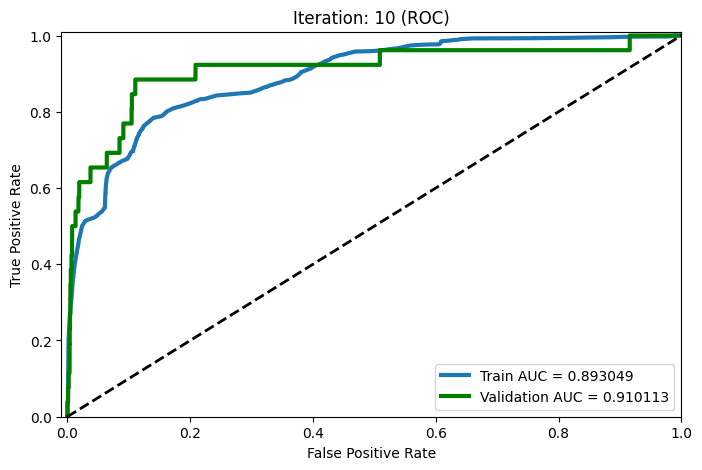

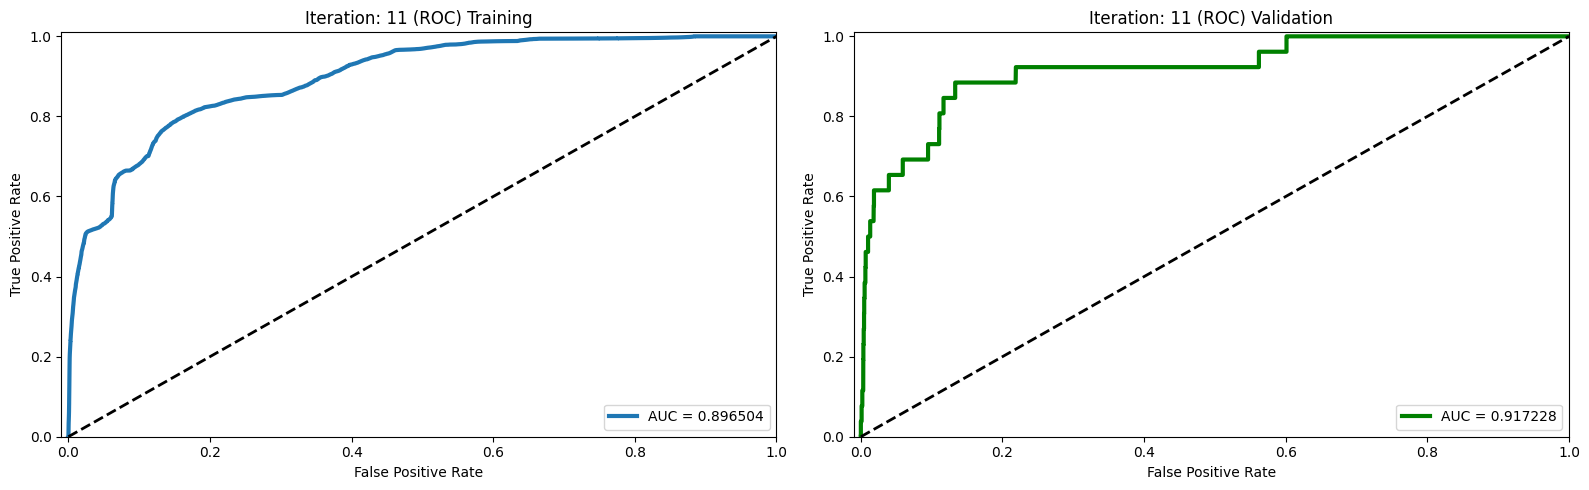

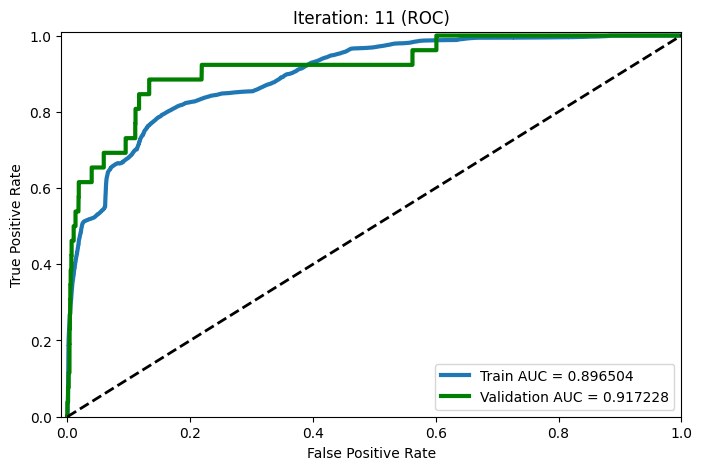

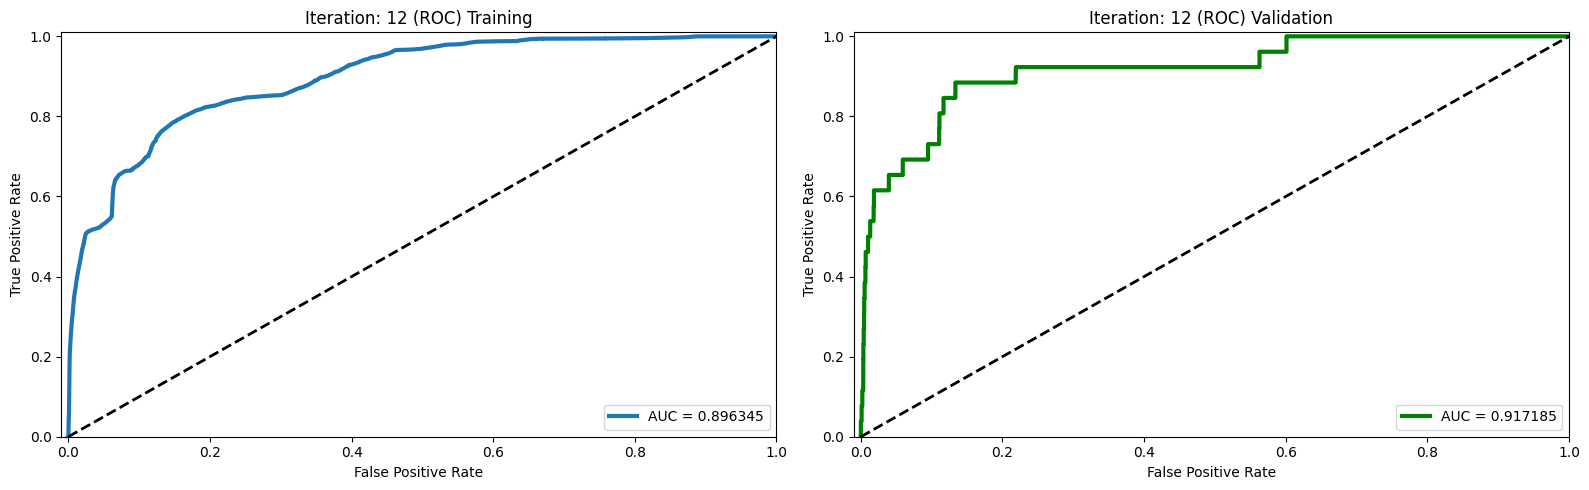

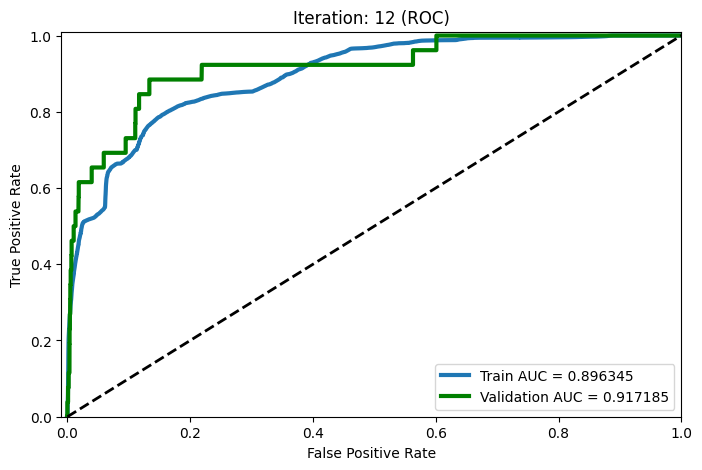

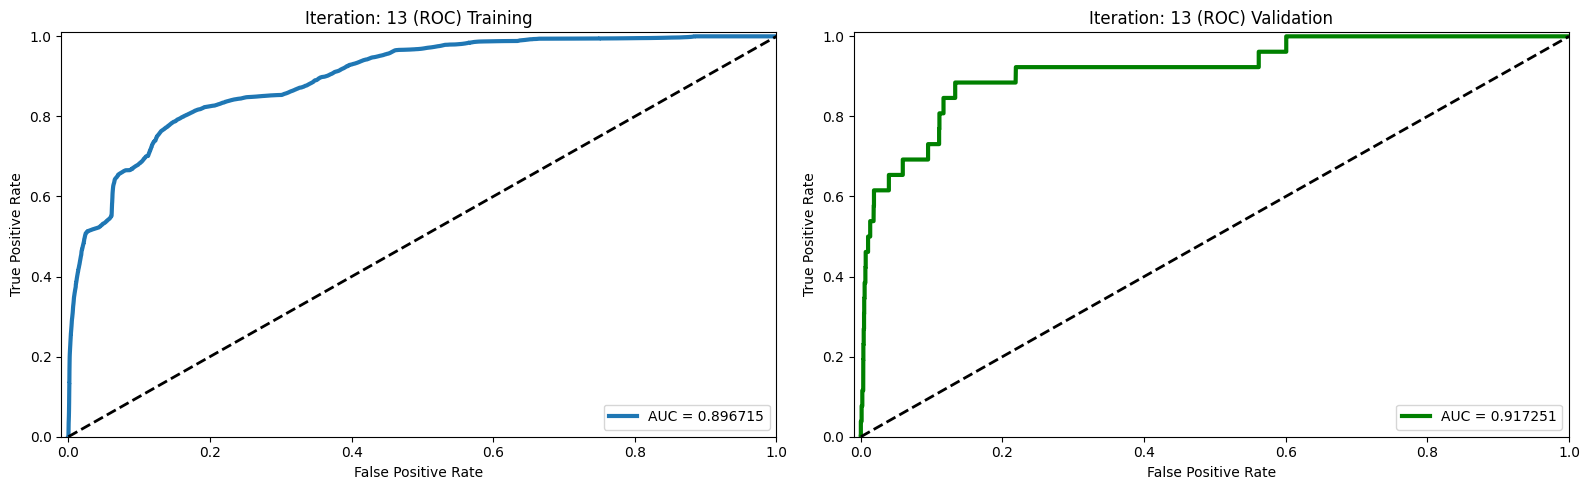

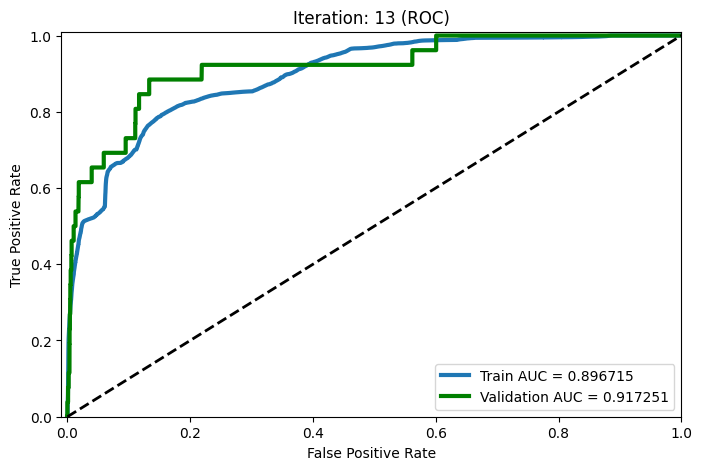

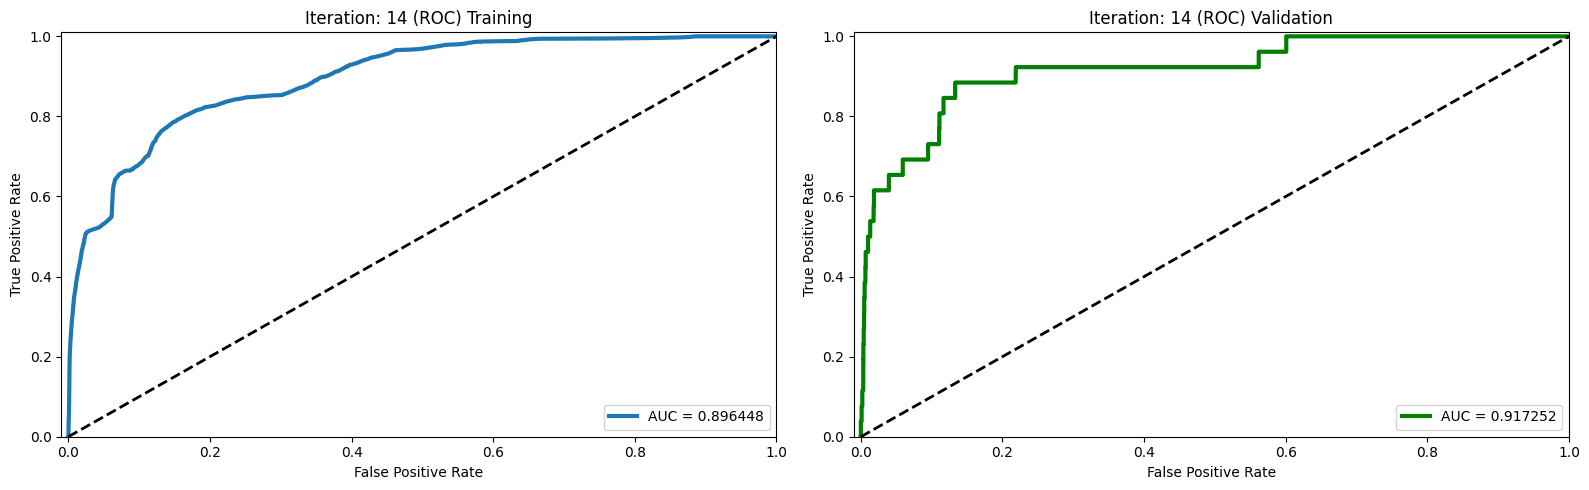

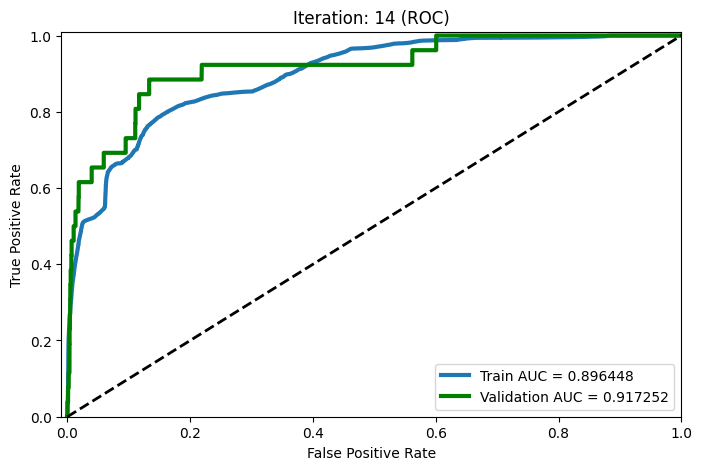

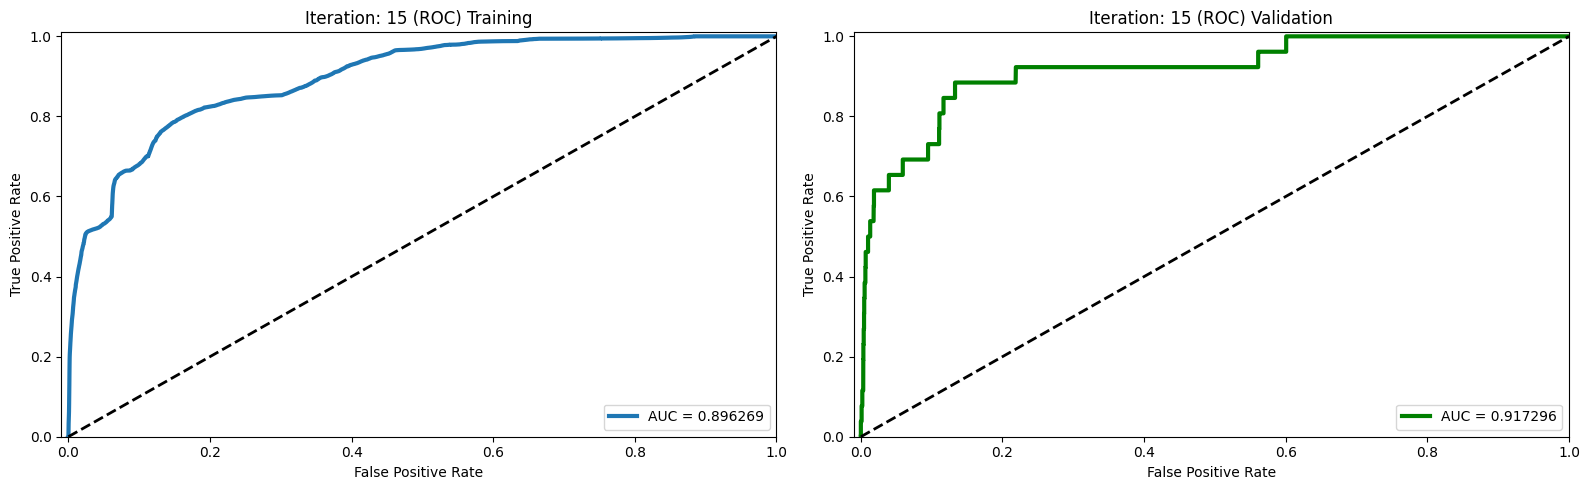

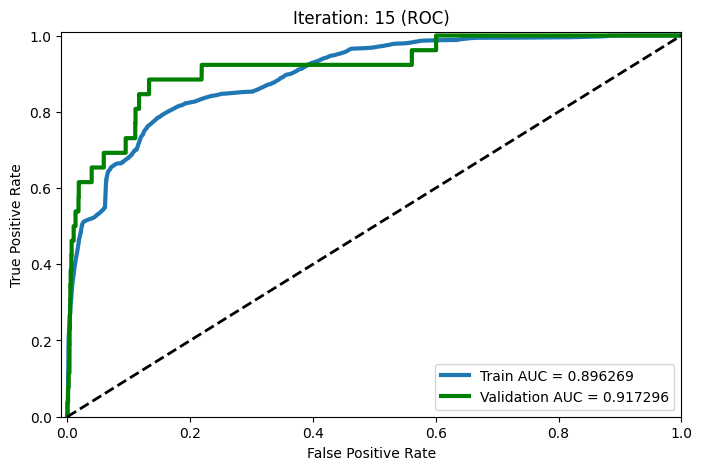

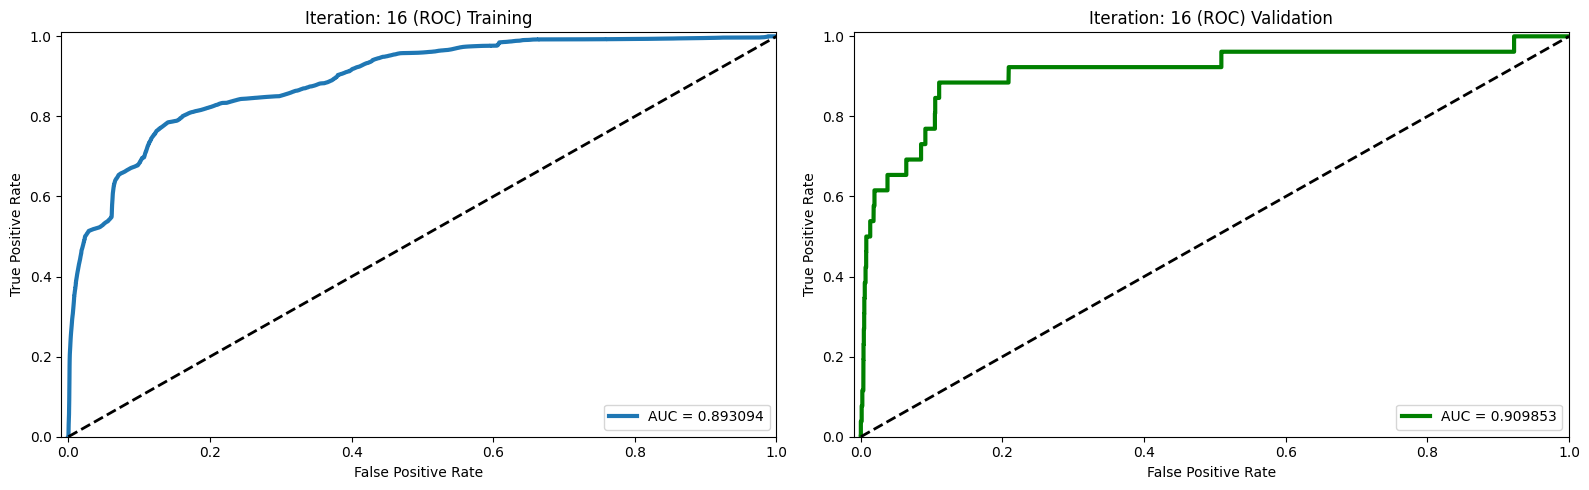

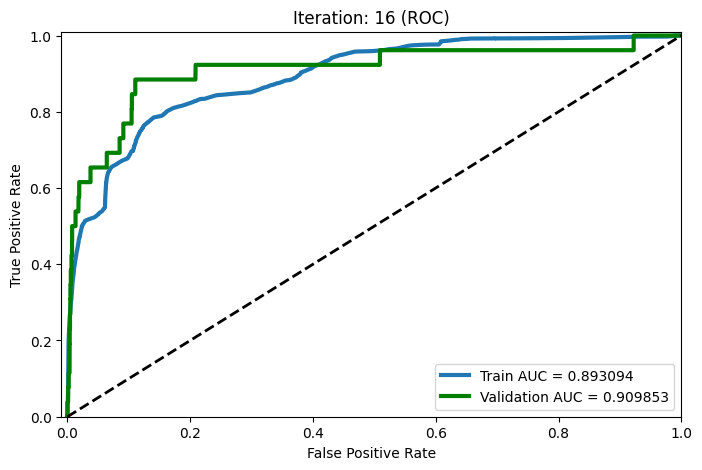

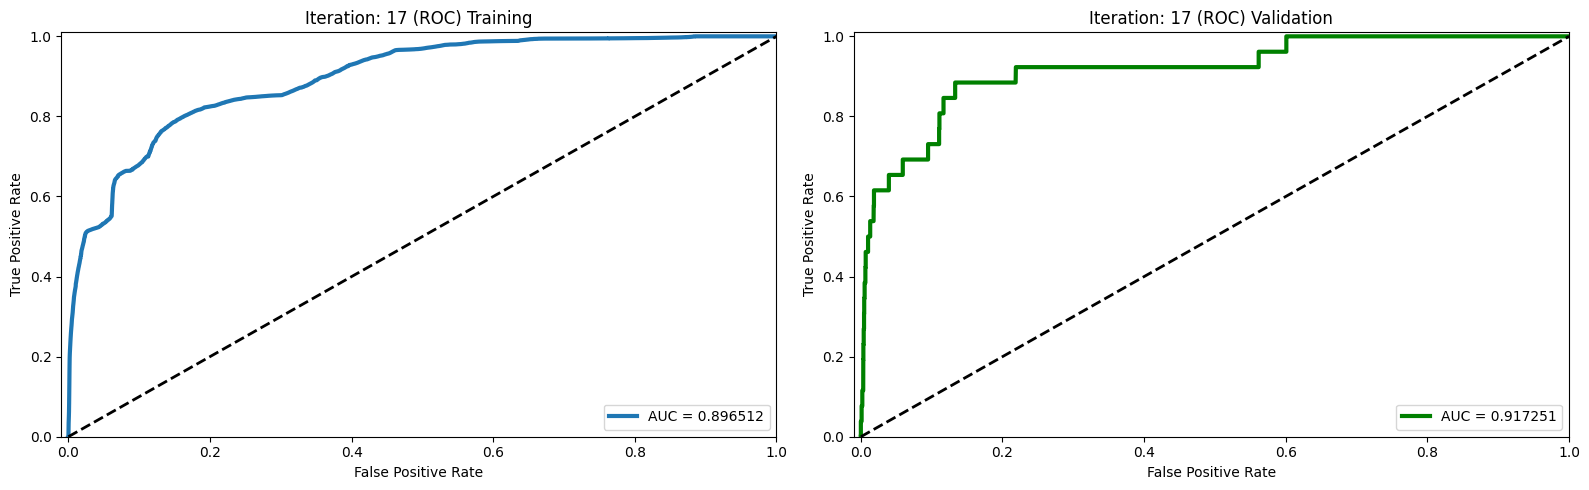

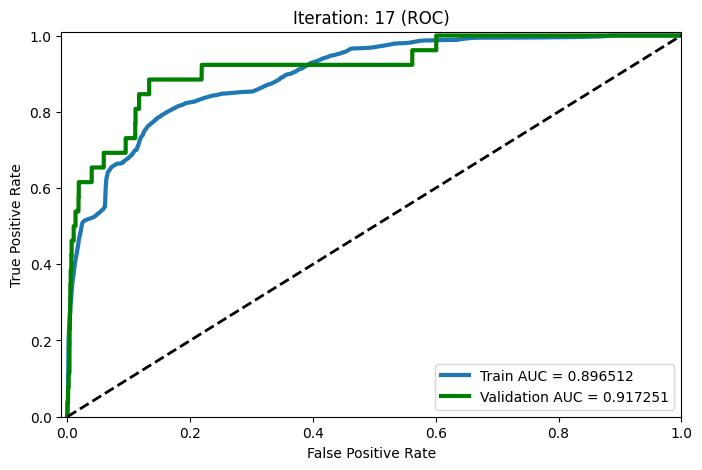

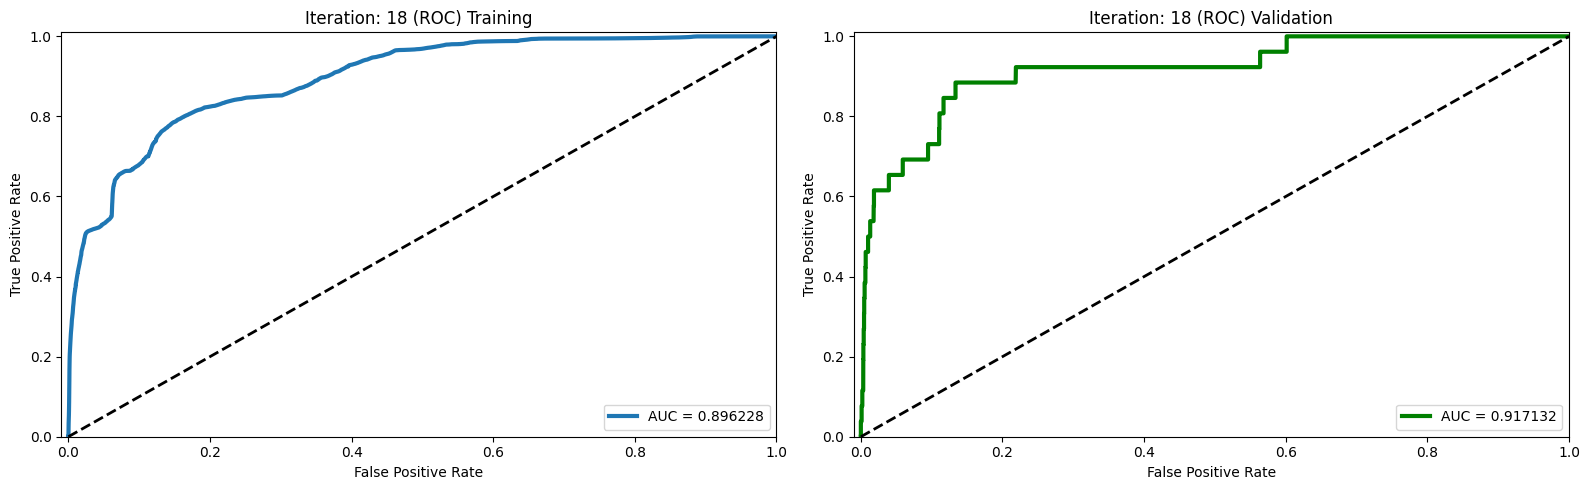

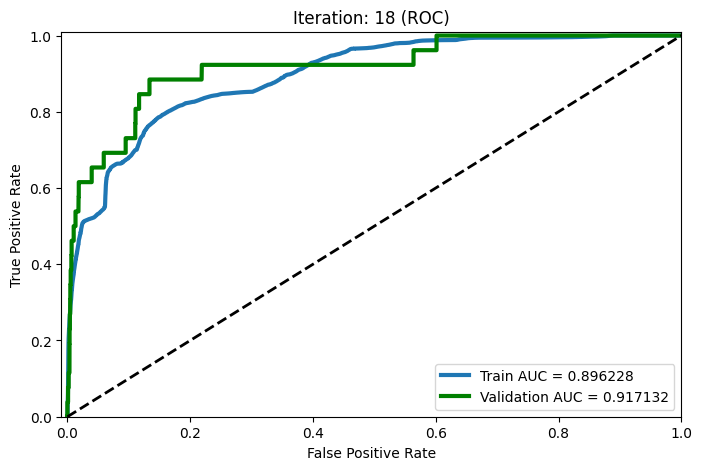

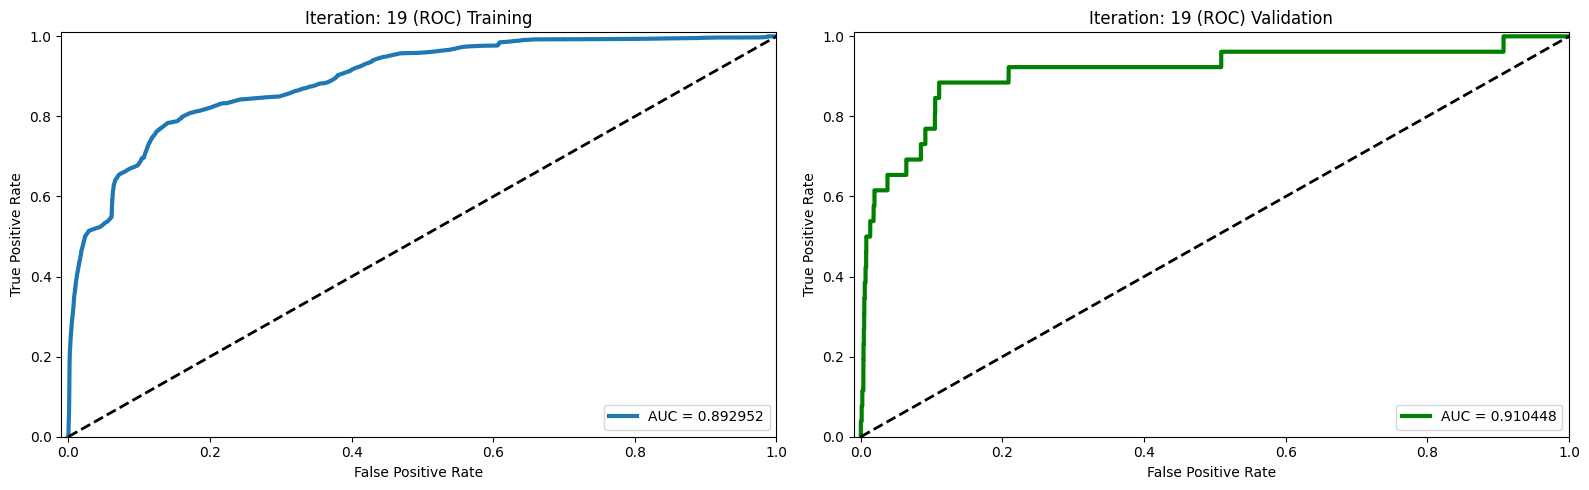

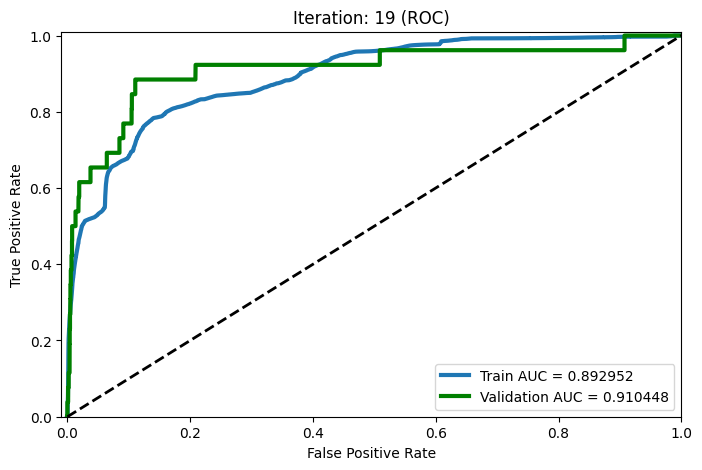

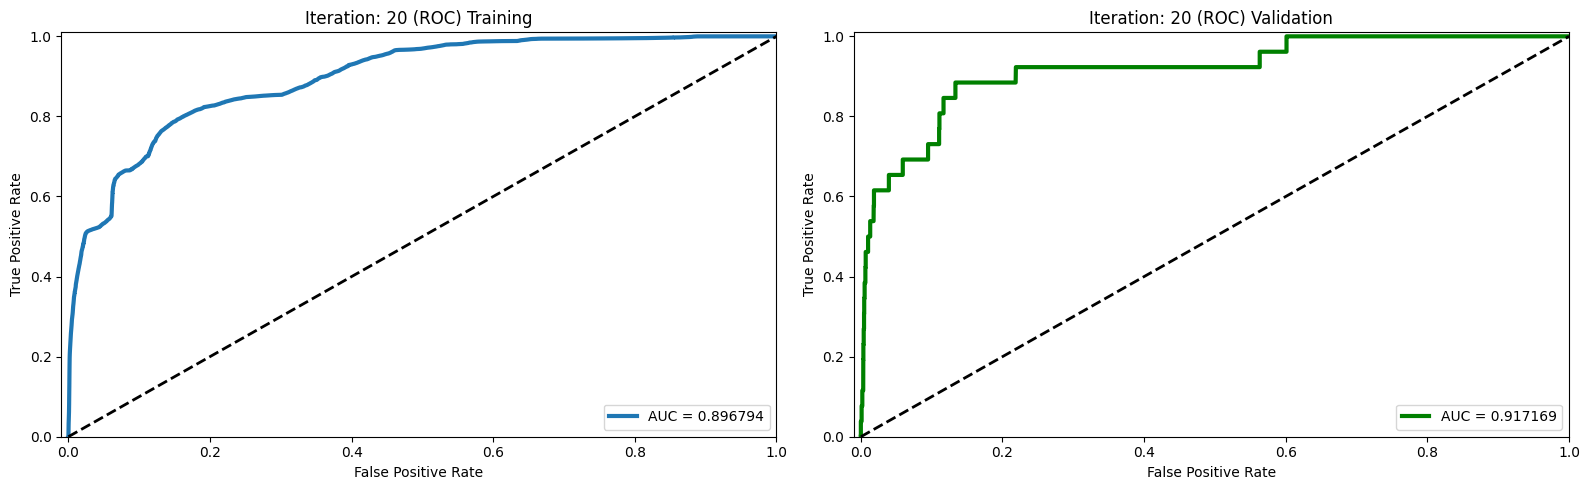

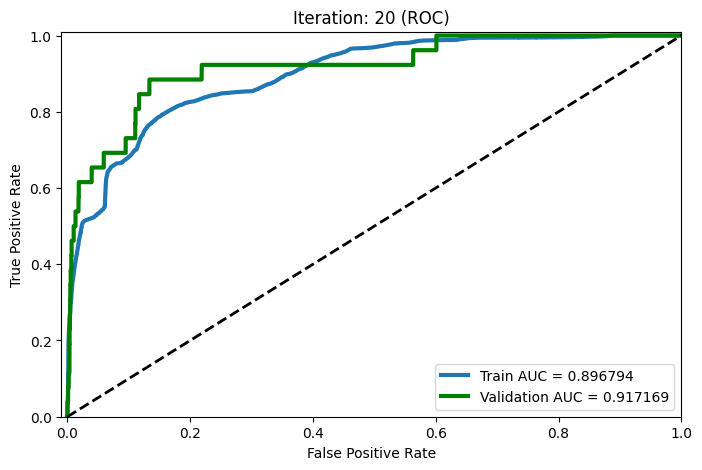

In [112]:
for it in iterations:
    # Training ROC
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    # Validation ROC
    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    # Plot ROC for both Training and Validation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Training ROC
    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label=f'AUC = {roc_auc:.6f}')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title(f'Iteration: {it} (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    # Plot Validation ROC
    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label=f'AUC = {test_roc_auc:.6f}', color='g')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title(f'Iteration: {it} (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.tight_layout()
    plt.show()

    # Combined Plot
    plt.figure(figsize=(8, 5))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label=f'Train AUC = {roc_auc:.6f}')
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label=f'Validation AUC = {test_roc_auc:.6f}', color='g')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title(f'Iteration: {it} (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

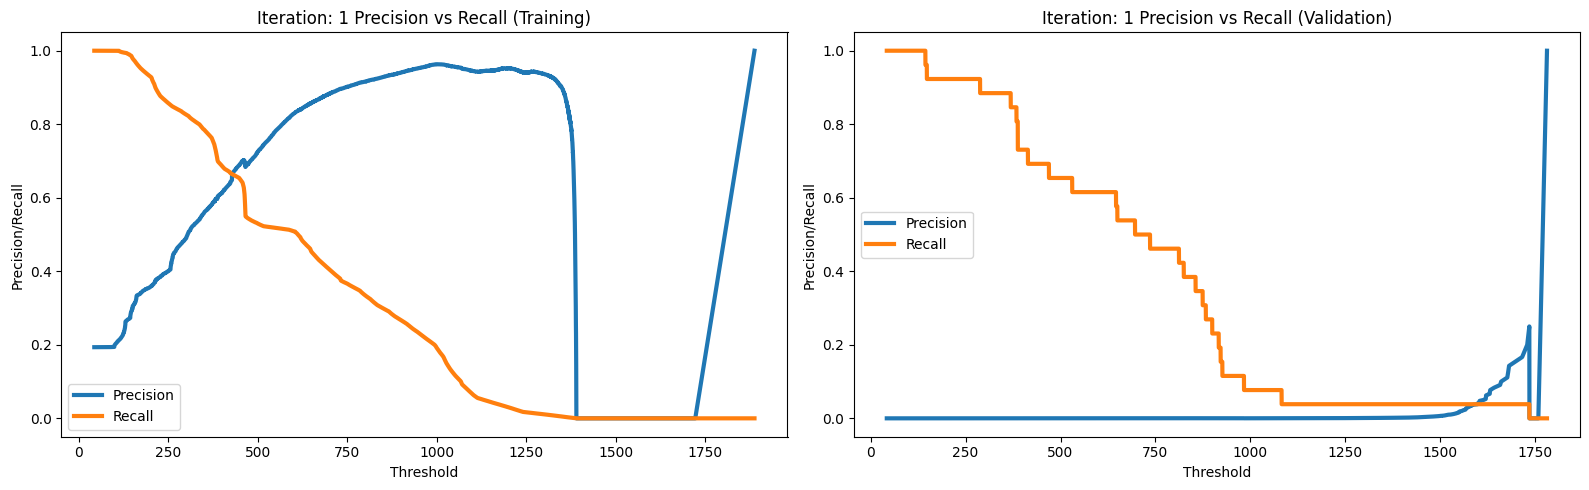

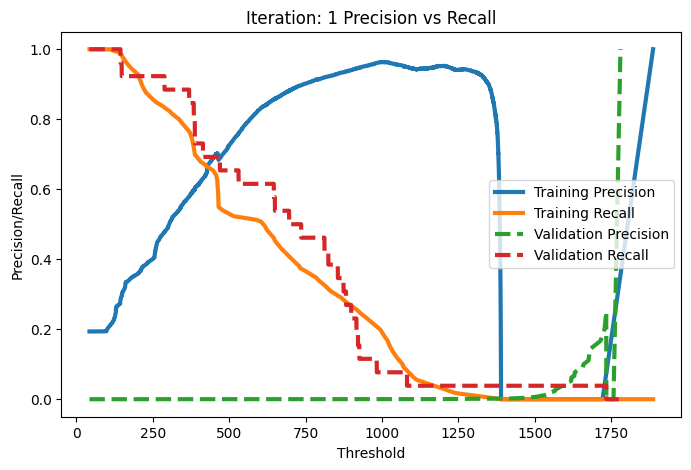

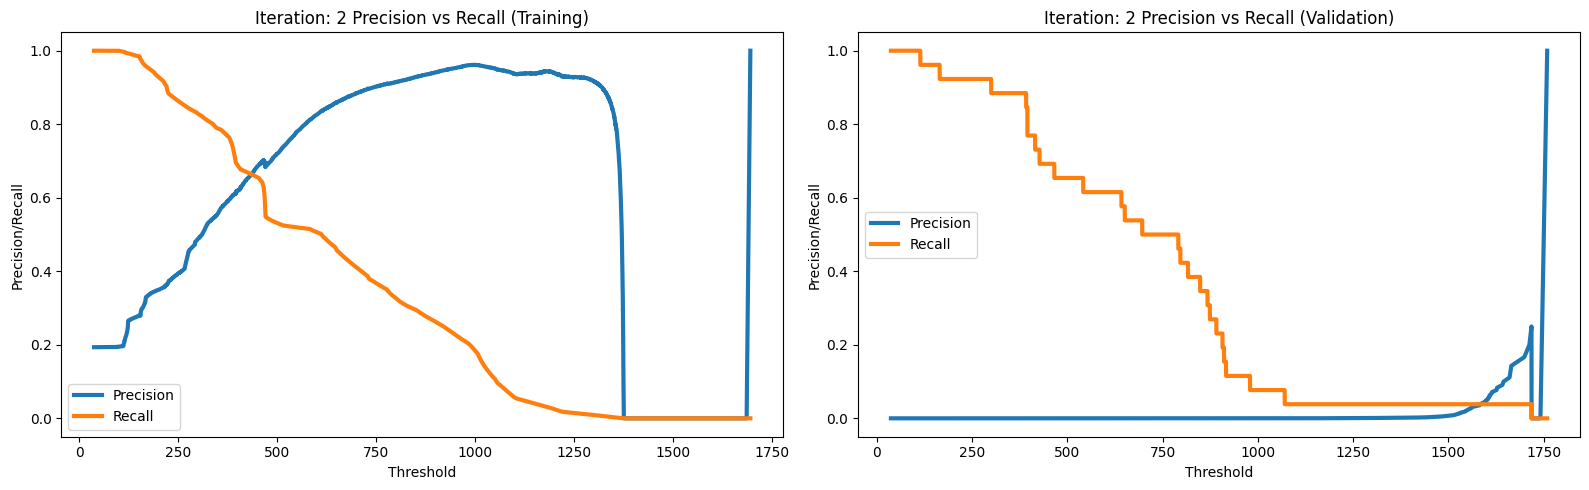

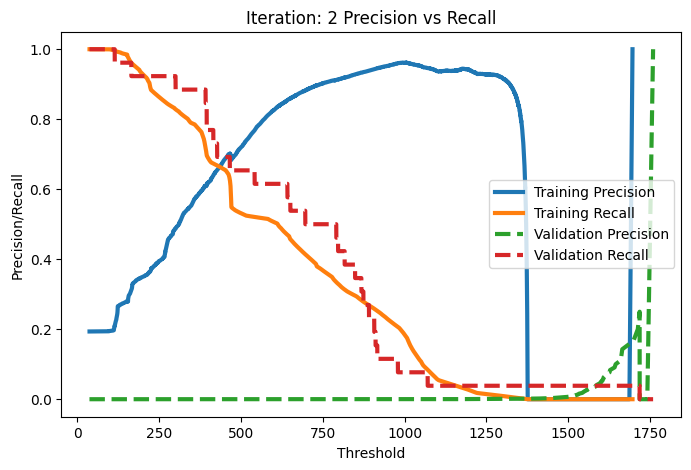

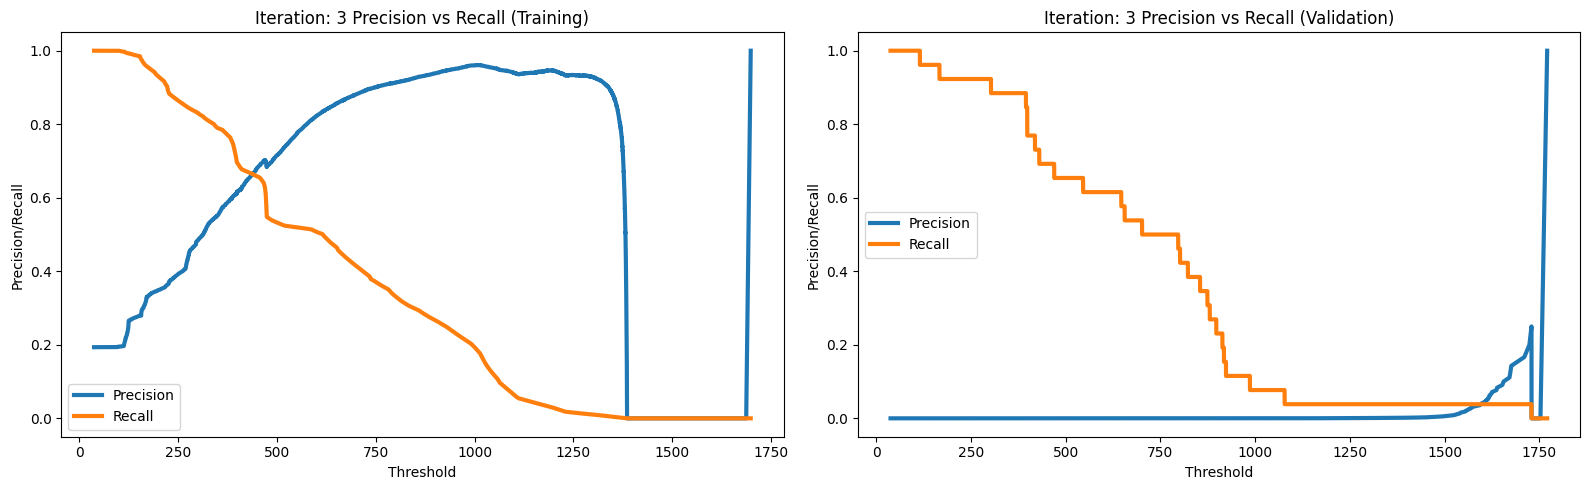

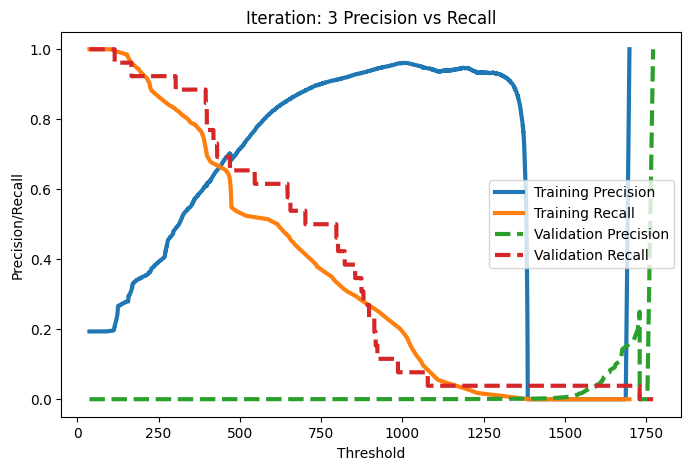

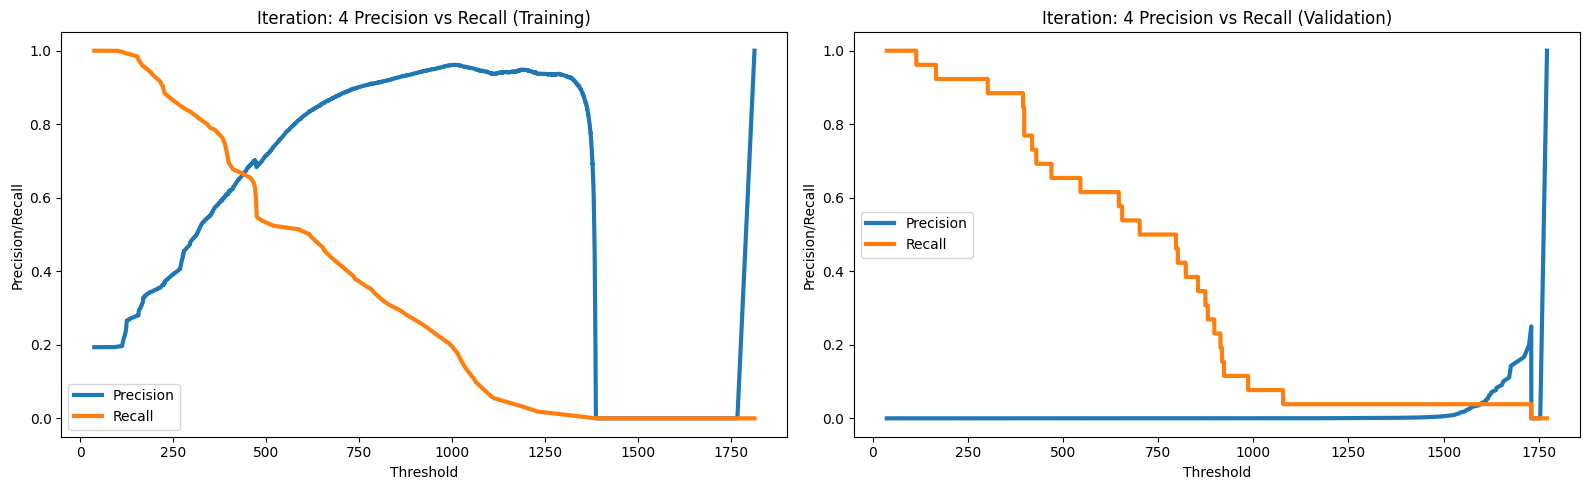

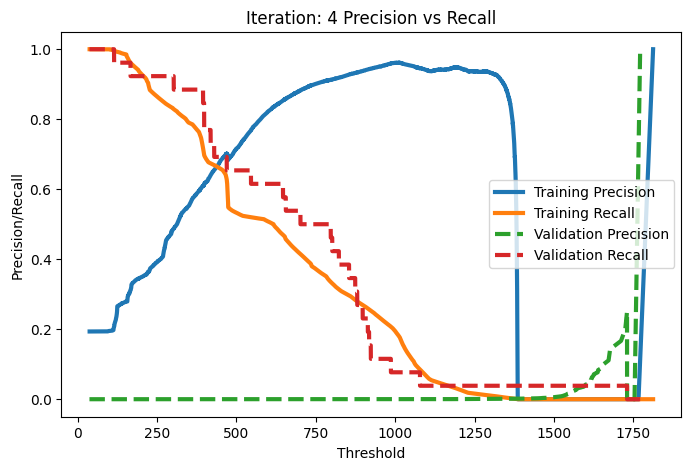

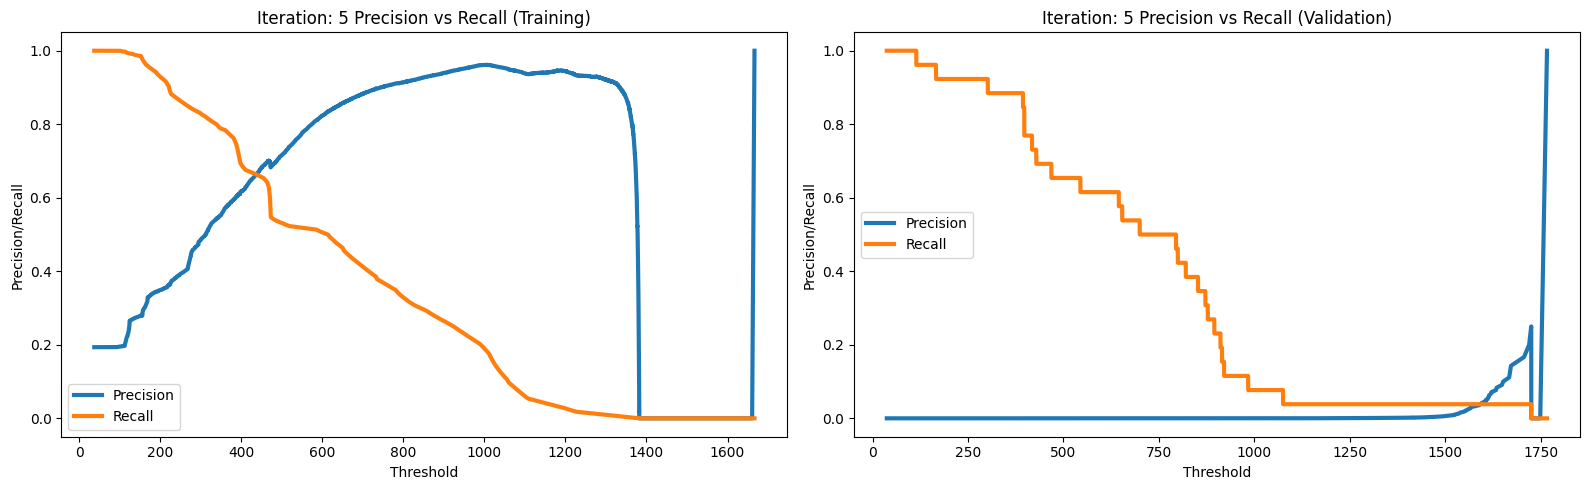

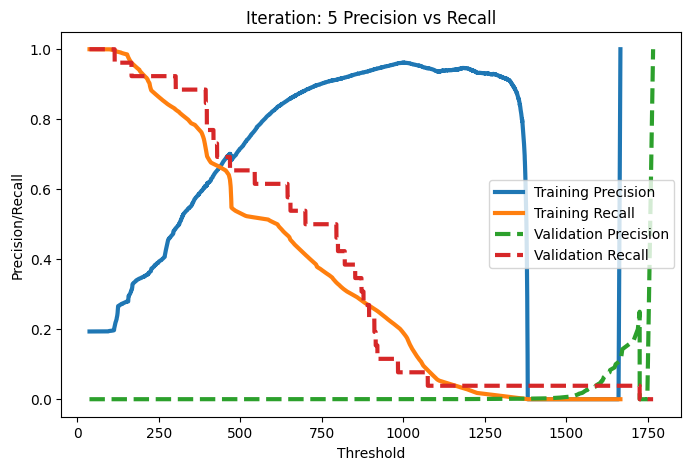

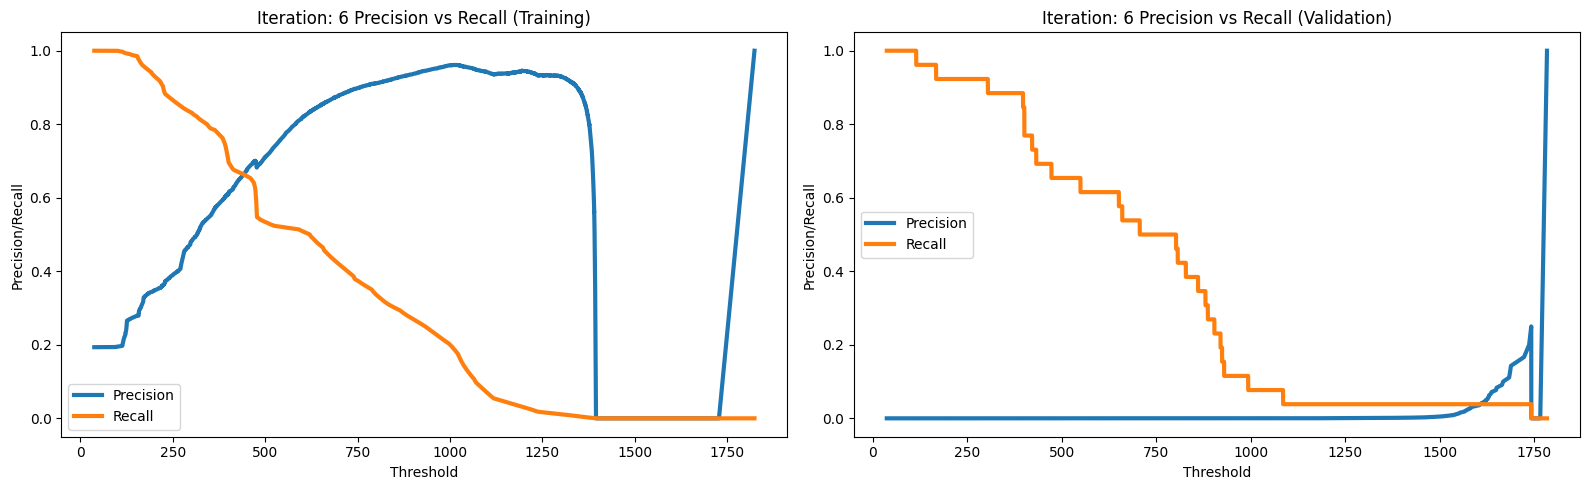

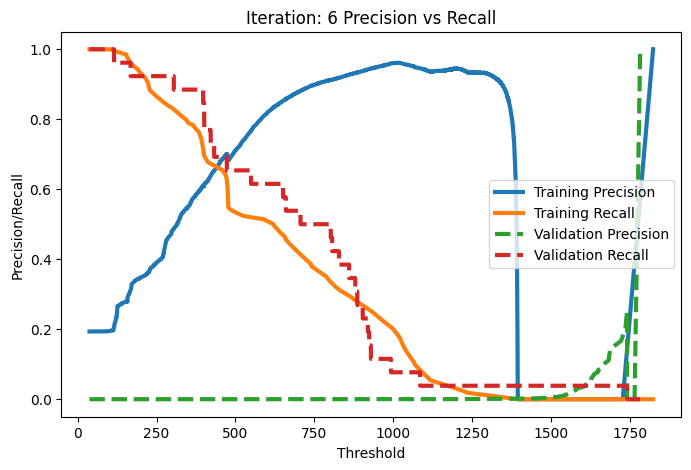

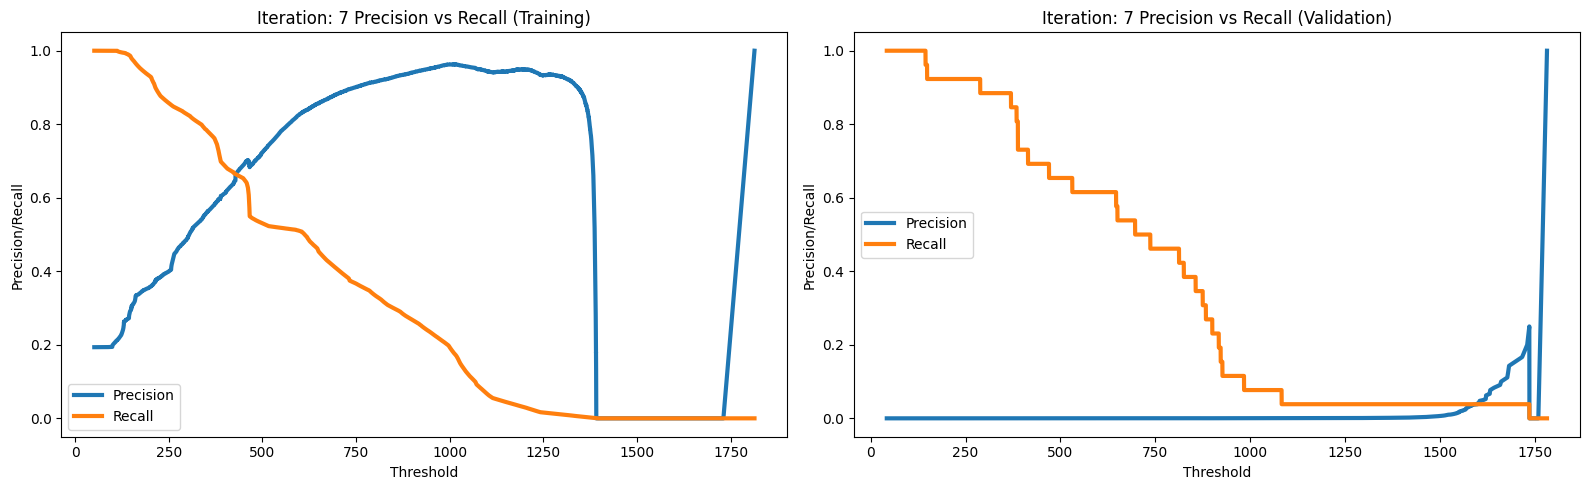

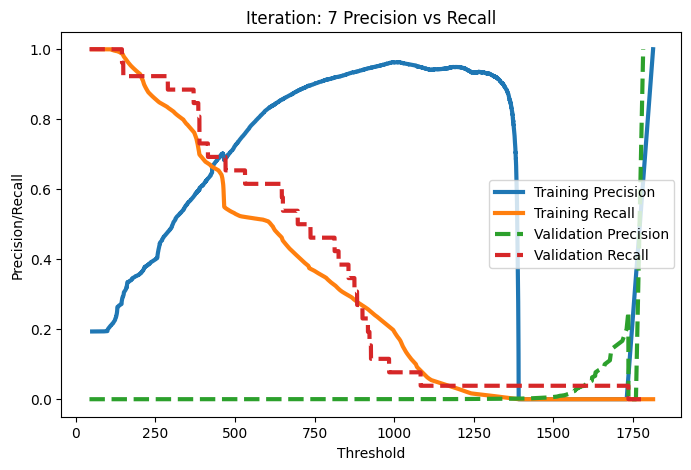

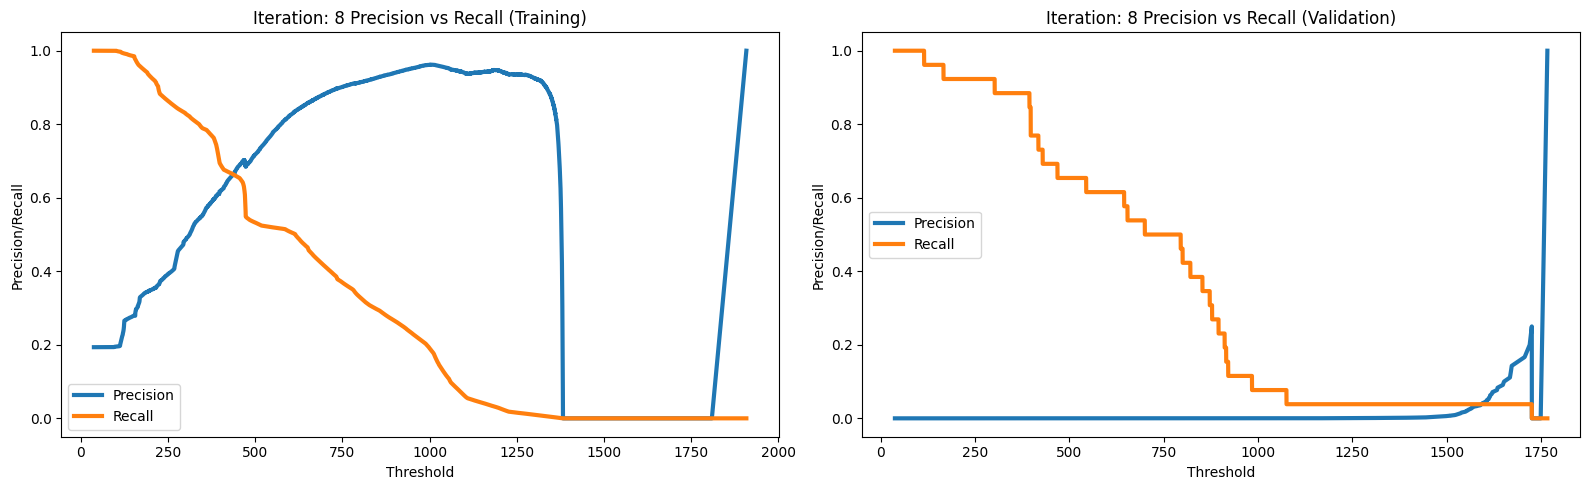

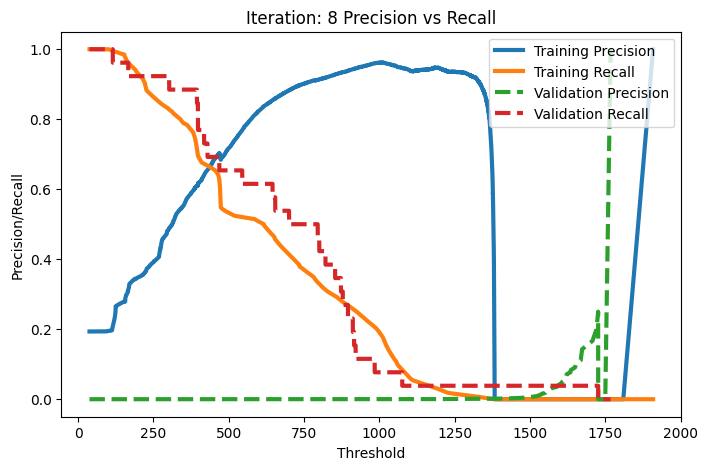

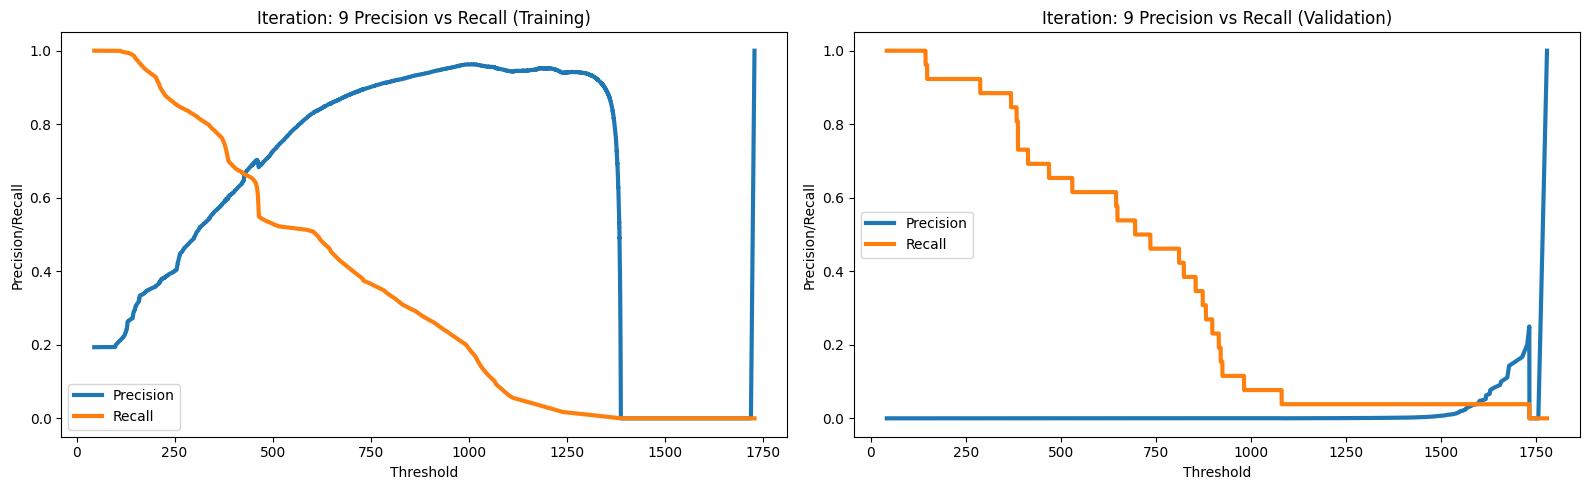

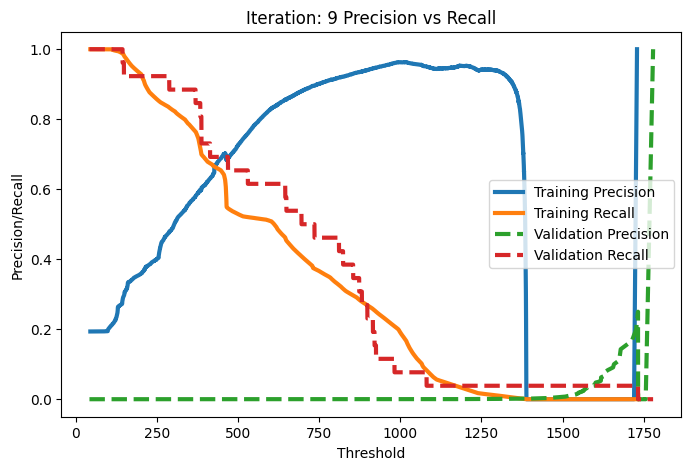

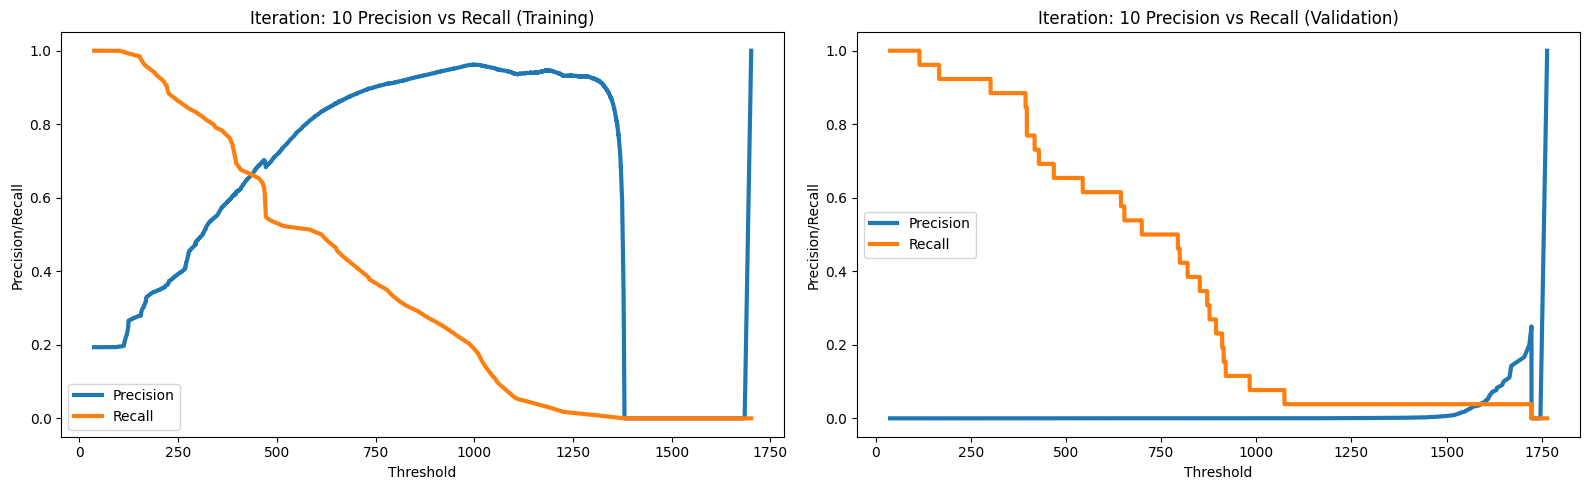

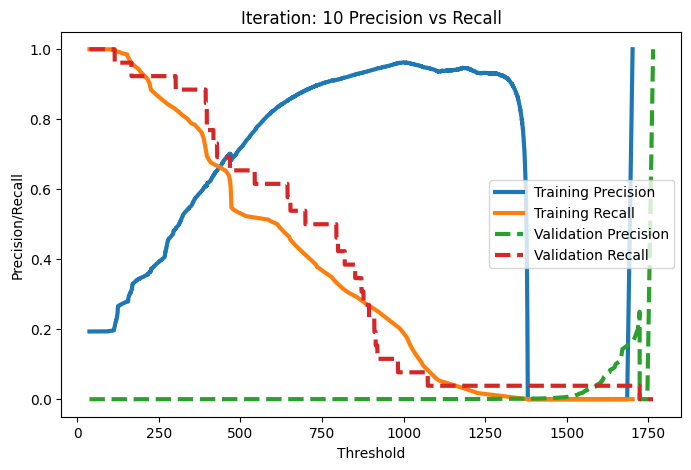

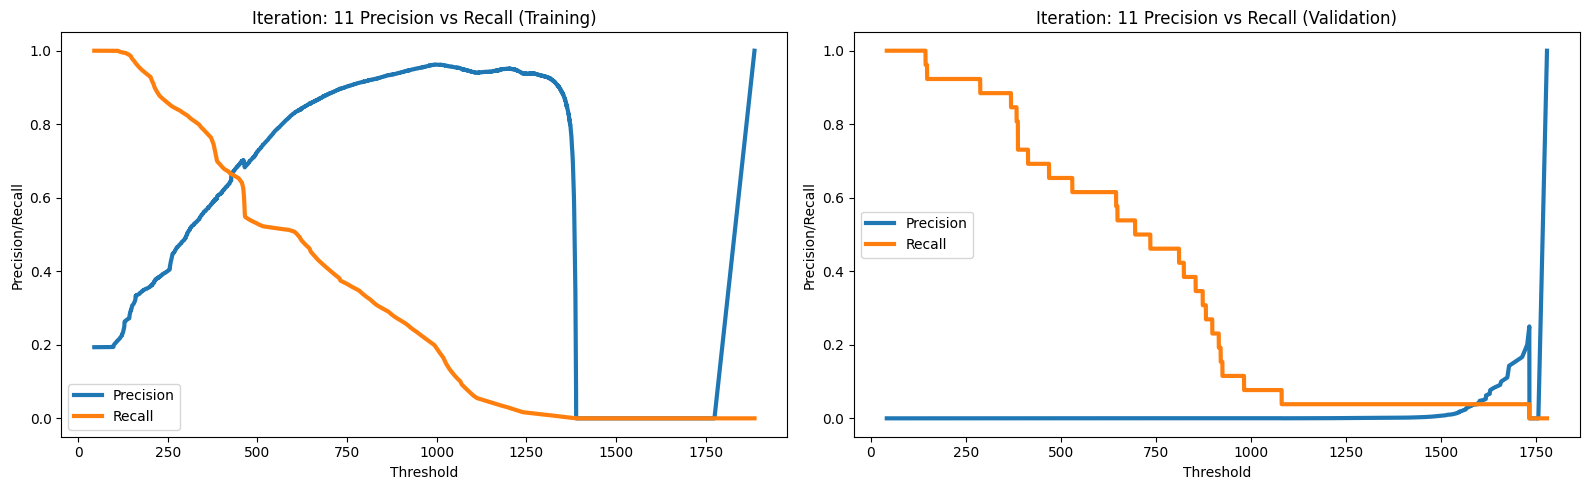

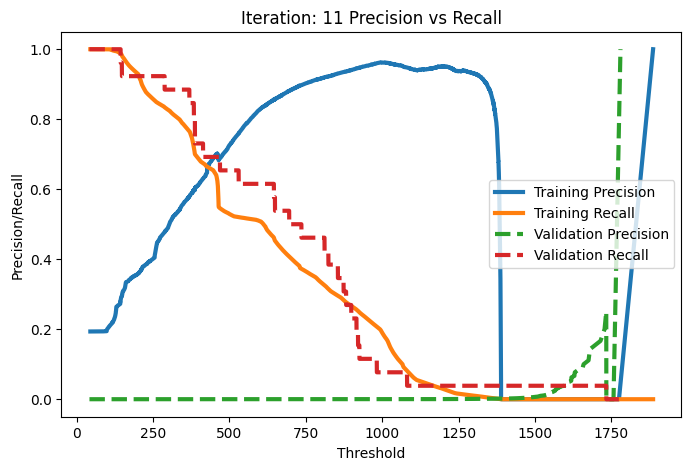

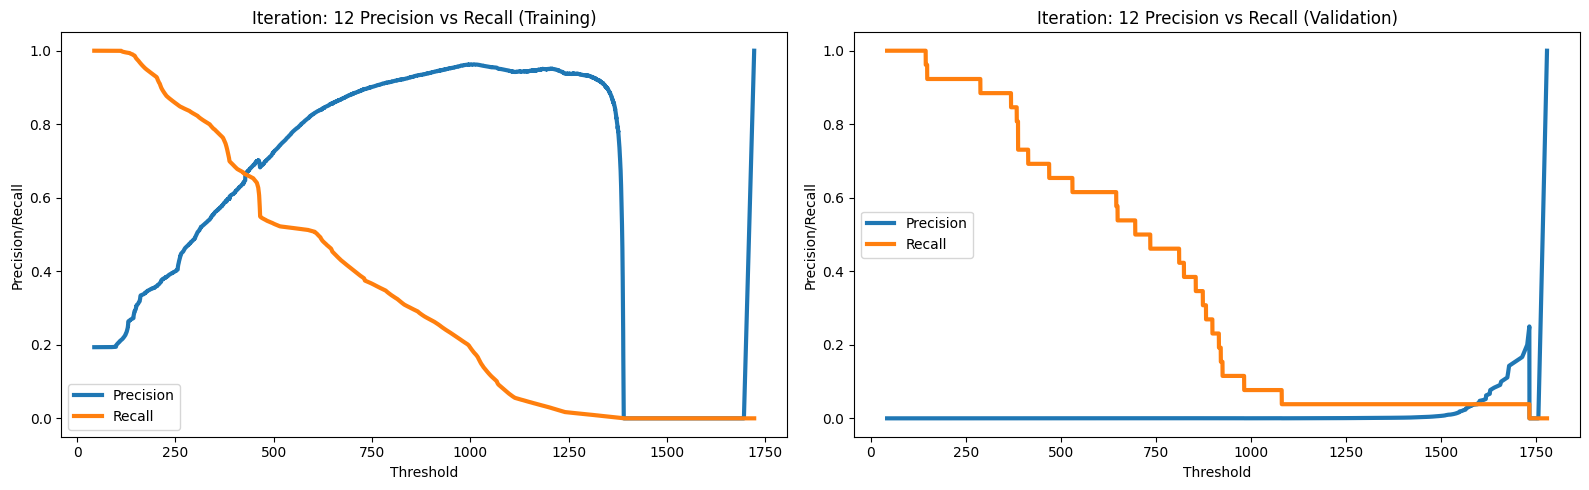

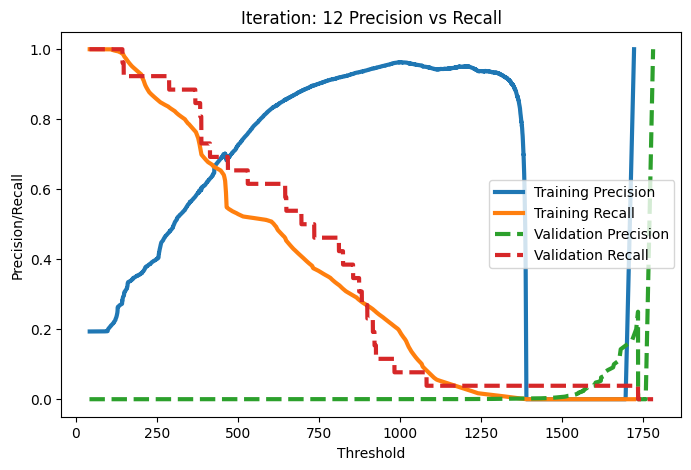

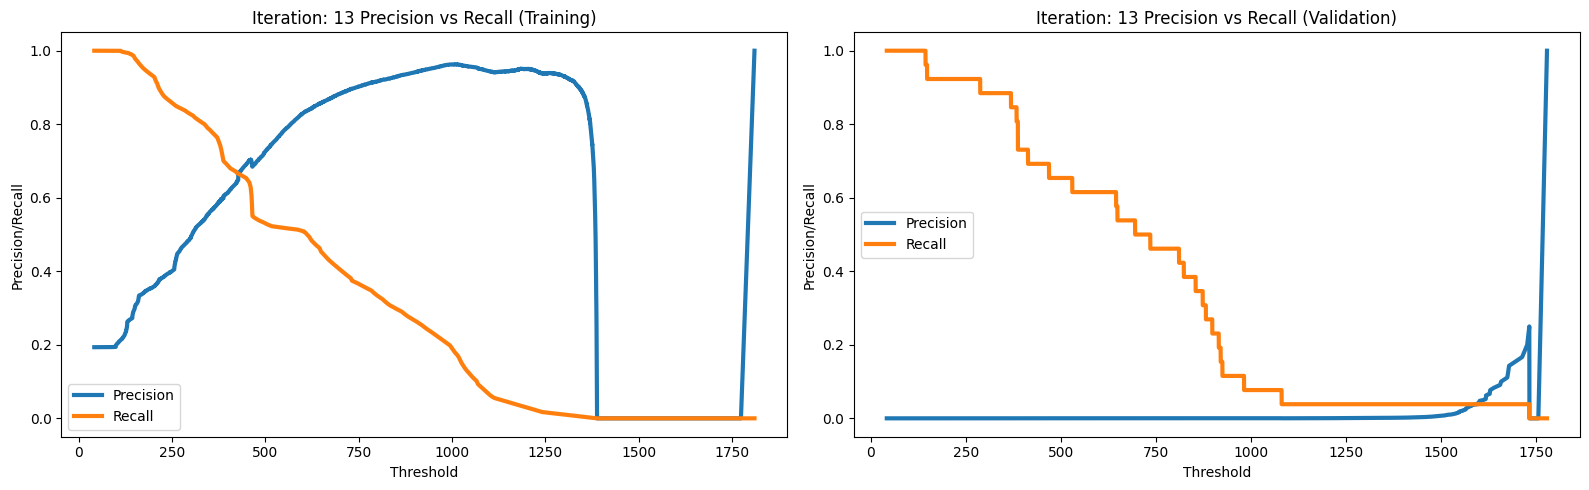

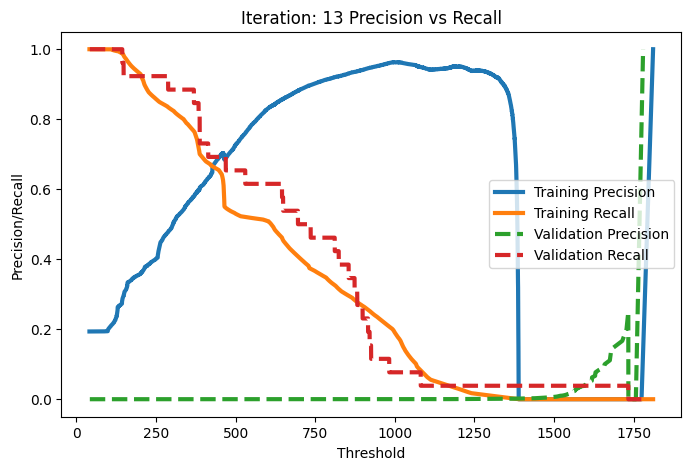

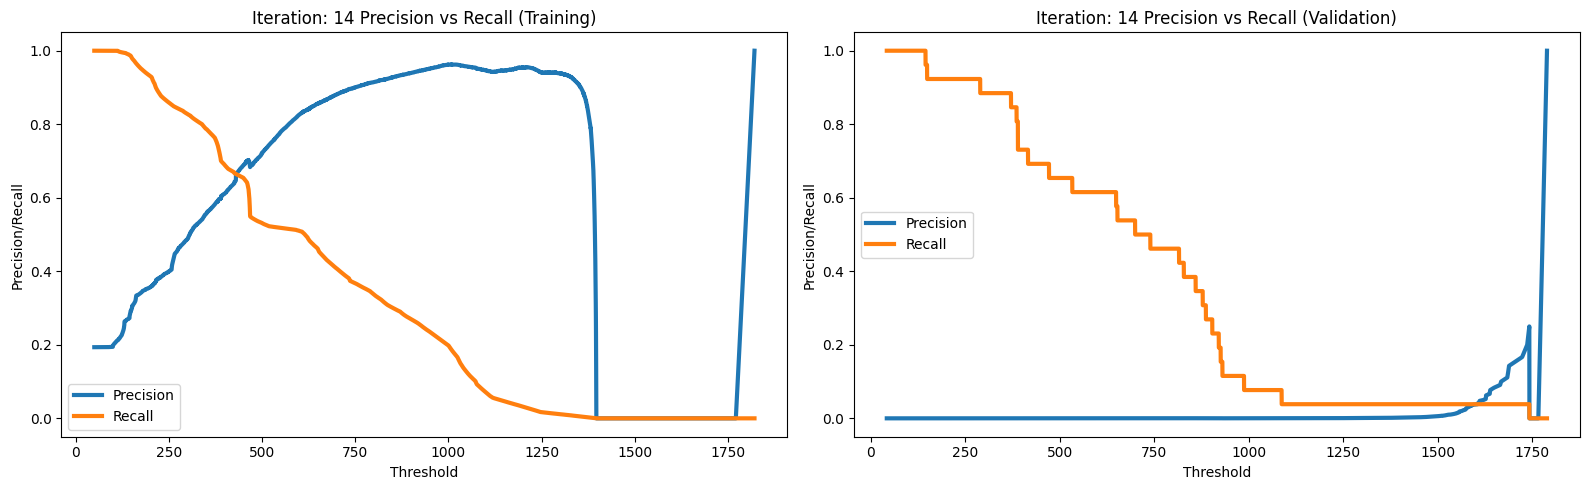

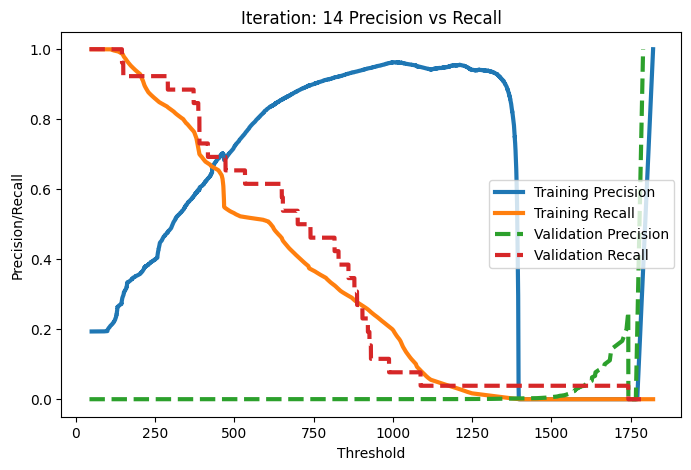

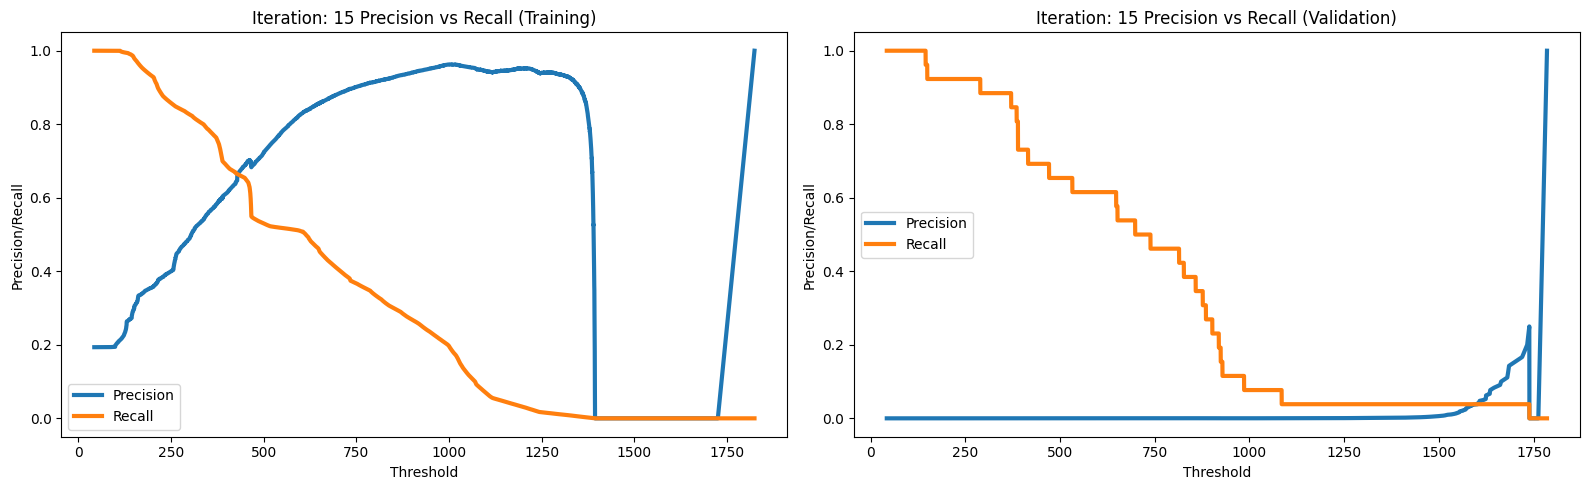

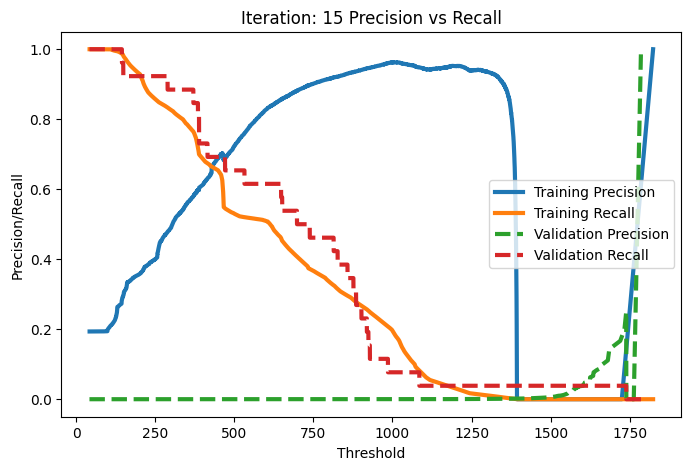

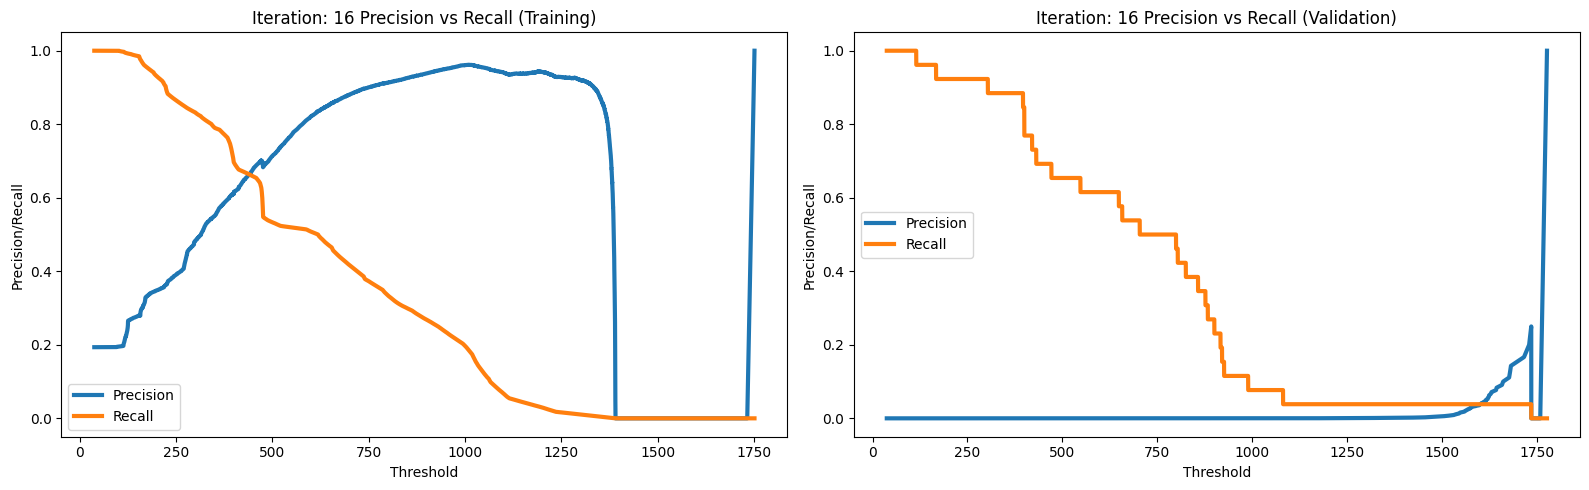

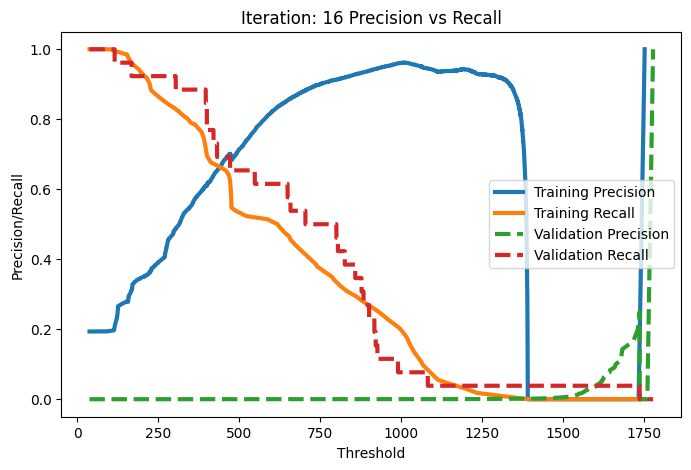

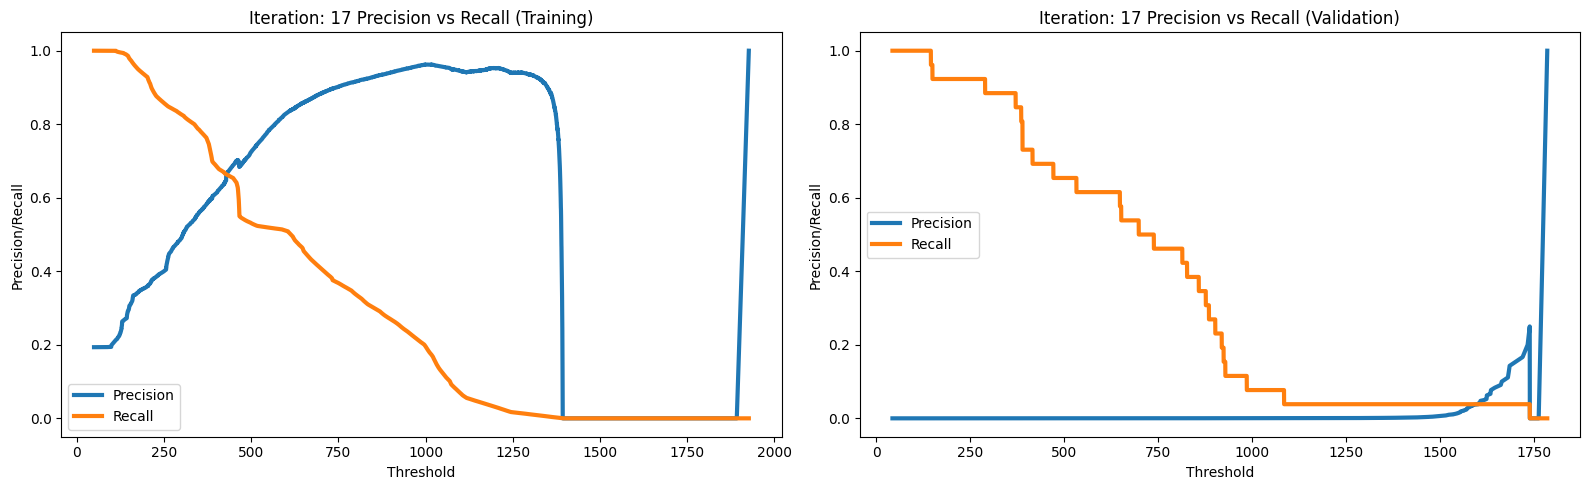

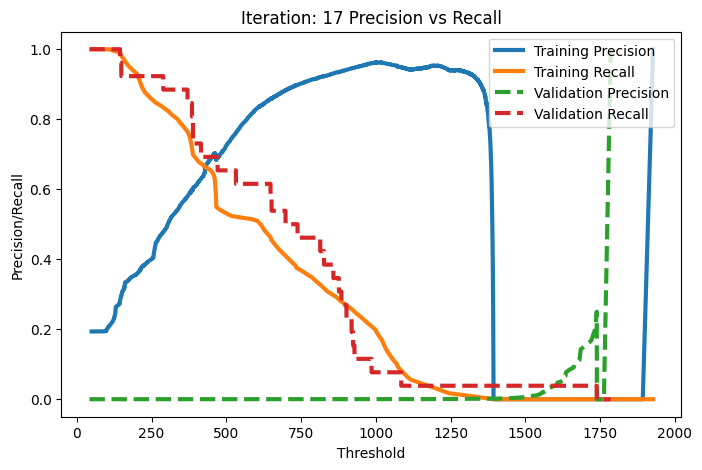

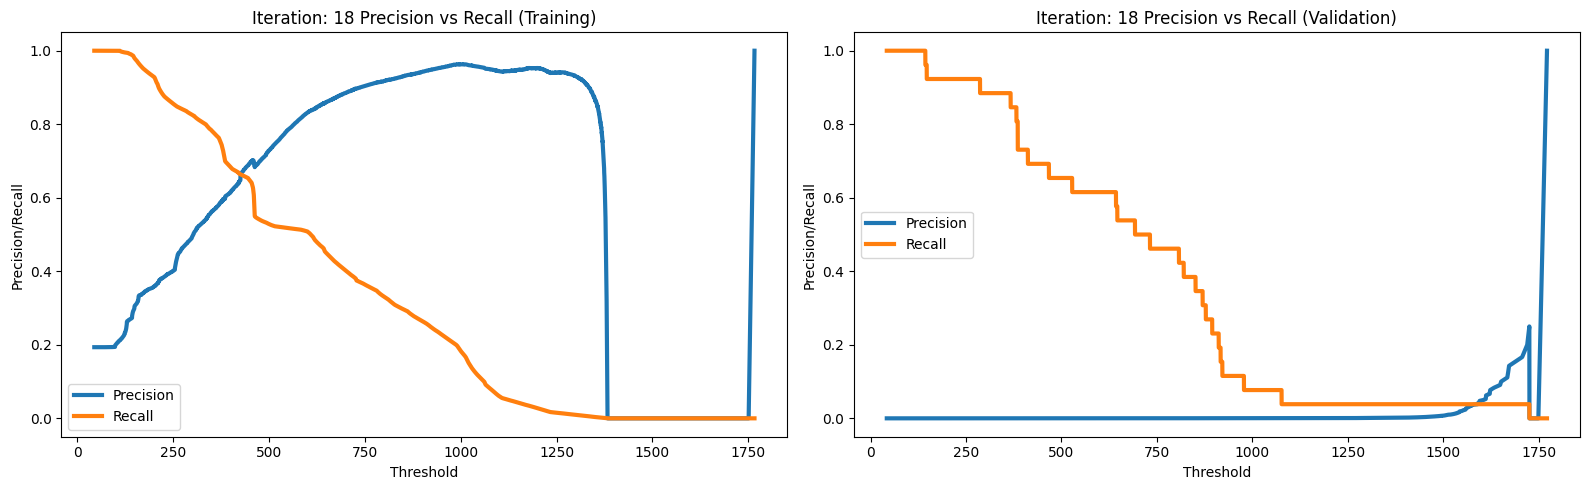

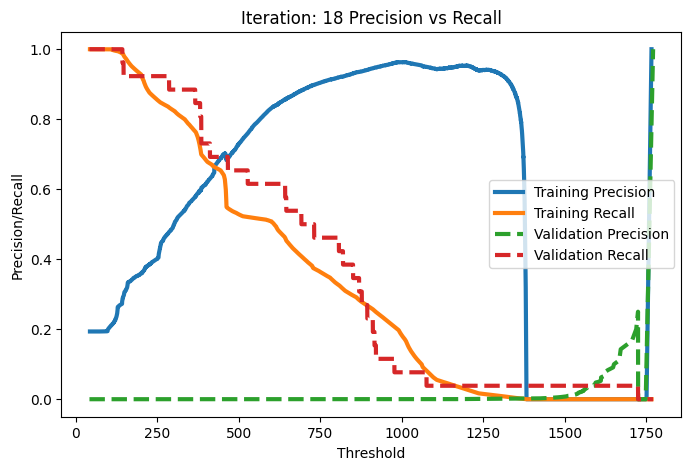

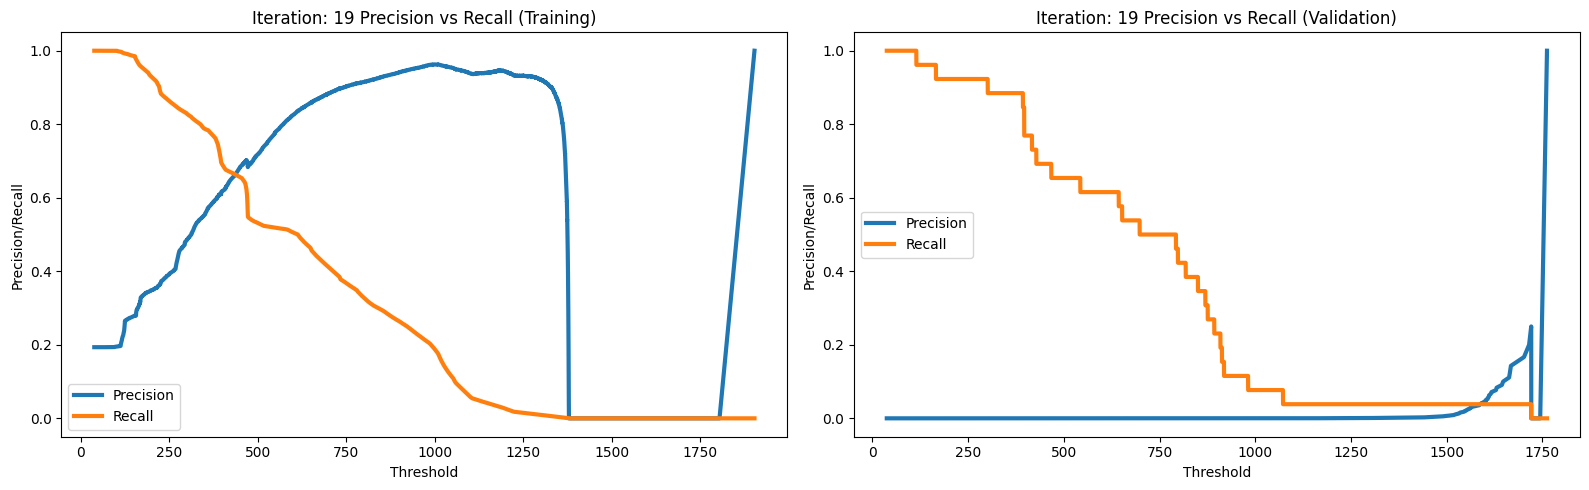

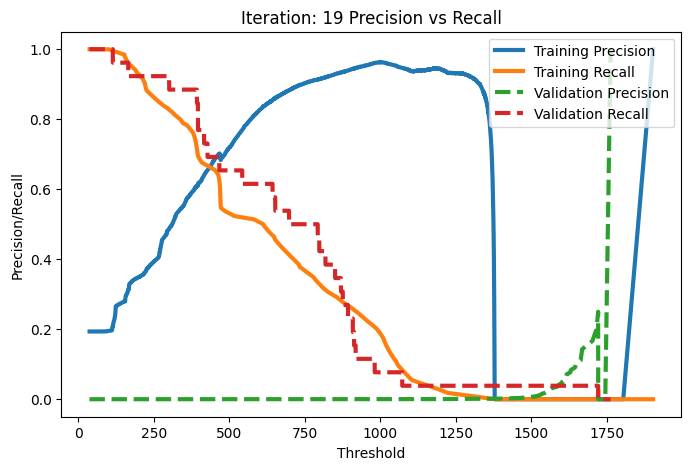

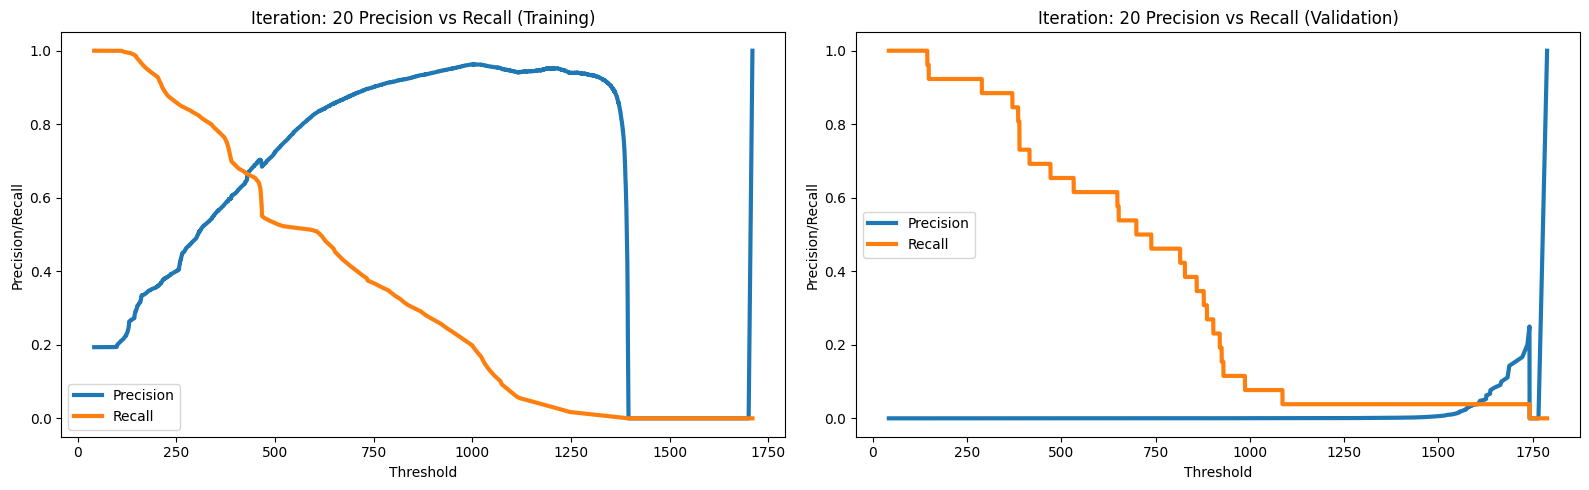

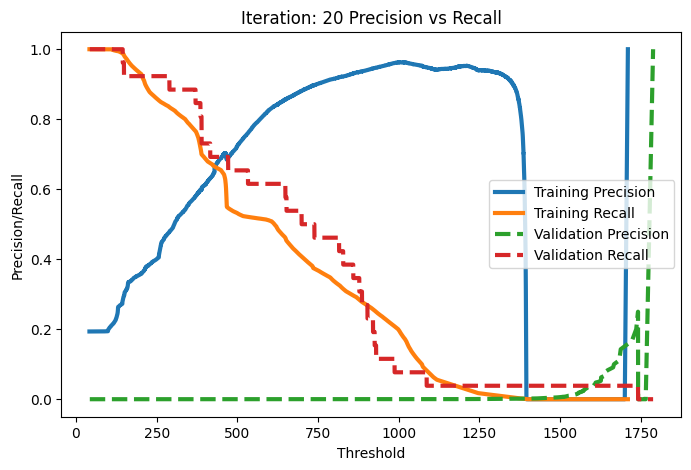

In [113]:
for it in iterations:
    # Training Precision-Recall
    train_precision = training_evaluations[it]['precision_rt']
    train_recall = training_evaluations[it]['recall_rt']
    train_thresholds = training_evaluations[it]['threshold_rt']
    
    # Validation Precision-Recall
    test_precision = test_evaluations[it]['precision_rt']
    test_recall = test_evaluations[it]['recall_rt']
    test_thresholds = test_evaluations[it]['threshold_rt']

    # Plot Precision-Recall for both Training and Validation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Training Precision-Recall
    ax1.plot(train_thresholds, train_precision[1:], label="Precision", linewidth=3)
    ax1.plot(train_thresholds, train_recall[1:], label="Recall", linewidth=3)
    ax1.legend()
    ax1.set_title(f'Iteration: {it} Precision vs Recall (Training)')
    ax1.set_ylabel('Precision/Recall')
    ax1.set_xlabel('Threshold')

    # Plot Validation Precision-Recall
    ax2.plot(test_thresholds, test_precision[1:], label="Precision", linewidth=3)
    ax2.plot(test_thresholds, test_recall[1:], label="Recall", linewidth=3)
    ax2.legend()
    ax2.set_title(f'Iteration: {it} Precision vs Recall (Validation)')
    ax2.set_ylabel('Precision/Recall')
    ax2.set_xlabel('Threshold')

    plt.tight_layout()
    plt.show()

    # Combined Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_thresholds, train_precision[1:], label="Training Precision", linewidth=3)
    plt.plot(train_thresholds, train_recall[1:], label="Training Recall", linewidth=3)
    plt.plot(test_thresholds, test_precision[1:], label="Validation Precision", linewidth=3, linestyle='dashed')
    plt.plot(test_thresholds, test_recall[1:], label="Validation Recall", linewidth=3, linestyle='dashed')
    plt.legend()
    plt.title(f'Iteration: {it} Precision vs Recall')
    plt.ylabel('Precision/Recall')
    plt.xlabel('Threshold')
    plt.show()

In [115]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    LABELS = ["Normal", "Fraud"]
    
    conf_matrix_train_norm = conf_matrix_train.astype('float') / conf_matrix_train.sum(axis=1)[:, np.newaxis]
    conf_matrix_test_norm = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(conf_matrix_train_norm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title(f"Training Iteration: {iteration} Confusion Matrix")
    ax1.set_ylabel('True Class')
    ax1.set_xlabel('Predicted Class')

    sns.heatmap(conf_matrix_test_norm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title(f"Test Iteration: {iteration} Confusion Matrix")
    ax2.set_ylabel('True Class')
    ax2.set_xlabel('Predicted Class')

In [116]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

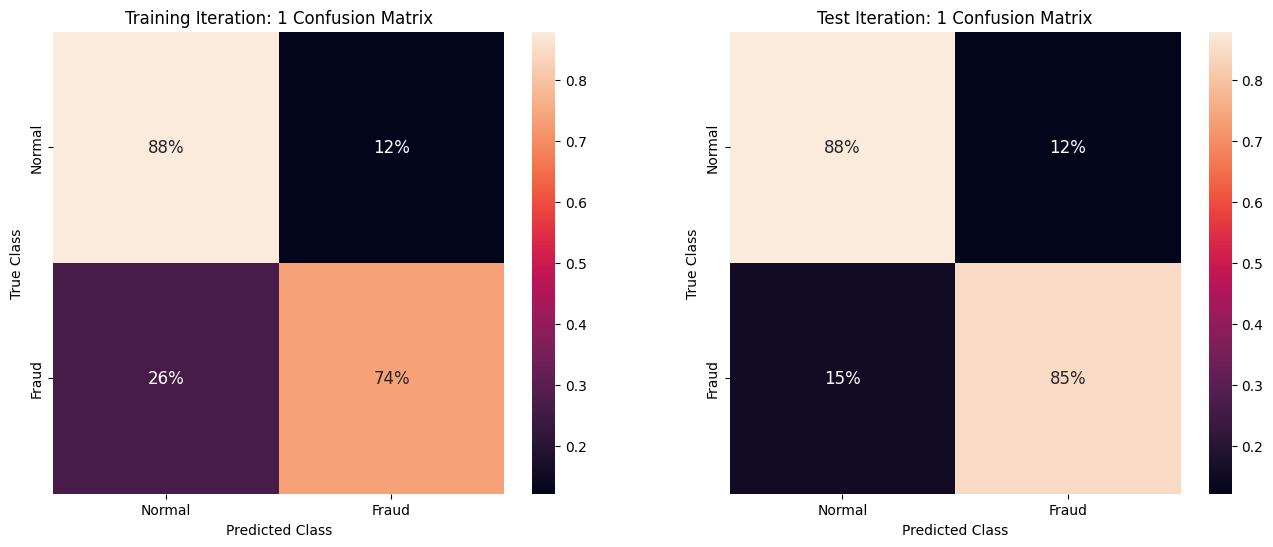

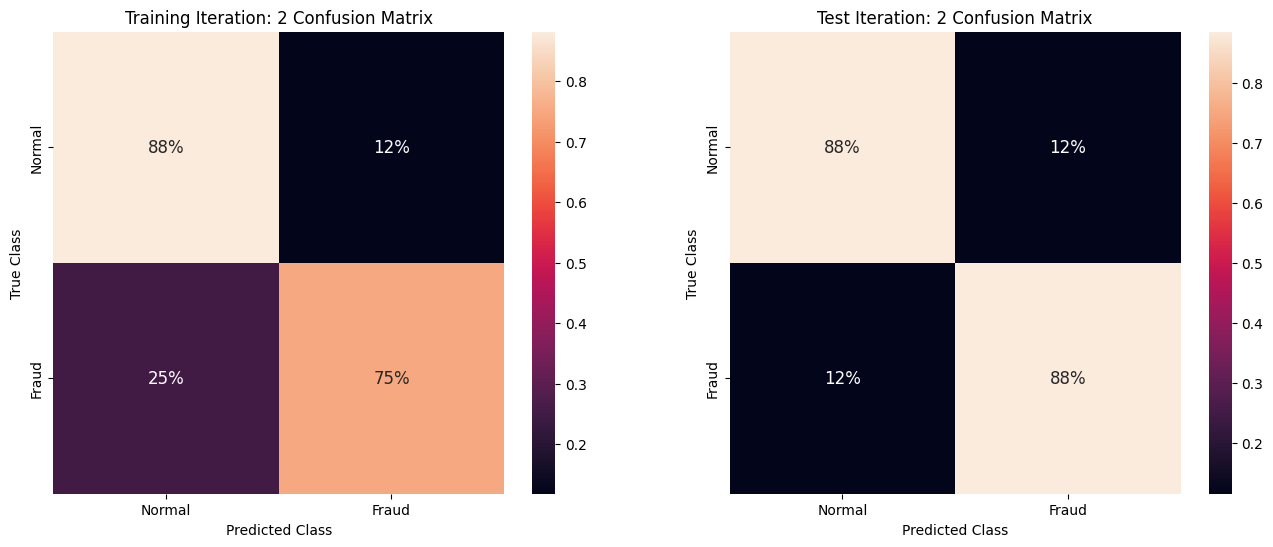

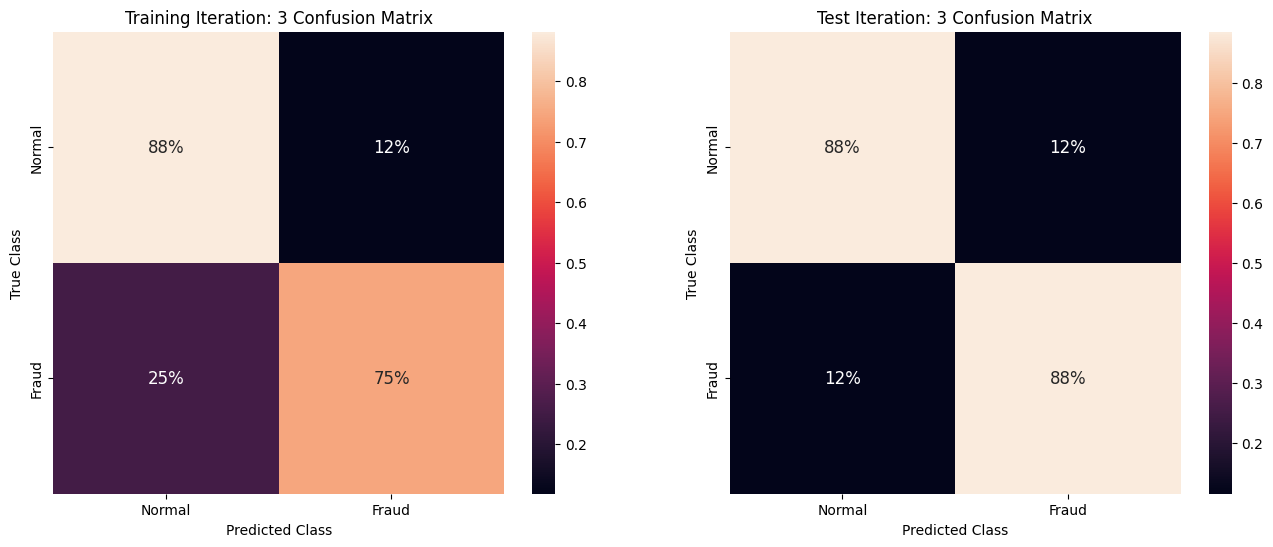

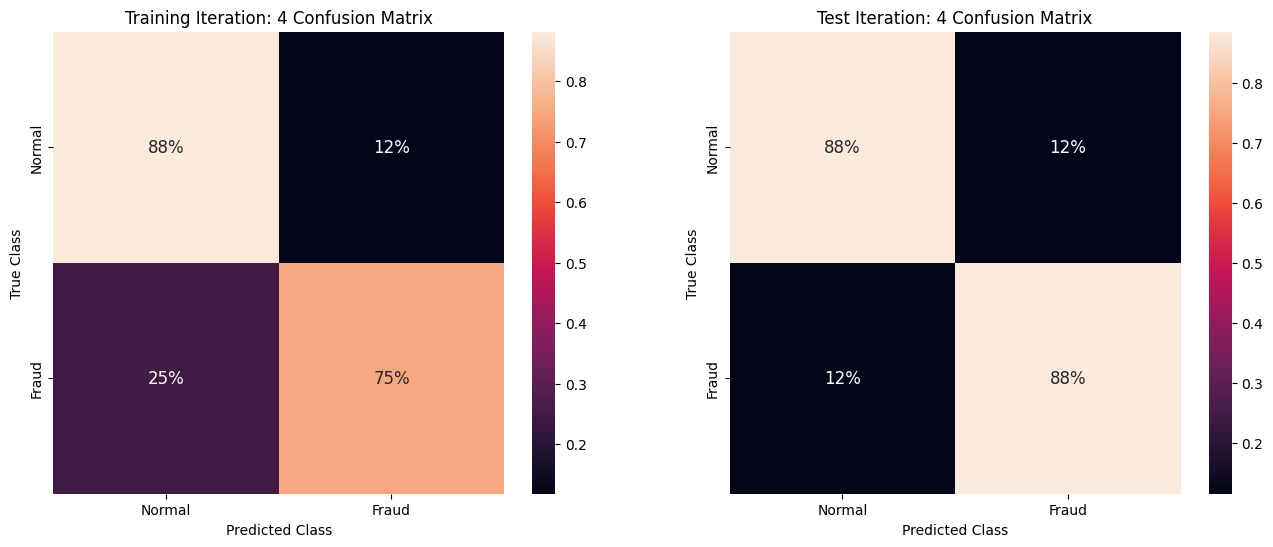

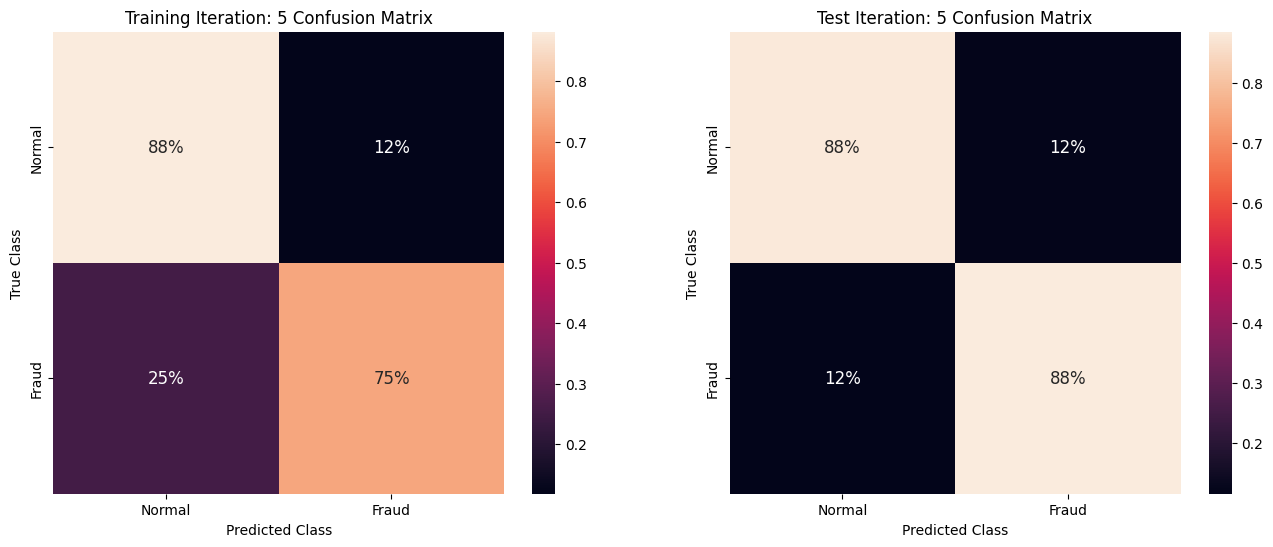

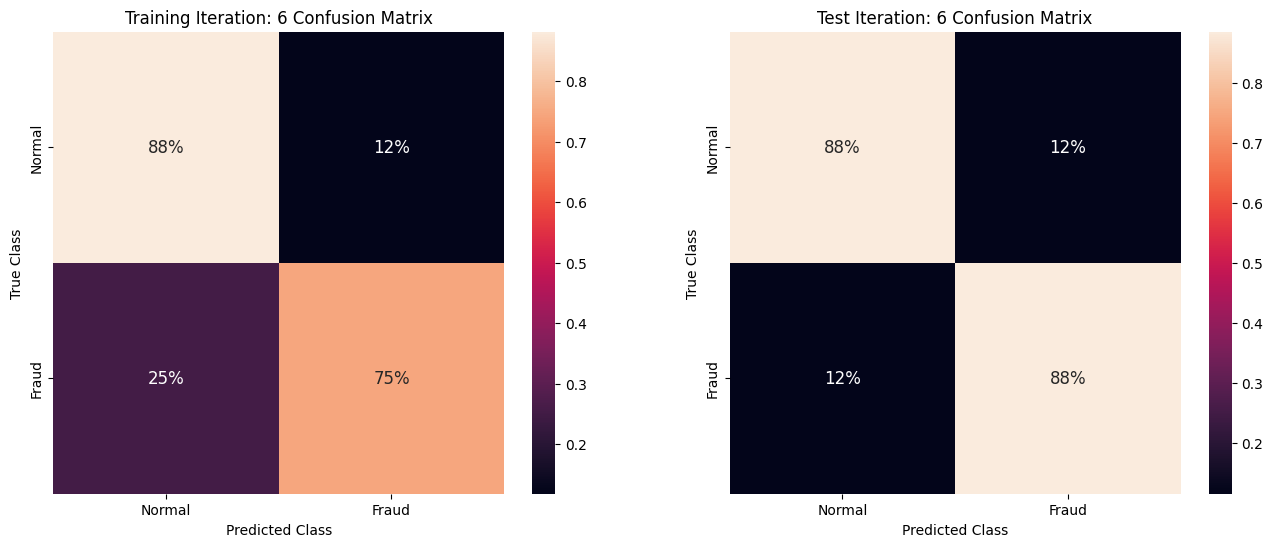

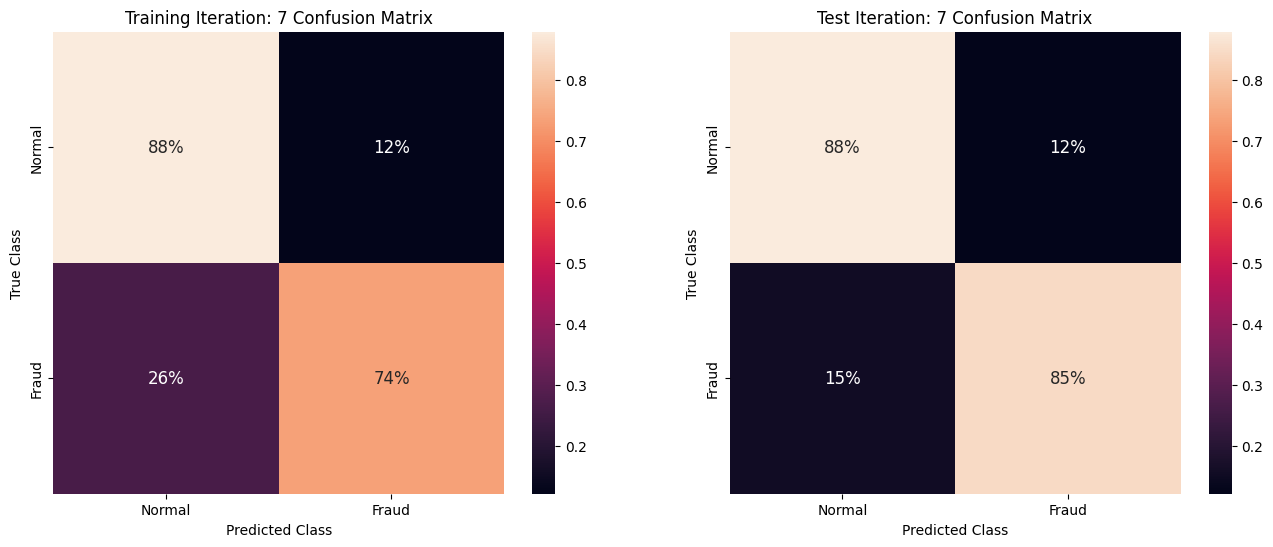

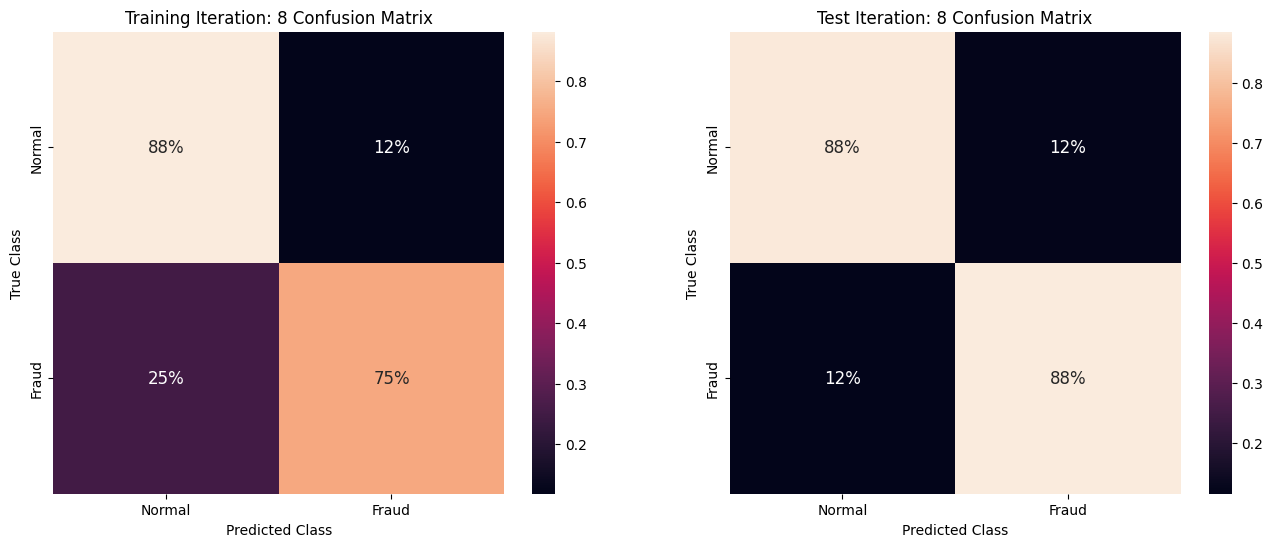

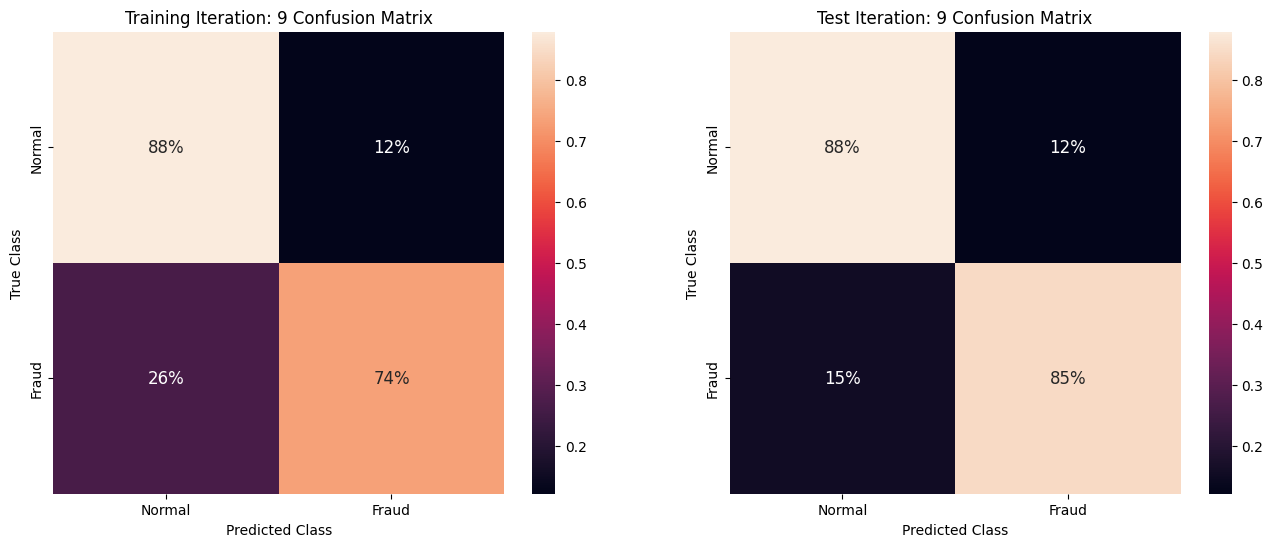

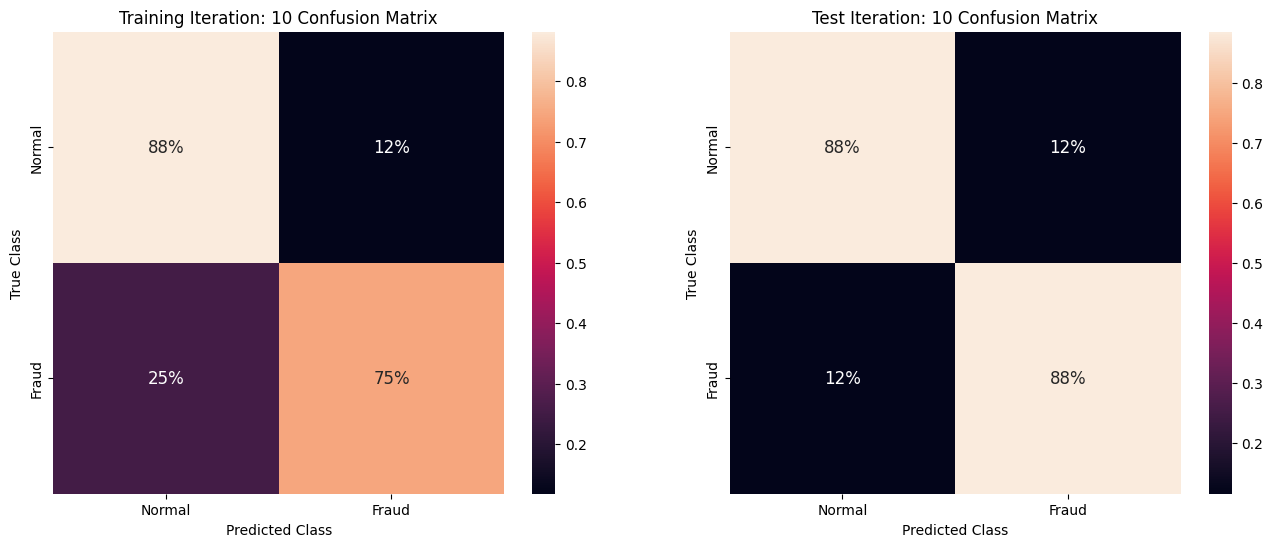

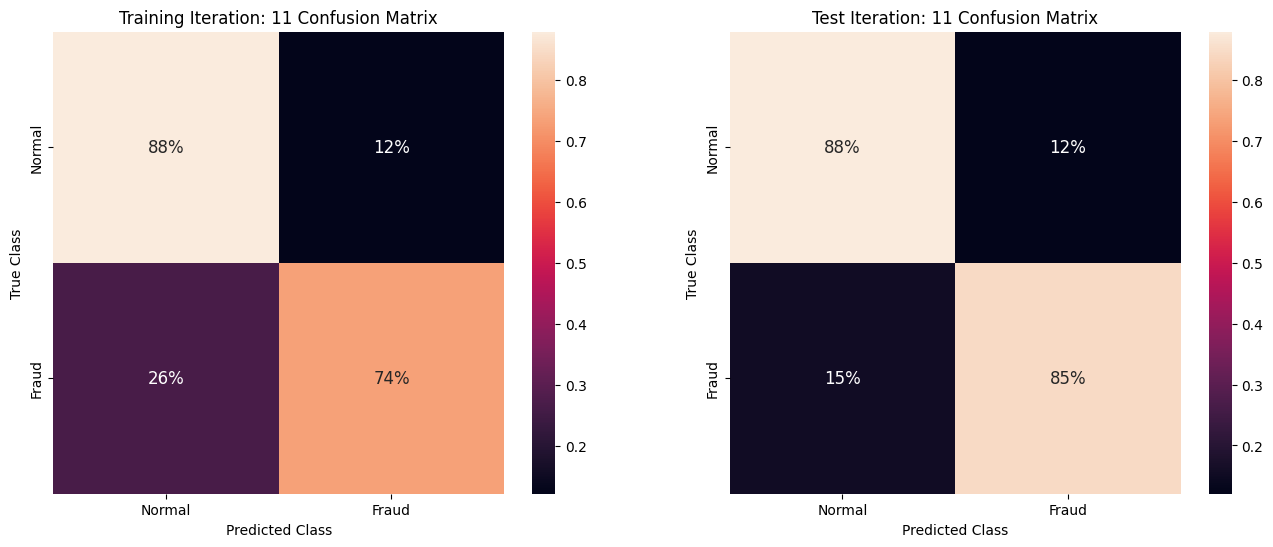

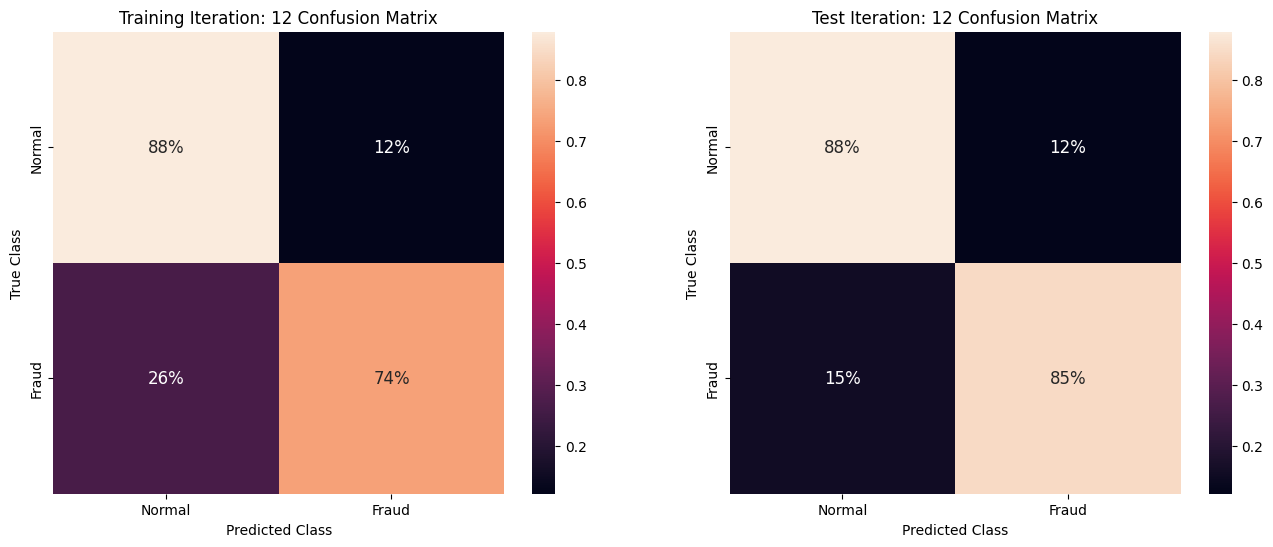

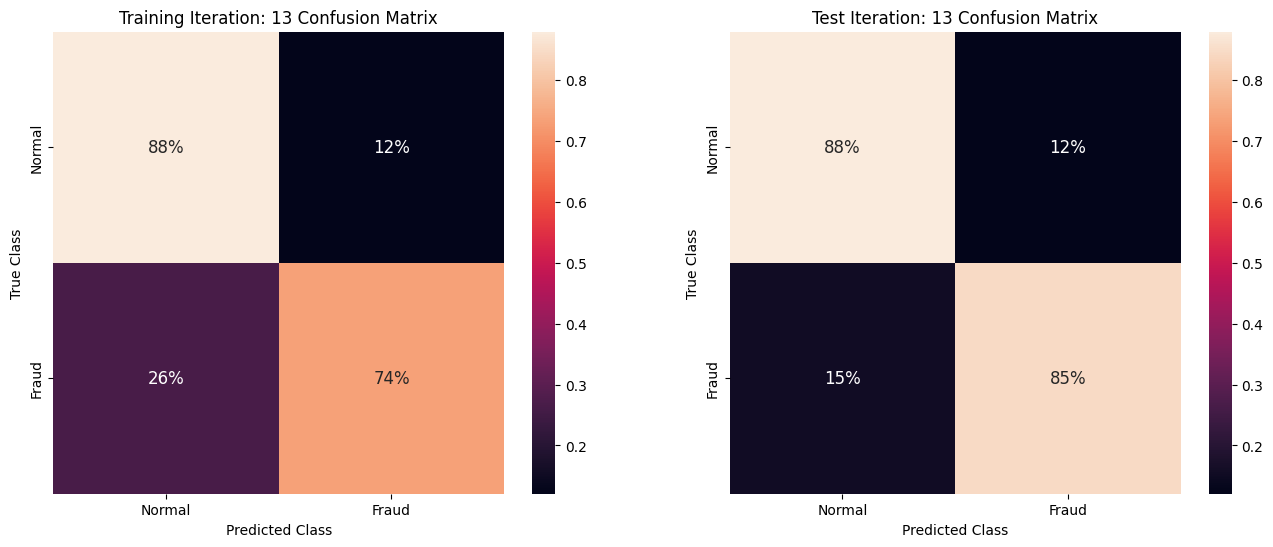

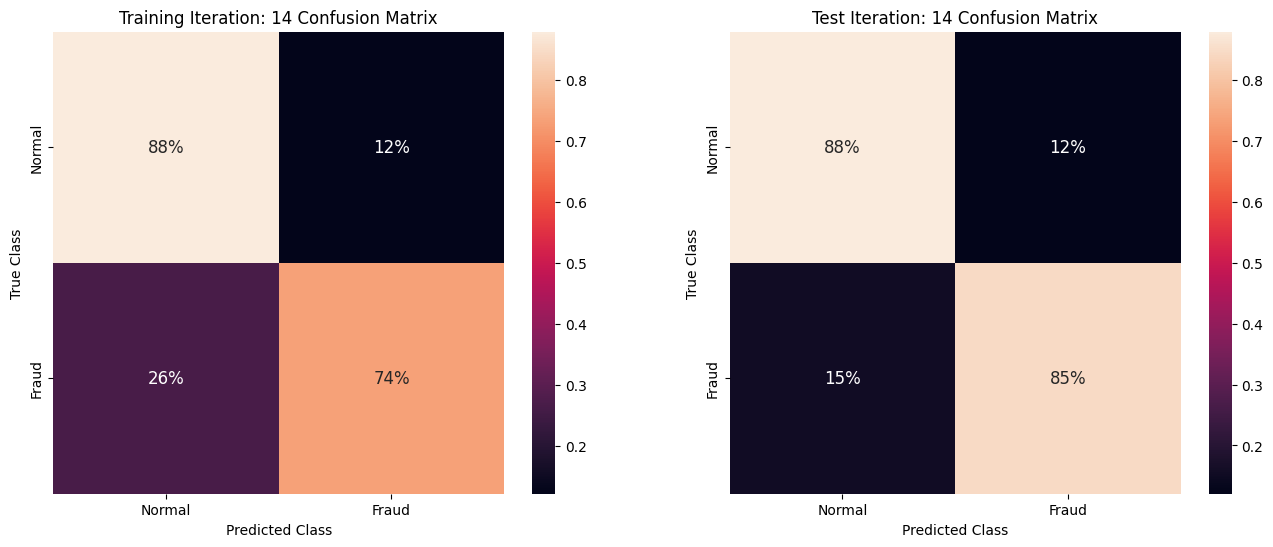

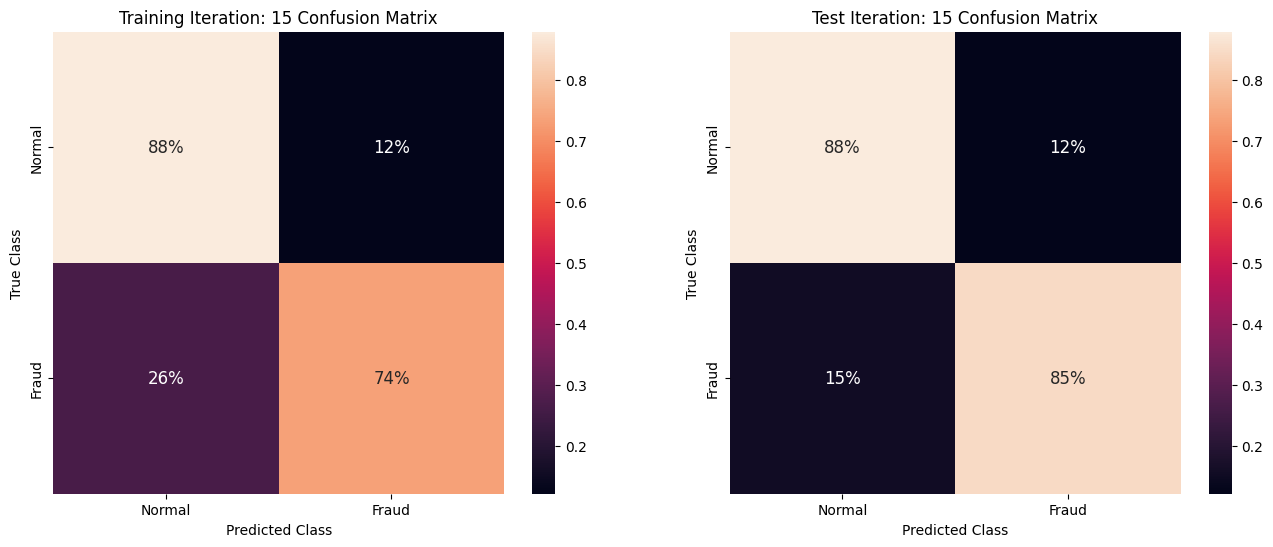

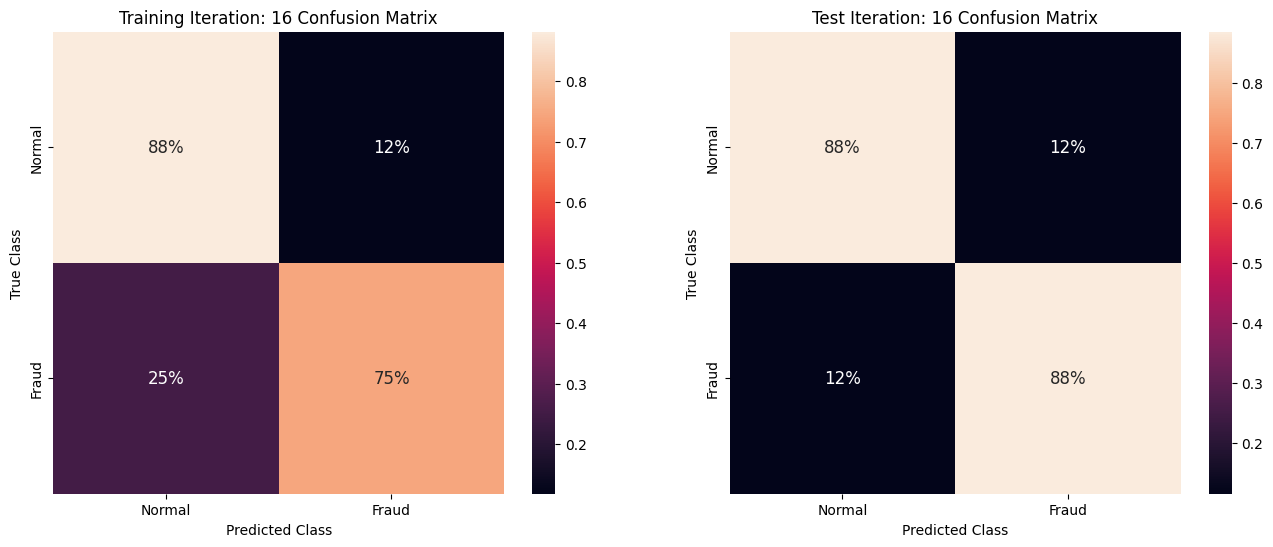

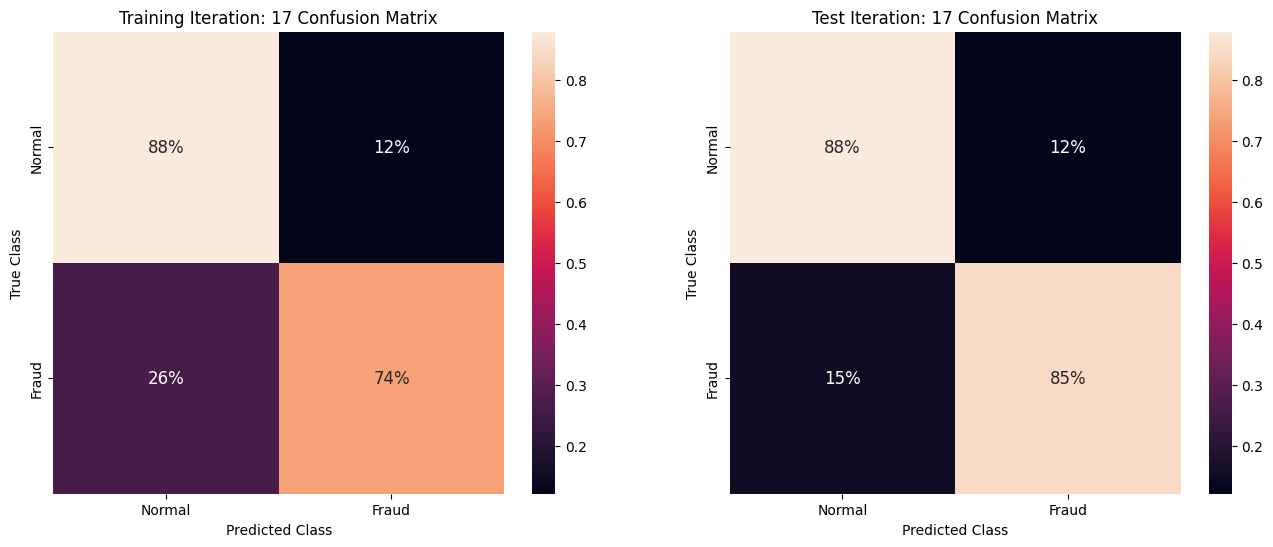

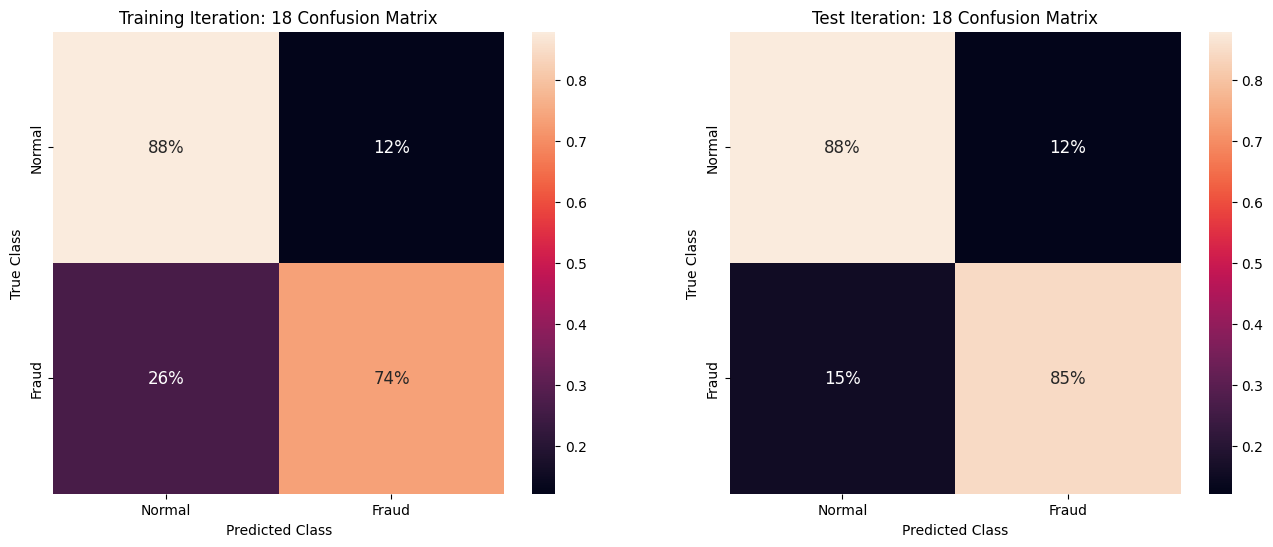

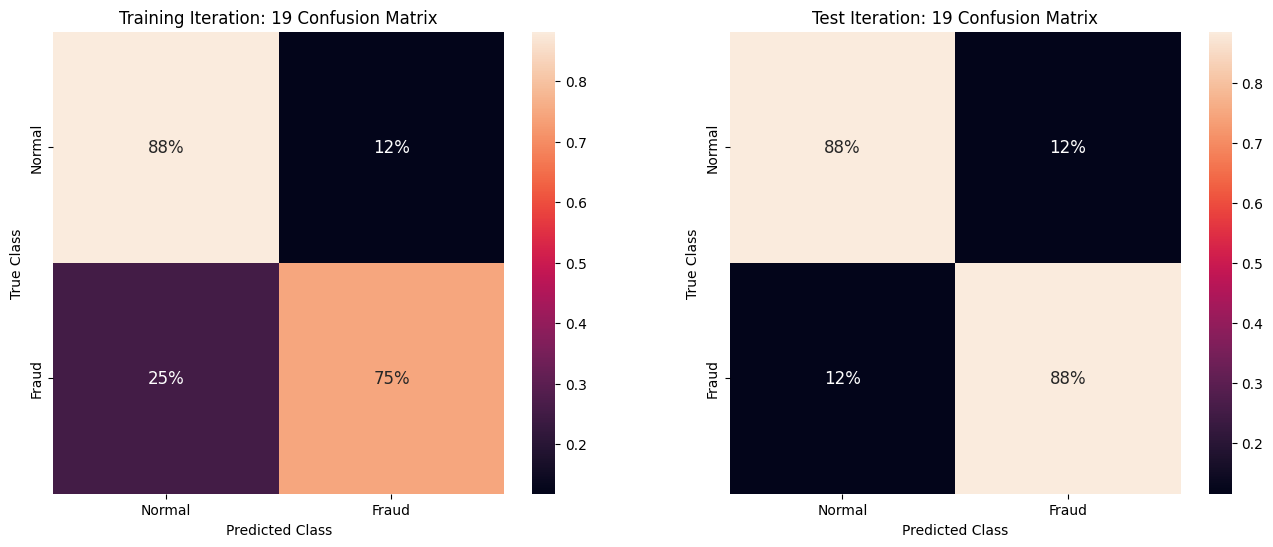

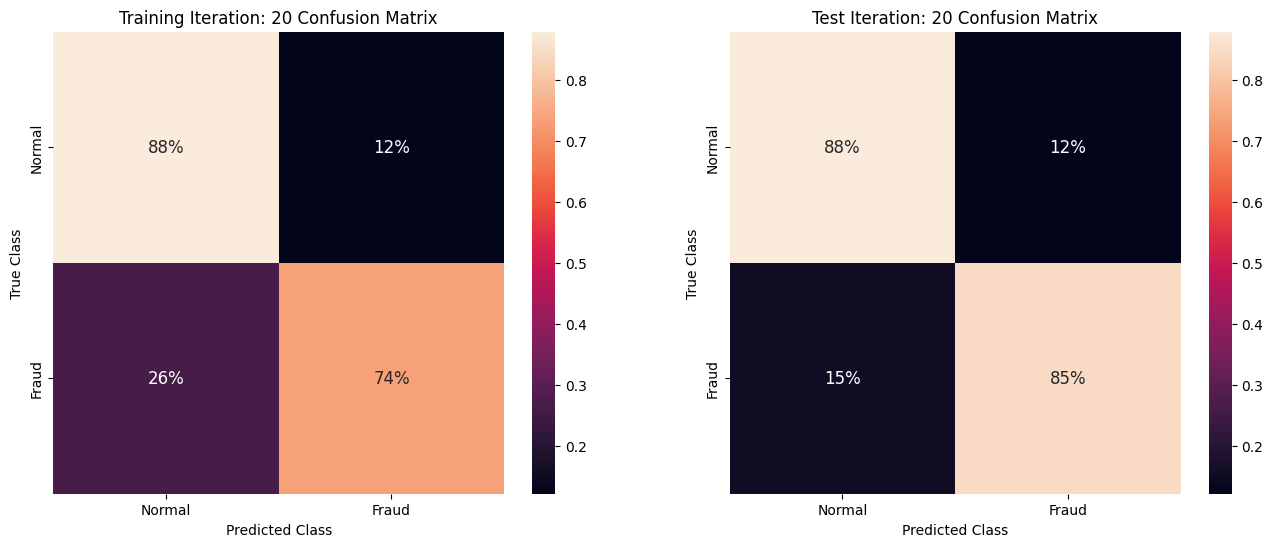

In [117]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

In [120]:
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 26.6 MB/s eta 0:00:00


In [121]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp
import random

space = {
    'n_components': hp.uniform('n_components', 1, 7),
    'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25),
    'tol': hp.uniform('tol', 0.0, 0.9)
}
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
print('Training With:')
print(pd.value_counts(sample_ytrain))
def hyper_parm_opt(space):
    start = time.time()
    n_components = int(space['n_components'])
    n_selected_components = random.randint(1, n_components)
    outliers_fraction = space['outliers_fraction']
    tol = space['tol']
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = PCA(
        n_components=n_components, 
        n_selected_components=n_selected_components, 
        contamination=outliers_fraction, 
        tol=tol, 
        random_state=random_state,
        weighted=True, 
        standardization=False
    )
    clf.fit(X_train)
    y_train_pred = clf.labels_
    score = f1_score(y_train, y_train_pred, average="macro")
    val = 1 - score
    end = time.time()
    print(f'time: {round(end - start, 4)} seconds')
    print(f'params: {space}')
    print(f'val: {val}\n')
    return {'loss': val, 'status': STATUS_OK}
trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print('\n\n\nbest: {}'.format(best))

Training With:
0    2419850
1         82
Name: count, dtype: int64
time: 10.2392 seconds                                  
params: {'n_components': 4.959423240587278, 'outliers_fraction': 0.22431903652752627, 'tol': 0.0783959934727003}
val: 0.21813612935742666                               

time: 9.4735 seconds                                                                
params: {'n_components': 2.9330489891453997, 'outliers_fraction': 0.15520617735888323, 'tol': 0.8526179013061111}
val: 0.2218217159350342                                                             

time: 10.5265 seconds                                                               
params: {'n_components': 6.533635719941387, 'outliers_fraction': 0.23509331274767403, 'tol': 0.6848442680603267}
val: 0.21339828116986514                                                            

time: 9.446 seconds                                                                 
params: {'n_components': 2.5653599434511607, 'outlier